#Installs

In [ ]:
pip install transformers datasets torch numpy pytorch_forecasting


In [ ]:
# /content/synthetic_demand_data_4.csv

In [ ]:
from pytorch_forecasting.metrics import QuantileLoss

#First Attempt- using Random Forest Regressor And Gradient Boosting And Semi-Finetuned Bert

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load the synthetic demand dataset
synthetic_demand_data = pd.read_csv("synthetic_demand_data_4.csv")

# Prepare the DataFrame
data_df = pd.DataFrame({
    "time_idx": np.arange(len(synthetic_demand_data)),
    "demand": synthetic_demand_data['demand']
})

# Create lag features for time series forecasting
max_lag = 14  # Use past 14 days to predict the next day
for lag in range(1, max_lag + 1):
    data_df[f"lag_{lag}"] = data_df["demand"].shift(lag)

# Drop rows with NaN values generated by lagging
data_df.dropna(inplace=True)

# Split data into features and target
X = data_df.drop(columns=["demand", "time_idx"])
y = data_df["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error: {mae}")

# Optional: Inspect predictions vs actual values
predictions_df = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_pred
})

print(predictions_df.head())


Mean Absolute Error: 24.76032967032967
      Actual  Predicted
2922    55.0      59.94
2923    80.0      66.43
2924    71.0      74.99
2925    90.0      80.35
2926   116.0      87.37


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load the synthetic demand dataset
synthetic_demand_data = pd.read_csv("synthetic_demand_data_4.csv")

# Prepare the DataFrame
data_df = pd.DataFrame({
    "time_idx": np.arange(len(synthetic_demand_data)),
    "demand": synthetic_demand_data['demand']
})

# Create lag features for time series forecasting
max_lag = 14  # Use past 14 days to predict the next day
for lag in range(1, max_lag + 1):
    data_df[f"lag_{lag}"] = data_df["demand"].shift(lag)

# Drop rows with NaN values generated by lagging
data_df.dropna(inplace=True)

# Split data into features and target
X = data_df.drop(columns=["demand", "time_idx"])
y = data_df["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the Random Forest model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error: {mae}")

# Optional: Inspect predictions vs actual values
predictions_df = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_pred
})

print(predictions_df.head())


Mean Absolute Error: 25.64706771419507
      Actual  Predicted
2922    55.0  62.057118
2923    80.0  59.966905
2924    71.0  73.413073
2925    90.0  74.605955
2926   116.0  88.692743


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load the synthetic demand dataset
synthetic_demand_data = pd.read_csv("synthetic_demand_data_4.csv")

# Prepare the DataFrame
data_df = pd.DataFrame({
    "time_idx": np.arange(len(synthetic_demand_data)),
    "demand": synthetic_demand_data['demand']
})

# Create lag features for time series forecasting
max_lag = 14
for lag in range(1, max_lag + 1):
    data_df[f"lag_{lag}"] = data_df["demand"].shift(lag)

data_df.dropna(inplace=True)

X = data_df.drop(columns=["demand", "time_idx"])
y = data_df["demand"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 25.15273662975856


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Load the synthetic demand dataset
synthetic_demand_data = pd.read_csv("synthetic_demand_data_4.csv")

# Prepare the DataFrame
data_df = pd.DataFrame({
    "time_idx": np.arange(len(synthetic_demand_data)),
    "demand": synthetic_demand_data['demand']
})

# Fit the SARIMA model
model = SARIMAX(data_df["demand"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)

# Make predictions
preds = sarima_fit.get_forecast(steps=len(data_df) - training_cutoff)
y_pred = preds.predicted_mean
y_val = data_df["demand"].iloc[training_cutoff:]

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 44.83506068663369


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from tqdm import tqdm

# Load your dataset
data = pd.read_csv("synthetic_demand_data_4.csv")  # Replace with your dataset file

# Print the column names to check for 'demand'
print("Columns in the dataset:", data.columns.tolist())

# Check the first few rows of the DataFrame
print("Sample data:\n", data.head())

# Select important features
try:
    data = data[['date', 'product_id', 'current_stock', 'restock_amount',
                 'is_promotion', 'is_holiday', 'is_peak_season', 'reorder_point',
                 'lead_time', 'demand_lag_1', 'demand_lag_2', 'demand_lag_3',
                 'demand_rolling_mean', 'demand_rolling_std', 'demand']]  # Ensure 'demand' is included
except KeyError as e:
    print(f"KeyError: {e}. Please check the column names in your dataset.")

# Prepare your text input (concatenate features into a string for BERT)
data['input_text'] = data.apply(lambda x: f"Date: {x['date']} | Product ID: {x['product_id']} | "
                                          f"Current Stock: {x['current_stock']} | Restock Amount: {x['restock_amount']} | "
                                          f"Promotion: {x['is_promotion']} | Holiday: {x['is_holiday']} | "
                                          f"Peak Season: {x['is_peak_season']} | Reorder Point: {x['reorder_point']} | "
                                          f"Lead Time: {x['lead_time']} | Demand Lag 1: {x['demand_lag_1']} | "
                                          f"Demand Lag 2: {x['demand_lag_2']} | Demand Lag 3: {x['demand_lag_3']} | "
                                          f"Rolling Mean: {x['demand_rolling_mean']} | Rolling Std: {x['demand_rolling_std']}",
                                          axis=1)

# Define dataset and dataloader
class DemandDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]

        # Tokenize and encode the text
        encoding = self.tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=512)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)  # Assuming demand is continuous
        }

# Create dataset
try:
    dataset = DemandDataset(data['input_text'].tolist(), data['demand'].tolist())  # Assuming 'demand' is your target
except KeyError as e:
    print(f"KeyError: {e}. Please ensure the 'demand' column exists in your DataFrame.")

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Set num_labels to 1 for regression

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop with tqdm
model.train()
num_epochs = 5  # Set the number of epochs

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader):
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=targets)

        # Compute loss
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item():.4f}")

# After training, you may want to evaluate your model on a validation/test dataset as needed.


Columns in the dataset: ['date', 'product_id', 'demand', 'current_stock', 'restock_amount', 'stockout_days', 'is_promotion', 'is_holiday', 'is_peak_season', 'reorder_point', 'lead_time', 'max_stock', 'unemployment_rate', 'consumer_confidence', 'inflation_rate', 'day_of_week', 'month', 'year', 'quarter', 'demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_rolling_mean', 'demand_rolling_std']
Sample data:
          date product_id  demand  current_stock  restock_amount  \
0  2023-01-01       P001    98.0          279.0             0.0   
1  2023-01-01       P002   122.0          389.0             0.0   
2  2023-01-01       P003   125.0          524.0             0.0   
3  2023-01-01       P004   140.0          277.0             0.0   
4  2023-01-01       P005   152.0          327.0             0.0   

   stockout_days  is_promotion  is_holiday  is_peak_season  reorder_point  \
0            0.0           0.0           1               0            180   
1            0.0           0.0 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5


  0%|          | 1/229 [00:03<14:18,  3.77s/it]

Loss: 26330.6953


  1%|          | 2/229 [00:05<08:57,  2.37s/it]

Loss: 11382.0098


  1%|▏         | 3/229 [00:06<07:13,  1.92s/it]

Loss: 20560.5176


  2%|▏         | 4/229 [00:07<06:24,  1.71s/it]

Loss: 11701.9570


  2%|▏         | 5/229 [00:09<05:55,  1.59s/it]

Loss: 14048.2041


  3%|▎         | 6/229 [00:10<05:38,  1.52s/it]

Loss: 14487.8008


  3%|▎         | 7/229 [00:12<05:27,  1.47s/it]

Loss: 18969.9883


  3%|▎         | 8/229 [00:13<05:20,  1.45s/it]

Loss: 13406.5020


  4%|▍         | 9/229 [00:14<05:17,  1.44s/it]

Loss: 13283.0791


  4%|▍         | 10/229 [00:16<05:12,  1.43s/it]

Loss: 15802.1523


  5%|▍         | 11/229 [00:17<05:09,  1.42s/it]

Loss: 14361.4629


  5%|▌         | 12/229 [00:19<05:07,  1.42s/it]

Loss: 15812.3047


  6%|▌         | 13/229 [00:20<05:06,  1.42s/it]

Loss: 15676.0996


  6%|▌         | 14/229 [00:21<05:05,  1.42s/it]

Loss: 12062.6152


  7%|▋         | 15/229 [00:23<05:04,  1.42s/it]

Loss: 16792.6660


  7%|▋         | 16/229 [00:24<05:02,  1.42s/it]

Loss: 12840.9492


  7%|▋         | 17/229 [00:26<05:02,  1.43s/it]

Loss: 17623.9980


  8%|▊         | 18/229 [00:27<05:03,  1.44s/it]

Loss: 20394.4961


  8%|▊         | 19/229 [00:29<05:02,  1.44s/it]

Loss: 16013.1328


  9%|▊         | 20/229 [00:30<05:01,  1.44s/it]

Loss: 16813.3301


  9%|▉         | 21/229 [00:32<04:59,  1.44s/it]

Loss: 10126.8320


 10%|▉         | 22/229 [00:33<04:58,  1.44s/it]

Loss: 13323.2988


 10%|█         | 23/229 [00:34<04:56,  1.44s/it]

Loss: 19916.0020


 10%|█         | 24/229 [00:36<04:56,  1.45s/it]

Loss: 7648.9131


 11%|█         | 25/229 [00:37<04:56,  1.45s/it]

Loss: 13168.1230


 11%|█▏        | 26/229 [00:39<04:56,  1.46s/it]

Loss: 10925.3750


 12%|█▏        | 27/229 [00:40<04:55,  1.46s/it]

Loss: 14239.7021


 12%|█▏        | 28/229 [00:42<04:54,  1.46s/it]

Loss: 15476.1641


 13%|█▎        | 29/229 [00:43<04:53,  1.47s/it]

Loss: 13718.6973


 13%|█▎        | 30/229 [00:45<04:52,  1.47s/it]

Loss: 19306.0664


 14%|█▎        | 31/229 [00:46<04:52,  1.48s/it]

Loss: 16536.1484


 14%|█▍        | 32/229 [00:48<04:53,  1.49s/it]

Loss: 12355.8115


 14%|█▍        | 33/229 [00:49<04:53,  1.50s/it]

Loss: 13112.4482


 15%|█▍        | 34/229 [00:51<04:53,  1.51s/it]

Loss: 10445.5195


 15%|█▌        | 35/229 [00:52<04:53,  1.51s/it]

Loss: 11205.8584


 16%|█▌        | 36/229 [00:54<04:53,  1.52s/it]

Loss: 8275.1660


 16%|█▌        | 37/229 [00:55<04:51,  1.52s/it]

Loss: 15918.0527


 17%|█▋        | 38/229 [00:57<04:51,  1.53s/it]

Loss: 11807.4570


 17%|█▋        | 39/229 [00:58<04:50,  1.53s/it]

Loss: 14260.8623


 17%|█▋        | 40/229 [01:00<04:50,  1.54s/it]

Loss: 16717.5742


 18%|█▊        | 41/229 [01:02<04:49,  1.54s/it]

Loss: 19078.2266


 18%|█▊        | 42/229 [01:03<04:48,  1.54s/it]

Loss: 23917.8770


 19%|█▉        | 43/229 [01:05<04:49,  1.55s/it]

Loss: 15890.3438


 19%|█▉        | 44/229 [01:06<04:47,  1.56s/it]

Loss: 16474.9746


 20%|█▉        | 45/229 [01:08<04:46,  1.56s/it]

Loss: 10639.7695


 20%|██        | 46/229 [01:09<04:45,  1.56s/it]

Loss: 13537.8926


 21%|██        | 47/229 [01:11<04:44,  1.56s/it]

Loss: 16052.0605


 21%|██        | 48/229 [01:12<04:42,  1.56s/it]

Loss: 17845.6270


 21%|██▏       | 49/229 [01:14<04:39,  1.55s/it]

Loss: 16126.2539


 22%|██▏       | 50/229 [01:16<04:37,  1.55s/it]

Loss: 18548.0703


 22%|██▏       | 51/229 [01:17<04:34,  1.54s/it]

Loss: 12351.5195


 23%|██▎       | 52/229 [01:19<04:32,  1.54s/it]

Loss: 10917.4092


 23%|██▎       | 53/229 [01:20<04:30,  1.54s/it]

Loss: 13405.2617


 24%|██▎       | 54/229 [01:22<04:27,  1.53s/it]

Loss: 8956.2207


 24%|██▍       | 55/229 [01:23<04:25,  1.52s/it]

Loss: 13139.8701


 24%|██▍       | 56/229 [01:25<04:22,  1.52s/it]

Loss: 13035.4932


 25%|██▍       | 57/229 [01:26<04:20,  1.51s/it]

Loss: 12195.4912


 25%|██▌       | 58/229 [01:28<04:18,  1.51s/it]

Loss: 17026.9492


 26%|██▌       | 59/229 [01:29<04:16,  1.51s/it]

Loss: 13770.3750


 26%|██▌       | 60/229 [01:31<04:13,  1.50s/it]

Loss: 8393.2949


 27%|██▋       | 61/229 [01:32<04:11,  1.50s/it]

Loss: 11720.9082


 27%|██▋       | 62/229 [01:34<04:09,  1.49s/it]

Loss: 15304.6680


 28%|██▊       | 63/229 [01:35<04:07,  1.49s/it]

Loss: 12568.1152


 28%|██▊       | 64/229 [01:37<04:05,  1.49s/it]

Loss: 10355.9131


 28%|██▊       | 65/229 [01:38<04:03,  1.49s/it]

Loss: 11899.9785


 29%|██▉       | 66/229 [01:40<04:02,  1.49s/it]

Loss: 21305.0742


 29%|██▉       | 67/229 [01:41<04:01,  1.49s/it]

Loss: 19923.6367


 30%|██▉       | 68/229 [01:43<03:59,  1.49s/it]

Loss: 13441.3125


 30%|███       | 69/229 [01:44<03:57,  1.48s/it]

Loss: 9285.5176


 31%|███       | 70/229 [01:45<03:54,  1.48s/it]

Loss: 10909.4453


 31%|███       | 71/229 [01:47<03:52,  1.47s/it]

Loss: 12610.2305


 31%|███▏      | 72/229 [01:48<03:51,  1.47s/it]

Loss: 9038.5557


 32%|███▏      | 73/229 [01:50<03:49,  1.47s/it]

Loss: 14531.2295


 32%|███▏      | 74/229 [01:51<03:47,  1.47s/it]

Loss: 18436.5703


 33%|███▎      | 75/229 [01:53<03:47,  1.47s/it]

Loss: 14542.5820


 33%|███▎      | 76/229 [01:54<03:46,  1.48s/it]

Loss: 9793.1602


 34%|███▎      | 77/229 [01:56<03:44,  1.48s/it]

Loss: 14082.8535


 34%|███▍      | 78/229 [01:57<03:42,  1.47s/it]

Loss: 16648.0117


 34%|███▍      | 79/229 [01:59<03:41,  1.47s/it]

Loss: 13211.6797


 35%|███▍      | 80/229 [02:00<03:39,  1.47s/it]

Loss: 18092.4648


 35%|███▌      | 81/229 [02:02<03:38,  1.47s/it]

Loss: 11261.2715


 36%|███▌      | 82/229 [02:03<03:36,  1.47s/it]

Loss: 14389.8232


 36%|███▌      | 83/229 [02:05<03:36,  1.48s/it]

Loss: 17029.1367


 37%|███▋      | 84/229 [02:06<03:35,  1.49s/it]

Loss: 11988.9551


 37%|███▋      | 85/229 [02:08<03:33,  1.48s/it]

Loss: 13316.4951


 38%|███▊      | 86/229 [02:09<03:31,  1.48s/it]

Loss: 16915.7559


 38%|███▊      | 87/229 [02:11<03:30,  1.49s/it]

Loss: 7435.5776


 38%|███▊      | 88/229 [02:12<03:29,  1.49s/it]

Loss: 15156.8086


 39%|███▉      | 89/229 [02:14<03:28,  1.49s/it]

Loss: 10194.6719


 39%|███▉      | 90/229 [02:15<03:26,  1.49s/it]

Loss: 10907.4072


 40%|███▉      | 91/229 [02:17<03:26,  1.49s/it]

Loss: 10056.1719


 40%|████      | 92/229 [02:18<03:25,  1.50s/it]

Loss: 14085.3311


 41%|████      | 93/229 [02:20<03:23,  1.50s/it]

Loss: 13672.0479


 41%|████      | 94/229 [02:21<03:22,  1.50s/it]

Loss: 10090.3262


 41%|████▏     | 95/229 [02:23<03:20,  1.50s/it]

Loss: 14957.3047


 42%|████▏     | 96/229 [02:24<03:19,  1.50s/it]

Loss: 12849.5195


 42%|████▏     | 97/229 [02:26<03:17,  1.50s/it]

Loss: 11049.1553


 43%|████▎     | 98/229 [02:27<03:16,  1.50s/it]

Loss: 8345.2998


 43%|████▎     | 99/229 [02:29<03:14,  1.50s/it]

Loss: 13212.4873


 44%|████▎     | 100/229 [02:30<03:14,  1.50s/it]

Loss: 14418.4023


 44%|████▍     | 101/229 [02:32<03:12,  1.51s/it]

Loss: 9989.9121


 45%|████▍     | 102/229 [02:33<03:11,  1.51s/it]

Loss: 14988.6582


 45%|████▍     | 103/229 [02:35<03:10,  1.51s/it]

Loss: 12998.4980


 45%|████▌     | 104/229 [02:36<03:08,  1.51s/it]

Loss: 9444.9707


 46%|████▌     | 105/229 [02:38<03:06,  1.51s/it]

Loss: 10401.3965


 46%|████▋     | 106/229 [02:39<03:04,  1.50s/it]

Loss: 10451.4863


 47%|████▋     | 107/229 [02:41<03:03,  1.50s/it]

Loss: 15521.3516


 47%|████▋     | 108/229 [02:42<03:02,  1.51s/it]

Loss: 16195.7520


 48%|████▊     | 109/229 [02:44<03:01,  1.51s/it]

Loss: 14386.5957


 48%|████▊     | 110/229 [02:45<02:59,  1.51s/it]

Loss: 13292.8262


 48%|████▊     | 111/229 [02:47<02:57,  1.50s/it]

Loss: 9236.1318


 49%|████▉     | 112/229 [02:48<02:55,  1.50s/it]

Loss: 12326.6914


 49%|████▉     | 113/229 [02:50<02:53,  1.50s/it]

Loss: 26019.5586


 50%|████▉     | 114/229 [02:51<02:52,  1.50s/it]

Loss: 11259.2656


 50%|█████     | 115/229 [02:53<02:50,  1.50s/it]

Loss: 16466.7461


 51%|█████     | 116/229 [02:54<02:49,  1.50s/it]

Loss: 10232.3350


 51%|█████     | 117/229 [02:56<02:48,  1.50s/it]

Loss: 8231.5918


 52%|█████▏    | 118/229 [02:57<02:46,  1.50s/it]

Loss: 8816.5322


 52%|█████▏    | 119/229 [02:59<02:44,  1.50s/it]

Loss: 15129.3750


 52%|█████▏    | 120/229 [03:00<02:43,  1.50s/it]

Loss: 10498.6191


 53%|█████▎    | 121/229 [03:02<02:41,  1.49s/it]

Loss: 15243.4258


 53%|█████▎    | 122/229 [03:03<02:39,  1.49s/it]

Loss: 9527.9375


 54%|█████▎    | 123/229 [03:05<02:37,  1.49s/it]

Loss: 9281.6602


 54%|█████▍    | 124/229 [03:06<02:36,  1.49s/it]

Loss: 19914.8965


 55%|█████▍    | 125/229 [03:08<02:34,  1.49s/it]

Loss: 7556.6992


 55%|█████▌    | 126/229 [03:09<02:33,  1.49s/it]

Loss: 9685.3828


 55%|█████▌    | 127/229 [03:11<02:31,  1.48s/it]

Loss: 8218.7148


 56%|█████▌    | 128/229 [03:12<02:30,  1.49s/it]

Loss: 11064.7422


 56%|█████▋    | 129/229 [03:13<02:28,  1.49s/it]

Loss: 11197.7314


 57%|█████▋    | 130/229 [03:15<02:27,  1.49s/it]

Loss: 6079.8169


 57%|█████▋    | 131/229 [03:16<02:25,  1.48s/it]

Loss: 10545.4141


 58%|█████▊    | 132/229 [03:18<02:24,  1.49s/it]

Loss: 10680.1387


 58%|█████▊    | 133/229 [03:19<02:22,  1.49s/it]

Loss: 11862.7637


 59%|█████▊    | 134/229 [03:21<02:21,  1.49s/it]

Loss: 14161.5566


 59%|█████▉    | 135/229 [03:22<02:20,  1.49s/it]

Loss: 9812.3135


 59%|█████▉    | 136/229 [03:24<02:18,  1.49s/it]

Loss: 10953.2119


 60%|█████▉    | 137/229 [03:25<02:16,  1.49s/it]

Loss: 9503.1348


 60%|██████    | 138/229 [03:27<02:15,  1.49s/it]

Loss: 14541.7031


 61%|██████    | 139/229 [03:28<02:13,  1.49s/it]

Loss: 12663.7100


 61%|██████    | 140/229 [03:30<02:12,  1.48s/it]

Loss: 11653.6719


 62%|██████▏   | 141/229 [03:31<02:10,  1.49s/it]

Loss: 10468.7363


 62%|██████▏   | 142/229 [03:33<02:09,  1.49s/it]

Loss: 20437.6602


 62%|██████▏   | 143/229 [03:34<02:08,  1.49s/it]

Loss: 12550.4316


 63%|██████▎   | 144/229 [03:36<02:06,  1.49s/it]

Loss: 14254.2471


 63%|██████▎   | 145/229 [03:37<02:05,  1.49s/it]

Loss: 11908.0176


 64%|██████▍   | 146/229 [03:39<02:03,  1.49s/it]

Loss: 10383.6367


 64%|██████▍   | 147/229 [03:40<02:02,  1.49s/it]

Loss: 9274.5039


 65%|██████▍   | 148/229 [03:42<02:00,  1.49s/it]

Loss: 7904.5640


 65%|██████▌   | 149/229 [03:43<01:59,  1.49s/it]

Loss: 7358.2573


 66%|██████▌   | 150/229 [03:45<01:57,  1.49s/it]

Loss: 11532.8984


 66%|██████▌   | 151/229 [03:46<01:56,  1.49s/it]

Loss: 21238.6836


 66%|██████▋   | 152/229 [03:48<01:54,  1.49s/it]

Loss: 12729.7910


 67%|██████▋   | 153/229 [03:49<01:53,  1.49s/it]

Loss: 10173.3311


 67%|██████▋   | 154/229 [03:51<01:51,  1.49s/it]

Loss: 11686.2441


 68%|██████▊   | 155/229 [03:52<01:50,  1.49s/it]

Loss: 15763.0889


 68%|██████▊   | 156/229 [03:54<01:48,  1.49s/it]

Loss: 19315.2637


 69%|██████▊   | 157/229 [03:55<01:47,  1.49s/it]

Loss: 12096.4004


 69%|██████▉   | 158/229 [03:57<01:46,  1.49s/it]

Loss: 11770.6914


 69%|██████▉   | 159/229 [03:58<01:44,  1.50s/it]

Loss: 11483.3105


 70%|██████▉   | 160/229 [04:00<01:42,  1.49s/it]

Loss: 15301.5068


 70%|███████   | 161/229 [04:01<01:41,  1.49s/it]

Loss: 7489.5225


 71%|███████   | 162/229 [04:03<01:39,  1.49s/it]

Loss: 11958.7295


 71%|███████   | 163/229 [04:04<01:38,  1.49s/it]

Loss: 12400.6484


 72%|███████▏  | 164/229 [04:06<01:36,  1.49s/it]

Loss: 9920.9932


 72%|███████▏  | 165/229 [04:07<01:35,  1.49s/it]

Loss: 7480.5322


 72%|███████▏  | 166/229 [04:09<01:34,  1.49s/it]

Loss: 10054.3711


 73%|███████▎  | 167/229 [04:10<01:32,  1.50s/it]

Loss: 11077.9795


 73%|███████▎  | 168/229 [04:12<01:31,  1.50s/it]

Loss: 18067.4785


 74%|███████▍  | 169/229 [04:13<01:29,  1.50s/it]

Loss: 9744.1406


 74%|███████▍  | 170/229 [04:15<01:28,  1.50s/it]

Loss: 11778.8213


 75%|███████▍  | 171/229 [04:16<01:26,  1.50s/it]

Loss: 9325.8906


 75%|███████▌  | 172/229 [04:18<01:25,  1.50s/it]

Loss: 12852.1992


 76%|███████▌  | 173/229 [04:19<01:23,  1.50s/it]

Loss: 12881.2666


 76%|███████▌  | 174/229 [04:21<01:22,  1.50s/it]

Loss: 7894.3984


 76%|███████▋  | 175/229 [04:22<01:20,  1.50s/it]

Loss: 14568.0625


 77%|███████▋  | 176/229 [04:24<01:19,  1.50s/it]

Loss: 11662.6777


 77%|███████▋  | 177/229 [04:25<01:17,  1.50s/it]

Loss: 18127.1641


 78%|███████▊  | 178/229 [04:27<01:16,  1.50s/it]

Loss: 11885.4873


 78%|███████▊  | 179/229 [04:28<01:14,  1.50s/it]

Loss: 5377.7275


 79%|███████▊  | 180/229 [04:30<01:13,  1.50s/it]

Loss: 8873.0938


 79%|███████▉  | 181/229 [04:31<01:11,  1.50s/it]

Loss: 15687.0293


 79%|███████▉  | 182/229 [04:33<01:10,  1.50s/it]

Loss: 12983.8066


 80%|███████▉  | 183/229 [04:34<01:09,  1.50s/it]

Loss: 8704.5713


 80%|████████  | 184/229 [04:36<01:07,  1.51s/it]

Loss: 11429.4014


 81%|████████  | 185/229 [04:37<01:06,  1.51s/it]

Loss: 9583.9424


 81%|████████  | 186/229 [04:39<01:04,  1.51s/it]

Loss: 17000.1035


 82%|████████▏ | 187/229 [04:40<01:03,  1.50s/it]

Loss: 12219.4746


 82%|████████▏ | 188/229 [04:42<01:01,  1.50s/it]

Loss: 7385.3735


 83%|████████▎ | 189/229 [04:43<01:00,  1.50s/it]

Loss: 14434.0762


 83%|████████▎ | 190/229 [04:45<00:58,  1.50s/it]

Loss: 9592.8008


 83%|████████▎ | 191/229 [04:46<00:57,  1.51s/it]

Loss: 14457.9551


 84%|████████▍ | 192/229 [04:48<00:55,  1.51s/it]

Loss: 12708.6582


 84%|████████▍ | 193/229 [04:49<00:54,  1.50s/it]

Loss: 7893.0776


 85%|████████▍ | 194/229 [04:51<00:52,  1.50s/it]

Loss: 9784.8047


 85%|████████▌ | 195/229 [04:52<00:51,  1.50s/it]

Loss: 16395.6211


 86%|████████▌ | 196/229 [04:54<00:49,  1.50s/it]

Loss: 9803.4033


 86%|████████▌ | 197/229 [04:55<00:47,  1.49s/it]

Loss: 10723.0645


 86%|████████▋ | 198/229 [04:57<00:46,  1.50s/it]

Loss: 7769.9902


 87%|████████▋ | 199/229 [04:58<00:45,  1.50s/it]

Loss: 15397.9629


 87%|████████▋ | 200/229 [05:00<00:43,  1.51s/it]

Loss: 12218.8516


 88%|████████▊ | 201/229 [05:01<00:42,  1.50s/it]

Loss: 13294.4297


 88%|████████▊ | 202/229 [05:03<00:40,  1.50s/it]

Loss: 11558.3711


 89%|████████▊ | 203/229 [05:04<00:39,  1.50s/it]

Loss: 10494.1758


 89%|████████▉ | 204/229 [05:06<00:37,  1.50s/it]

Loss: 12018.3145


 90%|████████▉ | 205/229 [05:07<00:36,  1.50s/it]

Loss: 13697.0879


 90%|████████▉ | 206/229 [05:09<00:34,  1.50s/it]

Loss: 13412.2812


 90%|█████████ | 207/229 [05:10<00:32,  1.50s/it]

Loss: 7648.0557


 91%|█████████ | 208/229 [05:12<00:31,  1.50s/it]

Loss: 13673.9043


 91%|█████████▏| 209/229 [05:13<00:30,  1.50s/it]

Loss: 12161.6309


 92%|█████████▏| 210/229 [05:15<00:28,  1.50s/it]

Loss: 10956.3574


 92%|█████████▏| 211/229 [05:16<00:26,  1.50s/it]

Loss: 8302.4639


 93%|█████████▎| 212/229 [05:18<00:25,  1.50s/it]

Loss: 9453.1250


 93%|█████████▎| 213/229 [05:19<00:23,  1.50s/it]

Loss: 12035.8428


 93%|█████████▎| 214/229 [05:21<00:22,  1.50s/it]

Loss: 8871.3750


 94%|█████████▍| 215/229 [05:22<00:20,  1.50s/it]

Loss: 12086.7988


 94%|█████████▍| 216/229 [05:24<00:19,  1.50s/it]

Loss: 17571.2832


 95%|█████████▍| 217/229 [05:25<00:17,  1.50s/it]

Loss: 10978.1855


 95%|█████████▌| 218/229 [05:27<00:16,  1.50s/it]

Loss: 13968.4053


 96%|█████████▌| 219/229 [05:28<00:14,  1.50s/it]

Loss: 9747.0176


 96%|█████████▌| 220/229 [05:30<00:13,  1.50s/it]

Loss: 6561.7148


 97%|█████████▋| 221/229 [05:31<00:11,  1.50s/it]

Loss: 21659.4531


 97%|█████████▋| 222/229 [05:33<00:10,  1.49s/it]

Loss: 16787.5664


 97%|█████████▋| 223/229 [05:34<00:08,  1.49s/it]

Loss: 11822.8887


 98%|█████████▊| 224/229 [05:36<00:07,  1.50s/it]

Loss: 16750.6328


 98%|█████████▊| 225/229 [05:37<00:05,  1.50s/it]

Loss: 12958.4102


 99%|█████████▊| 226/229 [05:39<00:04,  1.50s/it]

Loss: 8694.8457


 99%|█████████▉| 227/229 [05:40<00:02,  1.50s/it]

Loss: 13445.6064


100%|█████████▉| 228/229 [05:42<00:01,  1.49s/it]

Loss: 12056.7598


100%|██████████| 229/229 [05:42<00:00,  1.49s/it]


Loss: 7011.8301
Epoch 2/5


  0%|          | 1/229 [00:01<05:40,  1.49s/it]

Loss: 17337.4414


  1%|          | 2/229 [00:02<05:39,  1.49s/it]

Loss: 10120.9062


  1%|▏         | 3/229 [00:04<05:37,  1.49s/it]

Loss: 10083.5381


  2%|▏         | 4/229 [00:05<05:35,  1.49s/it]

Loss: 7556.3535


  2%|▏         | 5/229 [00:07<05:33,  1.49s/it]

Loss: 13156.8965


  3%|▎         | 6/229 [00:08<05:33,  1.49s/it]

Loss: 5612.1782


  3%|▎         | 7/229 [00:10<05:31,  1.49s/it]

Loss: 9709.6074


  3%|▎         | 8/229 [00:11<05:29,  1.49s/it]

Loss: 5919.9131


  4%|▍         | 9/229 [00:13<05:28,  1.49s/it]

Loss: 7772.1929


  4%|▍         | 10/229 [00:14<05:26,  1.49s/it]

Loss: 9549.4961


  5%|▍         | 11/229 [00:16<05:25,  1.49s/it]

Loss: 11224.5176


  5%|▌         | 12/229 [00:17<05:24,  1.49s/it]

Loss: 8136.4893


  6%|▌         | 13/229 [00:19<05:23,  1.50s/it]

Loss: 11644.7588


  6%|▌         | 14/229 [00:20<05:21,  1.50s/it]

Loss: 11080.7520


  7%|▋         | 15/229 [00:22<05:19,  1.49s/it]

Loss: 16391.3027


  7%|▋         | 16/229 [00:23<05:17,  1.49s/it]

Loss: 15134.4668


  7%|▋         | 17/229 [00:25<05:16,  1.49s/it]

Loss: 6658.9761


  8%|▊         | 18/229 [00:26<05:15,  1.49s/it]

Loss: 16212.6553


  8%|▊         | 19/229 [00:28<05:13,  1.49s/it]

Loss: 11891.3447


  9%|▊         | 20/229 [00:29<05:13,  1.50s/it]

Loss: 11416.8105


  9%|▉         | 21/229 [00:31<05:12,  1.50s/it]

Loss: 7923.4893


 10%|▉         | 22/229 [00:32<05:09,  1.49s/it]

Loss: 11885.4355


 10%|█         | 23/229 [00:34<05:07,  1.49s/it]

Loss: 16153.0352


 10%|█         | 24/229 [00:35<05:05,  1.49s/it]

Loss: 10777.1406


 11%|█         | 25/229 [00:37<05:04,  1.49s/it]

Loss: 15311.5088


 11%|█▏        | 26/229 [00:38<05:03,  1.49s/it]

Loss: 14366.6924


 12%|█▏        | 27/229 [00:40<05:01,  1.49s/it]

Loss: 7278.8828


 12%|█▏        | 28/229 [00:41<05:00,  1.49s/it]

Loss: 10846.5332


 13%|█▎        | 29/229 [00:43<04:58,  1.49s/it]

Loss: 7285.4199


 13%|█▎        | 30/229 [00:44<04:57,  1.49s/it]

Loss: 7821.4478


 14%|█▎        | 31/229 [00:46<04:55,  1.49s/it]

Loss: 8606.1299


 14%|█▍        | 32/229 [00:47<04:53,  1.49s/it]

Loss: 11051.9795


 14%|█▍        | 33/229 [00:49<04:52,  1.49s/it]

Loss: 9738.4961


 15%|█▍        | 34/229 [00:50<04:51,  1.49s/it]

Loss: 6695.5850


 15%|█▌        | 35/229 [00:52<04:49,  1.49s/it]

Loss: 11868.9541


 16%|█▌        | 36/229 [00:53<04:48,  1.50s/it]

Loss: 16674.9609


 16%|█▌        | 37/229 [00:55<04:48,  1.50s/it]

Loss: 9056.6016


 17%|█▋        | 38/229 [00:56<04:46,  1.50s/it]

Loss: 11832.6504


 17%|█▋        | 39/229 [00:58<04:45,  1.50s/it]

Loss: 13379.7578


 17%|█▋        | 40/229 [00:59<04:43,  1.50s/it]

Loss: 16536.5742


 18%|█▊        | 41/229 [01:01<04:41,  1.50s/it]

Loss: 10747.4082


 18%|█▊        | 42/229 [01:02<04:40,  1.50s/it]

Loss: 6091.8457


 19%|█▉        | 43/229 [01:04<04:39,  1.50s/it]

Loss: 12150.5723


 19%|█▉        | 44/229 [01:05<04:37,  1.50s/it]

Loss: 9179.1025


 20%|█▉        | 45/229 [01:07<04:35,  1.50s/it]

Loss: 11218.8086


 20%|██        | 46/229 [01:08<04:33,  1.50s/it]

Loss: 15578.1914


 21%|██        | 47/229 [01:10<04:32,  1.50s/it]

Loss: 12668.0430


 21%|██        | 48/229 [01:11<04:31,  1.50s/it]

Loss: 9759.0713


 21%|██▏       | 49/229 [01:13<04:30,  1.50s/it]

Loss: 10784.9609


 22%|██▏       | 50/229 [01:14<04:28,  1.50s/it]

Loss: 10683.7715


 22%|██▏       | 51/229 [01:16<04:26,  1.50s/it]

Loss: 6895.3335


 23%|██▎       | 52/229 [01:17<04:25,  1.50s/it]

Loss: 15575.1973


 23%|██▎       | 53/229 [01:19<04:24,  1.50s/it]

Loss: 19255.4883


 24%|██▎       | 54/229 [01:20<04:23,  1.50s/it]

Loss: 8705.2900


 24%|██▍       | 55/229 [01:22<04:21,  1.50s/it]

Loss: 9359.0498


 24%|██▍       | 56/229 [01:23<04:19,  1.50s/it]

Loss: 16526.4590


 25%|██▍       | 57/229 [01:25<04:18,  1.50s/it]

Loss: 11591.5967


 25%|██▌       | 58/229 [01:26<04:16,  1.50s/it]

Loss: 14489.5938


 26%|██▌       | 59/229 [01:28<04:14,  1.50s/it]

Loss: 12061.5762


 26%|██▌       | 60/229 [01:29<04:13,  1.50s/it]

Loss: 10093.7832


 27%|██▋       | 61/229 [01:31<04:12,  1.50s/it]

Loss: 9665.6562


 27%|██▋       | 62/229 [01:32<04:11,  1.51s/it]

Loss: 10070.5537


 28%|██▊       | 63/229 [01:34<04:09,  1.50s/it]

Loss: 8921.0977


 28%|██▊       | 64/229 [01:35<04:07,  1.50s/it]

Loss: 13644.7910


 28%|██▊       | 65/229 [01:37<04:06,  1.50s/it]

Loss: 7945.5044


 29%|██▉       | 66/229 [01:38<04:04,  1.50s/it]

Loss: 16229.5596


 29%|██▉       | 67/229 [01:40<04:02,  1.50s/it]

Loss: 8839.8672


 30%|██▉       | 68/229 [01:41<04:00,  1.50s/it]

Loss: 9928.1250


 30%|███       | 69/229 [01:43<03:59,  1.50s/it]

Loss: 7185.2441


 31%|███       | 70/229 [01:44<03:58,  1.50s/it]

Loss: 10556.7305


 31%|███       | 71/229 [01:46<03:56,  1.49s/it]

Loss: 11901.2598


 31%|███▏      | 72/229 [01:47<03:54,  1.50s/it]

Loss: 10578.3438


 32%|███▏      | 73/229 [01:49<03:52,  1.49s/it]

Loss: 15077.8242


 32%|███▏      | 74/229 [01:50<03:51,  1.49s/it]

Loss: 12900.2207


 33%|███▎      | 75/229 [01:52<03:49,  1.49s/it]

Loss: 8175.6177


 33%|███▎      | 76/229 [01:53<03:48,  1.49s/it]

Loss: 11373.3359


 34%|███▎      | 77/229 [01:55<03:47,  1.49s/it]

Loss: 9917.5762


 34%|███▍      | 78/229 [01:56<03:46,  1.50s/it]

Loss: 8420.7119


 34%|███▍      | 79/229 [01:58<03:44,  1.50s/it]

Loss: 8239.1279


 35%|███▍      | 80/229 [01:59<03:43,  1.50s/it]

Loss: 11729.8887


 35%|███▌      | 81/229 [02:01<03:41,  1.50s/it]

Loss: 13727.9805


 36%|███▌      | 82/229 [02:02<03:40,  1.50s/it]

Loss: 9812.9688


 36%|███▌      | 83/229 [02:04<03:38,  1.50s/it]

Loss: 11141.4170


 37%|███▋      | 84/229 [02:05<03:37,  1.50s/it]

Loss: 8774.2852


 37%|███▋      | 85/229 [02:07<03:35,  1.50s/it]

Loss: 7963.1987


 38%|███▊      | 86/229 [02:08<03:34,  1.50s/it]

Loss: 16062.9062


 38%|███▊      | 87/229 [02:10<03:32,  1.50s/it]

Loss: 13737.1221


 38%|███▊      | 88/229 [02:11<03:30,  1.49s/it]

Loss: 11944.5420


 39%|███▉      | 89/229 [02:13<03:29,  1.49s/it]

Loss: 7113.1104


 39%|███▉      | 90/229 [02:14<03:27,  1.49s/it]

Loss: 11636.3037


 40%|███▉      | 91/229 [02:16<03:26,  1.50s/it]

Loss: 14832.0596


 40%|████      | 92/229 [02:17<03:24,  1.50s/it]

Loss: 9028.8105


 41%|████      | 93/229 [02:19<03:23,  1.50s/it]

Loss: 9210.6367


 41%|████      | 94/229 [02:20<03:22,  1.50s/it]

Loss: 11655.6504


 41%|████▏     | 95/229 [02:22<03:20,  1.50s/it]

Loss: 12032.7148


 42%|████▏     | 96/229 [02:23<03:18,  1.50s/it]

Loss: 9020.5391


 42%|████▏     | 97/229 [02:25<03:17,  1.50s/it]

Loss: 8014.7710


 43%|████▎     | 98/229 [02:26<03:15,  1.49s/it]

Loss: 13234.7373


 43%|████▎     | 99/229 [02:28<03:14,  1.49s/it]

Loss: 11826.4316


 44%|████▎     | 100/229 [02:29<03:12,  1.49s/it]

Loss: 11432.8047


 44%|████▍     | 101/229 [02:31<03:12,  1.50s/it]

Loss: 9550.2012


 45%|████▍     | 102/229 [02:32<03:11,  1.50s/it]

Loss: 7440.2666


 45%|████▍     | 103/229 [02:34<03:09,  1.51s/it]

Loss: 8839.0312


 45%|████▌     | 104/229 [02:35<03:07,  1.50s/it]

Loss: 10864.9863


 46%|████▌     | 105/229 [02:37<03:06,  1.50s/it]

Loss: 13327.8340


 46%|████▋     | 106/229 [02:38<03:05,  1.51s/it]

Loss: 10628.6455


 47%|████▋     | 107/229 [02:40<03:03,  1.51s/it]

Loss: 11315.7949


 47%|████▋     | 108/229 [02:41<03:02,  1.51s/it]

Loss: 8940.0645


 48%|████▊     | 109/229 [02:43<03:00,  1.50s/it]

Loss: 7963.2285


 48%|████▊     | 110/229 [02:44<02:59,  1.50s/it]

Loss: 15116.6729


 48%|████▊     | 111/229 [02:46<02:57,  1.50s/it]

Loss: 7437.7783


 49%|████▉     | 112/229 [02:47<02:55,  1.50s/it]

Loss: 12332.4785


 49%|████▉     | 113/229 [02:49<02:54,  1.50s/it]

Loss: 9477.4434


 50%|████▉     | 114/229 [02:50<02:52,  1.50s/it]

Loss: 7318.2534


 50%|█████     | 115/229 [02:52<02:51,  1.50s/it]

Loss: 11134.3662


 51%|█████     | 116/229 [02:53<02:49,  1.50s/it]

Loss: 13320.3145


 51%|█████     | 117/229 [02:55<02:48,  1.50s/it]

Loss: 14445.8906


 52%|█████▏    | 118/229 [02:56<02:46,  1.50s/it]

Loss: 14235.4707


 52%|█████▏    | 119/229 [02:58<02:45,  1.50s/it]

Loss: 11862.4150


 52%|█████▏    | 120/229 [02:59<02:43,  1.50s/it]

Loss: 19479.5332


 53%|█████▎    | 121/229 [03:01<02:42,  1.50s/it]

Loss: 8382.8525


 53%|█████▎    | 122/229 [03:02<02:40,  1.50s/it]

Loss: 6689.5850


 54%|█████▎    | 123/229 [03:04<02:38,  1.50s/it]

Loss: 19669.5977


 54%|█████▍    | 124/229 [03:05<02:37,  1.50s/it]

Loss: 8101.8062


 55%|█████▍    | 125/229 [03:07<02:35,  1.50s/it]

Loss: 13434.2217


 55%|█████▌    | 126/229 [03:08<02:34,  1.50s/it]

Loss: 12996.9170


 55%|█████▌    | 127/229 [03:10<02:33,  1.51s/it]

Loss: 9132.8877


 56%|█████▌    | 128/229 [03:11<02:31,  1.50s/it]

Loss: 9293.1318


 56%|█████▋    | 129/229 [03:13<02:29,  1.50s/it]

Loss: 6462.2954


 57%|█████▋    | 130/229 [03:14<02:28,  1.50s/it]

Loss: 13443.2324


 57%|█████▋    | 131/229 [03:16<02:26,  1.50s/it]

Loss: 13163.6162


 58%|█████▊    | 132/229 [03:17<02:25,  1.50s/it]

Loss: 8145.9175


 58%|█████▊    | 133/229 [03:19<02:23,  1.50s/it]

Loss: 8163.3071


 59%|█████▊    | 134/229 [03:20<02:22,  1.50s/it]

Loss: 6569.1064


 59%|█████▉    | 135/229 [03:22<02:21,  1.50s/it]

Loss: 5172.1250


 59%|█████▉    | 136/229 [03:23<02:19,  1.50s/it]

Loss: 9932.9785


 60%|█████▉    | 137/229 [03:25<02:17,  1.50s/it]

Loss: 10328.8828


 60%|██████    | 138/229 [03:26<02:16,  1.50s/it]

Loss: 7670.2271


 61%|██████    | 139/229 [03:28<02:14,  1.50s/it]

Loss: 11780.4990


 61%|██████    | 140/229 [03:29<02:13,  1.50s/it]

Loss: 6394.3350


 62%|██████▏   | 141/229 [03:31<02:11,  1.50s/it]

Loss: 19253.4082


 62%|██████▏   | 142/229 [03:32<02:10,  1.50s/it]

Loss: 13025.5420


 62%|██████▏   | 143/229 [03:34<02:08,  1.50s/it]

Loss: 5802.3159


 63%|██████▎   | 144/229 [03:35<02:07,  1.50s/it]

Loss: 4264.2993


 63%|██████▎   | 145/229 [03:37<02:05,  1.50s/it]

Loss: 10076.4248


 64%|██████▍   | 146/229 [03:38<02:04,  1.50s/it]

Loss: 8900.5977


 64%|██████▍   | 147/229 [03:40<02:02,  1.50s/it]

Loss: 10408.7969


 65%|██████▍   | 148/229 [03:41<02:01,  1.49s/it]

Loss: 9565.9834


 65%|██████▌   | 149/229 [03:43<01:59,  1.50s/it]

Loss: 10007.7734


 66%|██████▌   | 150/229 [03:44<01:58,  1.50s/it]

Loss: 10635.3779


 66%|██████▌   | 151/229 [03:46<01:56,  1.50s/it]

Loss: 12532.8633


 66%|██████▋   | 152/229 [03:47<01:55,  1.50s/it]

Loss: 14826.6406


 67%|██████▋   | 153/229 [03:49<01:53,  1.50s/it]

Loss: 9733.2100


 67%|██████▋   | 154/229 [03:50<01:52,  1.49s/it]

Loss: 10584.2090


 68%|██████▊   | 155/229 [03:52<01:50,  1.50s/it]

Loss: 17752.8867


 68%|██████▊   | 156/229 [03:53<01:49,  1.49s/it]

Loss: 14251.6211


 69%|██████▊   | 157/229 [03:55<01:47,  1.49s/it]

Loss: 8637.4258


 69%|██████▉   | 158/229 [03:56<01:46,  1.49s/it]

Loss: 10933.1387


 69%|██████▉   | 159/229 [03:58<01:44,  1.50s/it]

Loss: 24528.9941


 70%|██████▉   | 160/229 [03:59<01:42,  1.49s/it]

Loss: 17649.9648


 70%|███████   | 161/229 [04:01<01:41,  1.49s/it]

Loss: 7060.8389


 71%|███████   | 162/229 [04:02<01:39,  1.49s/it]

Loss: 15016.4600


 71%|███████   | 163/229 [04:04<01:38,  1.49s/it]

Loss: 14205.5850


 72%|███████▏  | 164/229 [04:05<01:36,  1.49s/it]

Loss: 10249.4121


 72%|███████▏  | 165/229 [04:07<01:35,  1.49s/it]

Loss: 10430.3438


 72%|███████▏  | 166/229 [04:08<01:34,  1.49s/it]

Loss: 8211.6016


 73%|███████▎  | 167/229 [04:10<01:32,  1.50s/it]

Loss: 7763.3950


 73%|███████▎  | 168/229 [04:11<01:31,  1.50s/it]

Loss: 8568.1807


 74%|███████▍  | 169/229 [04:13<01:29,  1.50s/it]

Loss: 11950.6953


 74%|███████▍  | 170/229 [04:14<01:28,  1.50s/it]

Loss: 11073.0654


 75%|███████▍  | 171/229 [04:16<01:26,  1.50s/it]

Loss: 8790.7148


 75%|███████▌  | 172/229 [04:17<01:25,  1.49s/it]

Loss: 8543.4062


 76%|███████▌  | 173/229 [04:19<01:23,  1.50s/it]

Loss: 10934.1611


 76%|███████▌  | 174/229 [04:20<01:22,  1.49s/it]

Loss: 9536.5020


 76%|███████▋  | 175/229 [04:22<01:20,  1.50s/it]

Loss: 10927.6162


 77%|███████▋  | 176/229 [04:23<01:19,  1.49s/it]

Loss: 6819.5410


 77%|███████▋  | 177/229 [04:25<01:17,  1.49s/it]

Loss: 11846.2314


 78%|███████▊  | 178/229 [04:26<01:16,  1.50s/it]

Loss: 10185.9541


 78%|███████▊  | 179/229 [04:28<01:14,  1.49s/it]

Loss: 15954.8574


 79%|███████▊  | 180/229 [04:29<01:13,  1.49s/it]

Loss: 11540.9033


 79%|███████▉  | 181/229 [04:30<01:11,  1.50s/it]

Loss: 11980.7676


 79%|███████▉  | 182/229 [04:32<01:10,  1.49s/it]

Loss: 7946.1558


 80%|███████▉  | 183/229 [04:33<01:08,  1.50s/it]

Loss: 7691.7690


 80%|████████  | 184/229 [04:35<01:07,  1.50s/it]

Loss: 8814.9609


 81%|████████  | 185/229 [04:36<01:05,  1.49s/it]

Loss: 7009.1152


 81%|████████  | 186/229 [04:38<01:04,  1.49s/it]

Loss: 9500.5176


 82%|████████▏ | 187/229 [04:39<01:02,  1.49s/it]

Loss: 6237.9287


 82%|████████▏ | 188/229 [04:41<01:01,  1.49s/it]

Loss: 9812.6318


 83%|████████▎ | 189/229 [04:42<00:59,  1.49s/it]

Loss: 8568.7266


 83%|████████▎ | 190/229 [04:44<00:58,  1.49s/it]

Loss: 11080.2383


 83%|████████▎ | 191/229 [04:45<00:56,  1.50s/it]

Loss: 13648.4639


 84%|████████▍ | 192/229 [04:47<00:55,  1.50s/it]

Loss: 3501.4771


 84%|████████▍ | 193/229 [04:48<00:53,  1.50s/it]

Loss: 8167.5112


 85%|████████▍ | 194/229 [04:50<00:52,  1.49s/it]

Loss: 11309.8906


 85%|████████▌ | 195/229 [04:51<00:50,  1.49s/it]

Loss: 7474.0356


 86%|████████▌ | 196/229 [04:53<00:49,  1.49s/it]

Loss: 9856.6025


 86%|████████▌ | 197/229 [04:54<00:47,  1.49s/it]

Loss: 14695.4492


 86%|████████▋ | 198/229 [04:56<00:46,  1.49s/it]

Loss: 10906.3896


 87%|████████▋ | 199/229 [04:57<00:44,  1.49s/it]

Loss: 11357.6543


 87%|████████▋ | 200/229 [04:59<00:43,  1.50s/it]

Loss: 13277.6035


 88%|████████▊ | 201/229 [05:00<00:41,  1.49s/it]

Loss: 9563.7266


 88%|████████▊ | 202/229 [05:02<00:40,  1.49s/it]

Loss: 9476.4102


 89%|████████▊ | 203/229 [05:03<00:38,  1.49s/it]

Loss: 13852.4648


 89%|████████▉ | 204/229 [05:05<00:37,  1.49s/it]

Loss: 17065.8398


 90%|████████▉ | 205/229 [05:06<00:35,  1.49s/it]

Loss: 8753.5156


 90%|████████▉ | 206/229 [05:08<00:34,  1.49s/it]

Loss: 9803.5889


 90%|█████████ | 207/229 [05:09<00:32,  1.49s/it]

Loss: 8730.2949


 91%|█████████ | 208/229 [05:11<00:31,  1.49s/it]

Loss: 12584.2246


 91%|█████████▏| 209/229 [05:12<00:29,  1.49s/it]

Loss: 6005.8374


 92%|█████████▏| 210/229 [05:14<00:28,  1.49s/it]

Loss: 10970.3037


 92%|█████████▏| 211/229 [05:15<00:26,  1.49s/it]

Loss: 12263.0938


 93%|█████████▎| 212/229 [05:17<00:25,  1.49s/it]

Loss: 14200.9609


 93%|█████████▎| 213/229 [05:18<00:23,  1.49s/it]

Loss: 10102.0674


 93%|█████████▎| 214/229 [05:20<00:22,  1.49s/it]

Loss: 5774.3237


 94%|█████████▍| 215/229 [05:21<00:20,  1.49s/it]

Loss: 8709.2266


 94%|█████████▍| 216/229 [05:23<00:19,  1.49s/it]

Loss: 8288.4463


 95%|█████████▍| 217/229 [05:24<00:17,  1.49s/it]

Loss: 7546.5288


 95%|█████████▌| 218/229 [05:26<00:16,  1.50s/it]

Loss: 9306.6260


 96%|█████████▌| 219/229 [05:27<00:14,  1.49s/it]

Loss: 6104.3472


 96%|█████████▌| 220/229 [05:29<00:13,  1.50s/it]

Loss: 24817.4316


 97%|█████████▋| 221/229 [05:30<00:11,  1.50s/it]

Loss: 11353.2012


 97%|█████████▋| 222/229 [05:32<00:10,  1.49s/it]

Loss: 14661.4609


 97%|█████████▋| 223/229 [05:33<00:08,  1.49s/it]

Loss: 10757.8066


 98%|█████████▊| 224/229 [05:35<00:07,  1.50s/it]

Loss: 9964.5752


 98%|█████████▊| 225/229 [05:36<00:06,  1.50s/it]

Loss: 19353.8281


 99%|█████████▊| 226/229 [05:38<00:04,  1.50s/it]

Loss: 5669.3521


 99%|█████████▉| 227/229 [05:39<00:03,  1.50s/it]

Loss: 10475.1641


100%|█████████▉| 228/229 [05:41<00:01,  1.50s/it]

Loss: 10980.2471


100%|██████████| 229/229 [05:41<00:00,  1.49s/it]


Loss: 13219.6338
Epoch 3/5


  0%|          | 1/229 [00:01<05:44,  1.51s/it]

Loss: 9925.8281


  1%|          | 2/229 [00:03<05:41,  1.50s/it]

Loss: 7613.9473


  1%|▏         | 3/229 [00:04<05:38,  1.50s/it]

Loss: 10782.8887


  2%|▏         | 4/229 [00:06<05:37,  1.50s/it]

Loss: 11258.0322


  2%|▏         | 5/229 [00:07<05:35,  1.50s/it]

Loss: 6282.4487


  3%|▎         | 6/229 [00:08<05:33,  1.50s/it]

Loss: 9556.9580


  3%|▎         | 7/229 [00:10<05:33,  1.50s/it]

Loss: 7681.8149


  3%|▎         | 8/229 [00:12<05:31,  1.50s/it]

Loss: 16563.1875


  4%|▍         | 9/229 [00:13<05:30,  1.50s/it]

Loss: 9654.0547


  4%|▍         | 10/229 [00:15<05:29,  1.50s/it]

Loss: 10943.0039


  5%|▍         | 11/229 [00:16<05:27,  1.50s/it]

Loss: 11399.4004


  5%|▌         | 12/229 [00:18<05:26,  1.50s/it]

Loss: 12032.4258


  6%|▌         | 13/229 [00:19<05:23,  1.50s/it]

Loss: 8308.4844


  6%|▌         | 14/229 [00:20<05:21,  1.50s/it]

Loss: 10517.4932


  7%|▋         | 15/229 [00:22<05:20,  1.50s/it]

Loss: 13824.3262


  7%|▋         | 16/229 [00:23<05:18,  1.49s/it]

Loss: 9442.0771


  7%|▋         | 17/229 [00:25<05:16,  1.49s/it]

Loss: 7540.3350


  8%|▊         | 18/229 [00:26<05:15,  1.50s/it]

Loss: 12263.5742


  8%|▊         | 19/229 [00:28<05:14,  1.50s/it]

Loss: 5403.6445


  9%|▊         | 20/229 [00:29<05:13,  1.50s/it]

Loss: 7769.7241


  9%|▉         | 21/229 [00:31<05:11,  1.50s/it]

Loss: 10873.1201


 10%|▉         | 22/229 [00:32<05:09,  1.49s/it]

Loss: 12398.3193


 10%|█         | 23/229 [00:34<05:07,  1.49s/it]

Loss: 14140.4141


 10%|█         | 24/229 [00:35<05:04,  1.49s/it]

Loss: 8869.1914


 11%|█         | 25/229 [00:37<05:03,  1.49s/it]

Loss: 14473.2031


 11%|█▏        | 26/229 [00:38<05:02,  1.49s/it]

Loss: 7184.0615


 12%|█▏        | 27/229 [00:40<04:59,  1.48s/it]

Loss: 8941.1221


 12%|█▏        | 28/229 [00:41<04:58,  1.48s/it]

Loss: 9521.2148


 13%|█▎        | 29/229 [00:43<04:58,  1.49s/it]

Loss: 13678.4111


 13%|█▎        | 30/229 [00:44<04:56,  1.49s/it]

Loss: 8407.2227


 14%|█▎        | 31/229 [00:46<04:54,  1.49s/it]

Loss: 12209.5244


 14%|█▍        | 32/229 [00:47<04:53,  1.49s/it]

Loss: 8744.5273


 14%|█▍        | 33/229 [00:49<04:51,  1.49s/it]

Loss: 10592.4727


 15%|█▍        | 34/229 [00:50<04:50,  1.49s/it]

Loss: 9563.0127


 15%|█▌        | 35/229 [00:52<04:48,  1.49s/it]

Loss: 9611.5869


 16%|█▌        | 36/229 [00:53<04:47,  1.49s/it]

Loss: 5200.8892


 16%|█▌        | 37/229 [00:55<04:46,  1.49s/it]

Loss: 10290.4238


 17%|█▋        | 38/229 [00:56<04:44,  1.49s/it]

Loss: 10591.0527


 17%|█▋        | 39/229 [00:58<04:41,  1.48s/it]

Loss: 10312.2363


 17%|█▋        | 40/229 [00:59<04:40,  1.49s/it]

Loss: 12650.9053


 18%|█▊        | 41/229 [01:01<04:39,  1.49s/it]

Loss: 4274.8008


 18%|█▊        | 42/229 [01:02<04:39,  1.49s/it]

Loss: 8471.0000


 19%|█▉        | 43/229 [01:04<04:37,  1.49s/it]

Loss: 12514.4277


 19%|█▉        | 44/229 [01:05<04:35,  1.49s/it]

Loss: 8706.1250


 20%|█▉        | 45/229 [01:07<04:35,  1.50s/it]

Loss: 4601.7188


 20%|██        | 46/229 [01:08<04:33,  1.49s/it]

Loss: 12017.8750


 21%|██        | 47/229 [01:10<04:32,  1.50s/it]

Loss: 10667.2734


 21%|██        | 48/229 [01:11<04:30,  1.50s/it]

Loss: 7613.9175


 21%|██▏       | 49/229 [01:13<04:29,  1.49s/it]

Loss: 16450.9199


 22%|██▏       | 50/229 [01:14<04:28,  1.50s/it]

Loss: 6628.8877


 22%|██▏       | 51/229 [01:16<04:26,  1.50s/it]

Loss: 9724.0840


 23%|██▎       | 52/229 [01:17<04:25,  1.50s/it]

Loss: 7223.9023


 23%|██▎       | 53/229 [01:19<04:23,  1.50s/it]

Loss: 7250.1211


 24%|██▎       | 54/229 [01:20<04:22,  1.50s/it]

Loss: 8196.2441


 24%|██▍       | 55/229 [01:22<04:21,  1.50s/it]

Loss: 19396.3242


 24%|██▍       | 56/229 [01:23<04:19,  1.50s/it]

Loss: 15448.9766


 25%|██▍       | 57/229 [01:25<04:18,  1.50s/it]

Loss: 4376.3545


 25%|██▌       | 58/229 [01:26<04:16,  1.50s/it]

Loss: 7066.6016


 26%|██▌       | 59/229 [01:28<04:15,  1.50s/it]

Loss: 12164.1475


 26%|██▌       | 60/229 [01:29<04:13,  1.50s/it]

Loss: 6127.8398


 27%|██▋       | 61/229 [01:31<04:12,  1.50s/it]

Loss: 5806.1445


 27%|██▋       | 62/229 [01:32<04:11,  1.51s/it]

Loss: 11328.1143


 28%|██▊       | 63/229 [01:34<04:09,  1.50s/it]

Loss: 11543.3203


 28%|██▊       | 64/229 [01:35<04:07,  1.50s/it]

Loss: 9354.2295


 28%|██▊       | 65/229 [01:37<04:06,  1.50s/it]

Loss: 13808.1924


 29%|██▉       | 66/229 [01:38<04:05,  1.50s/it]

Loss: 11895.6816


 29%|██▉       | 67/229 [01:40<04:03,  1.50s/it]

Loss: 10620.9023


 30%|██▉       | 68/229 [01:41<04:01,  1.50s/it]

Loss: 9381.6211


 30%|███       | 69/229 [01:43<04:00,  1.50s/it]

Loss: 7372.5024


 31%|███       | 70/229 [01:44<03:59,  1.50s/it]

Loss: 8309.1484


 31%|███       | 71/229 [01:46<03:57,  1.50s/it]

Loss: 8047.8521


 31%|███▏      | 72/229 [01:47<03:55,  1.50s/it]

Loss: 13547.6523


 32%|███▏      | 73/229 [01:49<03:54,  1.50s/it]

Loss: 12748.8262


 32%|███▏      | 74/229 [01:50<03:52,  1.50s/it]

Loss: 5825.4414


 33%|███▎      | 75/229 [01:52<03:50,  1.50s/it]

Loss: 9570.5684


 33%|███▎      | 76/229 [01:53<03:49,  1.50s/it]

Loss: 8388.0430


 34%|███▎      | 77/229 [01:55<03:47,  1.50s/it]

Loss: 8881.6738


 34%|███▍      | 78/229 [01:56<03:46,  1.50s/it]

Loss: 8777.4434


 34%|███▍      | 79/229 [01:58<03:44,  1.49s/it]

Loss: 7580.1396


 35%|███▍      | 80/229 [01:59<03:42,  1.50s/it]

Loss: 9974.3965


 35%|███▌      | 81/229 [02:01<03:41,  1.50s/it]

Loss: 16614.0117


 36%|███▌      | 82/229 [02:02<03:39,  1.49s/it]

Loss: 5248.5205


 36%|███▌      | 83/229 [02:04<03:37,  1.49s/it]

Loss: 7543.0938


 37%|███▋      | 84/229 [02:05<03:36,  1.49s/it]

Loss: 8426.5234


 37%|███▋      | 85/229 [02:07<03:35,  1.50s/it]

Loss: 7607.0918


 38%|███▊      | 86/229 [02:08<03:34,  1.50s/it]

Loss: 6400.8267


 38%|███▊      | 87/229 [02:10<03:32,  1.50s/it]

Loss: 9732.9688


 38%|███▊      | 88/229 [02:11<03:30,  1.49s/it]

Loss: 13756.4062


 39%|███▉      | 89/229 [02:13<03:28,  1.49s/it]

Loss: 9345.0400


 39%|███▉      | 90/229 [02:14<03:27,  1.49s/it]

Loss: 10669.8125


 40%|███▉      | 91/229 [02:16<03:25,  1.49s/it]

Loss: 15382.4805


 40%|████      | 92/229 [02:17<03:24,  1.49s/it]

Loss: 8158.0010


 41%|████      | 93/229 [02:19<03:22,  1.49s/it]

Loss: 9551.3721


 41%|████      | 94/229 [02:20<03:21,  1.49s/it]

Loss: 6932.1899


 41%|████▏     | 95/229 [02:22<03:20,  1.49s/it]

Loss: 8217.1104


 42%|████▏     | 96/229 [02:23<03:18,  1.49s/it]

Loss: 10661.4863


 42%|████▏     | 97/229 [02:25<03:17,  1.49s/it]

Loss: 12740.4141


 43%|████▎     | 98/229 [02:26<03:15,  1.50s/it]

Loss: 10953.6123


 43%|████▎     | 99/229 [02:28<03:14,  1.49s/it]

Loss: 9574.4346


 44%|████▎     | 100/229 [02:29<03:12,  1.49s/it]

Loss: 10918.7344


 44%|████▍     | 101/229 [02:31<03:10,  1.49s/it]

Loss: 11973.6104


 45%|████▍     | 102/229 [02:32<03:09,  1.49s/it]

Loss: 7430.0137


 45%|████▍     | 103/229 [02:34<03:08,  1.50s/it]

Loss: 11029.0459


 45%|████▌     | 104/229 [02:35<03:06,  1.50s/it]

Loss: 8028.0693


 46%|████▌     | 105/229 [02:37<03:05,  1.49s/it]

Loss: 9952.4258


 46%|████▋     | 106/229 [02:38<03:03,  1.49s/it]

Loss: 12222.2500


 47%|████▋     | 107/229 [02:40<03:02,  1.50s/it]

Loss: 8751.5254


 47%|████▋     | 108/229 [02:41<03:01,  1.50s/it]

Loss: 10169.6094


 48%|████▊     | 109/229 [02:43<02:59,  1.50s/it]

Loss: 7843.7705


 48%|████▊     | 110/229 [02:44<02:58,  1.50s/it]

Loss: 7109.1953


 48%|████▊     | 111/229 [02:46<02:57,  1.50s/it]

Loss: 6090.0088


 49%|████▉     | 112/229 [02:47<02:55,  1.50s/it]

Loss: 11102.5078


 49%|████▉     | 113/229 [02:49<02:53,  1.50s/it]

Loss: 10926.0947


 50%|████▉     | 114/229 [02:50<02:52,  1.50s/it]

Loss: 5033.5532


 50%|█████     | 115/229 [02:52<02:50,  1.50s/it]

Loss: 5919.4268


 51%|█████     | 116/229 [02:53<02:49,  1.50s/it]

Loss: 10328.8369


 51%|█████     | 117/229 [02:55<02:48,  1.50s/it]

Loss: 11204.6504


 52%|█████▏    | 118/229 [02:56<02:46,  1.50s/it]

Loss: 6847.7759


 52%|█████▏    | 119/229 [02:58<02:44,  1.50s/it]

Loss: 10541.7900


 52%|█████▏    | 120/229 [02:59<02:43,  1.50s/it]

Loss: 7298.2227


 53%|█████▎    | 121/229 [03:01<02:42,  1.50s/it]

Loss: 6677.3105


 53%|█████▎    | 122/229 [03:02<02:40,  1.50s/it]

Loss: 8163.6553


 54%|█████▎    | 123/229 [03:04<02:39,  1.50s/it]

Loss: 15791.1162


 54%|█████▍    | 124/229 [03:05<02:37,  1.50s/it]

Loss: 9250.7666


 55%|█████▍    | 125/229 [03:07<02:35,  1.50s/it]

Loss: 9750.6270


 55%|█████▌    | 126/229 [03:08<02:34,  1.50s/it]

Loss: 10667.7744


 55%|█████▌    | 127/229 [03:10<02:33,  1.50s/it]

Loss: 7816.5474


 56%|█████▌    | 128/229 [03:11<02:31,  1.50s/it]

Loss: 10754.2949


 56%|█████▋    | 129/229 [03:13<02:30,  1.50s/it]

Loss: 13443.2793


 57%|█████▋    | 130/229 [03:14<02:28,  1.50s/it]

Loss: 10726.3203


 57%|█████▋    | 131/229 [03:16<02:27,  1.50s/it]

Loss: 11654.2793


 58%|█████▊    | 132/229 [03:17<02:25,  1.50s/it]

Loss: 5376.1768


 58%|█████▊    | 133/229 [03:19<02:24,  1.50s/it]

Loss: 7689.3223


 59%|█████▊    | 134/229 [03:20<02:22,  1.50s/it]

Loss: 8553.6719


 59%|█████▉    | 135/229 [03:22<02:21,  1.51s/it]

Loss: 10765.5488


 59%|█████▉    | 136/229 [03:23<02:19,  1.50s/it]

Loss: 10002.0029


 60%|█████▉    | 137/229 [03:25<02:17,  1.50s/it]

Loss: 11139.7051


 60%|██████    | 138/229 [03:26<02:16,  1.50s/it]

Loss: 11671.8750


 61%|██████    | 139/229 [03:28<02:14,  1.50s/it]

Loss: 9332.6455


 61%|██████    | 140/229 [03:29<02:13,  1.50s/it]

Loss: 9357.8408


 62%|██████▏   | 141/229 [03:31<02:11,  1.50s/it]

Loss: 7942.2144


 62%|██████▏   | 142/229 [03:32<02:10,  1.50s/it]

Loss: 8630.9473


 62%|██████▏   | 143/229 [03:34<02:09,  1.50s/it]

Loss: 8232.1172


 63%|██████▎   | 144/229 [03:35<02:07,  1.50s/it]

Loss: 14622.6084


 63%|██████▎   | 145/229 [03:37<02:05,  1.50s/it]

Loss: 10277.0371


 64%|██████▍   | 146/229 [03:38<02:04,  1.50s/it]

Loss: 8649.5547


 64%|██████▍   | 147/229 [03:40<02:02,  1.50s/it]

Loss: 4905.3223


 65%|██████▍   | 148/229 [03:41<02:01,  1.50s/it]

Loss: 10113.0508


 65%|██████▌   | 149/229 [03:43<01:59,  1.49s/it]

Loss: 4327.1895


 66%|██████▌   | 150/229 [03:44<01:58,  1.49s/it]

Loss: 8178.2910


 66%|██████▌   | 151/229 [03:46<01:56,  1.49s/it]

Loss: 8089.0488


 66%|██████▋   | 152/229 [03:47<01:54,  1.49s/it]

Loss: 7321.8423


 67%|██████▋   | 153/229 [03:49<01:53,  1.49s/it]

Loss: 5124.0679


 67%|██████▋   | 154/229 [03:50<01:52,  1.50s/it]

Loss: 4897.5732


 68%|██████▊   | 155/229 [03:52<01:50,  1.49s/it]

Loss: 12493.6836


 68%|██████▊   | 156/229 [03:53<01:49,  1.49s/it]

Loss: 7764.5400


 69%|██████▊   | 157/229 [03:54<01:47,  1.49s/it]

Loss: 13799.1816


 69%|██████▉   | 158/229 [03:56<01:46,  1.49s/it]

Loss: 9218.1855


 69%|██████▉   | 159/229 [03:57<01:44,  1.49s/it]

Loss: 5884.1084


 70%|██████▉   | 160/229 [03:59<01:43,  1.49s/it]

Loss: 9359.8604


 70%|███████   | 161/229 [04:00<01:41,  1.50s/it]

Loss: 8227.0371


 71%|███████   | 162/229 [04:02<01:40,  1.50s/it]

Loss: 5207.3096


 71%|███████   | 163/229 [04:03<01:38,  1.50s/it]

Loss: 9475.3730


 72%|███████▏  | 164/229 [04:05<01:37,  1.50s/it]

Loss: 13849.5664


 72%|███████▏  | 165/229 [04:06<01:35,  1.50s/it]

Loss: 10670.2422


 72%|███████▏  | 166/229 [04:08<01:34,  1.50s/it]

Loss: 6402.5718


 73%|███████▎  | 167/229 [04:09<01:32,  1.50s/it]

Loss: 8619.0518


 73%|███████▎  | 168/229 [04:11<01:31,  1.50s/it]

Loss: 13562.4688


 74%|███████▍  | 169/229 [04:12<01:29,  1.50s/it]

Loss: 7788.6045


 74%|███████▍  | 170/229 [04:14<01:28,  1.50s/it]

Loss: 6655.9678


 75%|███████▍  | 171/229 [04:15<01:26,  1.50s/it]

Loss: 8560.7773


 75%|███████▌  | 172/229 [04:17<01:25,  1.50s/it]

Loss: 15521.2637


 76%|███████▌  | 173/229 [04:18<01:23,  1.50s/it]

Loss: 6503.2603


 76%|███████▌  | 174/229 [04:20<01:22,  1.50s/it]

Loss: 9909.1221


 76%|███████▋  | 175/229 [04:21<01:21,  1.50s/it]

Loss: 11209.5938


 77%|███████▋  | 176/229 [04:23<01:19,  1.50s/it]

Loss: 8261.6992


 77%|███████▋  | 177/229 [04:24<01:17,  1.50s/it]

Loss: 7036.5312


 78%|███████▊  | 178/229 [04:26<01:16,  1.50s/it]

Loss: 9455.4766


 78%|███████▊  | 179/229 [04:27<01:14,  1.50s/it]

Loss: 9306.6387


 79%|███████▊  | 180/229 [04:29<01:13,  1.50s/it]

Loss: 6617.1460


 79%|███████▉  | 181/229 [04:30<01:11,  1.50s/it]

Loss: 9374.1016


 79%|███████▉  | 182/229 [04:32<01:10,  1.50s/it]

Loss: 7229.3716


 80%|███████▉  | 183/229 [04:33<01:08,  1.50s/it]

Loss: 10928.8223


 80%|████████  | 184/229 [04:35<01:07,  1.50s/it]

Loss: 13930.2871


 81%|████████  | 185/229 [04:36<01:05,  1.50s/it]

Loss: 11608.5215


 81%|████████  | 186/229 [04:38<01:04,  1.49s/it]

Loss: 8500.9043


 82%|████████▏ | 187/229 [04:39<01:02,  1.49s/it]

Loss: 10543.3076


 82%|████████▏ | 188/229 [04:41<01:01,  1.49s/it]

Loss: 6384.9897


 83%|████████▎ | 189/229 [04:42<00:59,  1.49s/it]

Loss: 9224.7344


 83%|████████▎ | 190/229 [04:44<00:57,  1.49s/it]

Loss: 7480.5029


 83%|████████▎ | 191/229 [04:45<00:56,  1.49s/it]

Loss: 16878.0820


 84%|████████▍ | 192/229 [04:47<00:55,  1.49s/it]

Loss: 8496.3301


 84%|████████▍ | 193/229 [04:48<00:53,  1.49s/it]

Loss: 12600.6650


 85%|████████▍ | 194/229 [04:50<00:52,  1.49s/it]

Loss: 8999.8809


 85%|████████▌ | 195/229 [04:51<00:50,  1.49s/it]

Loss: 9213.6914


 86%|████████▌ | 196/229 [04:53<00:49,  1.49s/it]

Loss: 11138.2539


 86%|████████▌ | 197/229 [04:54<00:47,  1.49s/it]

Loss: 11193.7578


 86%|████████▋ | 198/229 [04:56<00:45,  1.48s/it]

Loss: 5285.1055


 87%|████████▋ | 199/229 [04:57<00:44,  1.49s/it]

Loss: 15126.2559


 87%|████████▋ | 200/229 [04:59<00:43,  1.49s/it]

Loss: 8040.6016


 88%|████████▊ | 201/229 [05:00<00:41,  1.49s/it]

Loss: 9831.6270


 88%|████████▊ | 202/229 [05:02<00:40,  1.49s/it]

Loss: 9075.9756


 89%|████████▊ | 203/229 [05:03<00:38,  1.49s/it]

Loss: 9033.2461


 89%|████████▉ | 204/229 [05:05<00:37,  1.49s/it]

Loss: 6019.2119


 90%|████████▉ | 205/229 [05:06<00:35,  1.49s/it]

Loss: 9725.4932


 90%|████████▉ | 206/229 [05:08<00:34,  1.49s/it]

Loss: 6371.0044


 90%|█████████ | 207/229 [05:09<00:32,  1.50s/it]

Loss: 10899.9297


 91%|█████████ | 208/229 [05:11<00:31,  1.50s/it]

Loss: 13213.6270


 91%|█████████▏| 209/229 [05:12<00:29,  1.50s/it]

Loss: 5934.7173


 92%|█████████▏| 210/229 [05:14<00:28,  1.50s/it]

Loss: 9592.1289


 92%|█████████▏| 211/229 [05:15<00:26,  1.49s/it]

Loss: 4986.4404


 93%|█████████▎| 212/229 [05:17<00:25,  1.50s/it]

Loss: 14878.6270


 93%|█████████▎| 213/229 [05:18<00:23,  1.49s/it]

Loss: 9587.8027


 93%|█████████▎| 214/229 [05:20<00:22,  1.49s/it]

Loss: 6787.1660


 94%|█████████▍| 215/229 [05:21<00:20,  1.50s/it]

Loss: 7255.2178


 94%|█████████▍| 216/229 [05:23<00:19,  1.50s/it]

Loss: 7112.4526


 95%|█████████▍| 217/229 [05:24<00:18,  1.50s/it]

Loss: 10999.4834


 95%|█████████▌| 218/229 [05:26<00:16,  1.50s/it]

Loss: 6807.2725


 96%|█████████▌| 219/229 [05:27<00:15,  1.50s/it]

Loss: 10693.8789


 96%|█████████▌| 220/229 [05:29<00:13,  1.50s/it]

Loss: 6942.5454


 97%|█████████▋| 221/229 [05:30<00:11,  1.50s/it]

Loss: 5799.3208


 97%|█████████▋| 222/229 [05:32<00:10,  1.50s/it]

Loss: 15106.4805


 97%|█████████▋| 223/229 [05:33<00:08,  1.50s/it]

Loss: 10181.5312


 98%|█████████▊| 224/229 [05:35<00:07,  1.50s/it]

Loss: 6173.7666


 98%|█████████▊| 225/229 [05:36<00:05,  1.50s/it]

Loss: 10849.9951


 99%|█████████▊| 226/229 [05:38<00:04,  1.50s/it]

Loss: 9628.1221


 99%|█████████▉| 227/229 [05:39<00:02,  1.50s/it]

Loss: 7025.6040


100%|█████████▉| 228/229 [05:41<00:01,  1.50s/it]

Loss: 7252.7148


100%|██████████| 229/229 [05:41<00:00,  1.49s/it]


Loss: 3181.8020
Epoch 4/5


  0%|          | 1/229 [00:01<05:41,  1.50s/it]

Loss: 8274.3848


  1%|          | 2/229 [00:02<05:39,  1.50s/it]

Loss: 8616.4004


  1%|▏         | 3/229 [00:04<05:38,  1.50s/it]

Loss: 12389.6113


  2%|▏         | 4/229 [00:05<05:37,  1.50s/it]

Loss: 5575.4395


  2%|▏         | 5/229 [00:07<05:34,  1.49s/it]

Loss: 6021.3823


  3%|▎         | 6/229 [00:08<05:33,  1.50s/it]

Loss: 12280.7100


  3%|▎         | 7/229 [00:10<05:31,  1.50s/it]

Loss: 15453.3105


  3%|▎         | 8/229 [00:11<05:30,  1.50s/it]

Loss: 11226.3203


  4%|▍         | 9/229 [00:13<05:28,  1.49s/it]

Loss: 7988.7041


  4%|▍         | 10/229 [00:14<05:26,  1.49s/it]

Loss: 7162.5093


  5%|▍         | 11/229 [00:16<05:25,  1.49s/it]

Loss: 12534.4424


  5%|▌         | 12/229 [00:17<05:24,  1.50s/it]

Loss: 10945.8809


  6%|▌         | 13/229 [00:19<05:23,  1.50s/it]

Loss: 10419.1172


  6%|▌         | 14/229 [00:20<05:22,  1.50s/it]

Loss: 12260.4932


  7%|▋         | 15/229 [00:22<05:20,  1.50s/it]

Loss: 7228.3301


  7%|▋         | 16/229 [00:23<05:18,  1.50s/it]

Loss: 12159.8721


  7%|▋         | 17/229 [00:25<05:17,  1.50s/it]

Loss: 6581.4863


  8%|▊         | 18/229 [00:26<05:15,  1.49s/it]

Loss: 7114.4038


  8%|▊         | 19/229 [00:28<05:14,  1.50s/it]

Loss: 6895.7598


  9%|▊         | 20/229 [00:29<05:13,  1.50s/it]

Loss: 5294.2476


  9%|▉         | 21/229 [00:31<05:11,  1.50s/it]

Loss: 8594.9287


 10%|▉         | 22/229 [00:32<05:09,  1.50s/it]

Loss: 6572.2803


 10%|█         | 23/229 [00:34<05:08,  1.50s/it]

Loss: 5401.8652


 10%|█         | 24/229 [00:35<05:07,  1.50s/it]

Loss: 6479.2930


 11%|█         | 25/229 [00:37<05:05,  1.50s/it]

Loss: 16613.3477


 11%|█▏        | 26/229 [00:38<05:04,  1.50s/it]

Loss: 7454.3130


 12%|█▏        | 27/229 [00:40<05:02,  1.50s/it]

Loss: 11621.1934


 12%|█▏        | 28/229 [00:41<05:01,  1.50s/it]

Loss: 8452.1934


 13%|█▎        | 29/229 [00:43<05:00,  1.50s/it]

Loss: 7478.7896


 13%|█▎        | 30/229 [00:44<04:59,  1.50s/it]

Loss: 7511.7437


 14%|█▎        | 31/229 [00:46<04:57,  1.50s/it]

Loss: 10455.3086


 14%|█▍        | 32/229 [00:47<04:55,  1.50s/it]

Loss: 8841.8477


 14%|█▍        | 33/229 [00:49<04:53,  1.50s/it]

Loss: 8700.1582


 15%|█▍        | 34/229 [00:50<04:52,  1.50s/it]

Loss: 8724.3848


 15%|█▌        | 35/229 [00:52<04:50,  1.50s/it]

Loss: 14554.3809


 16%|█▌        | 36/229 [00:53<04:49,  1.50s/it]

Loss: 9973.6162


 16%|█▌        | 37/229 [00:55<04:48,  1.50s/it]

Loss: 7639.7295


 17%|█▋        | 38/229 [00:56<04:46,  1.50s/it]

Loss: 12426.4238


 17%|█▋        | 39/229 [00:58<04:44,  1.50s/it]

Loss: 9925.7090


 17%|█▋        | 40/229 [00:59<04:43,  1.50s/it]

Loss: 6900.2241


 18%|█▊        | 41/229 [01:01<04:42,  1.50s/it]

Loss: 9392.3398


 18%|█▊        | 42/229 [01:02<04:40,  1.50s/it]

Loss: 7812.7344


 19%|█▉        | 43/229 [01:04<04:38,  1.50s/it]

Loss: 9549.3496


 19%|█▉        | 44/229 [01:05<04:36,  1.50s/it]

Loss: 5199.8911


 20%|█▉        | 45/229 [01:07<04:35,  1.50s/it]

Loss: 8982.4297


 20%|██        | 46/229 [01:08<04:34,  1.50s/it]

Loss: 7200.4893


 21%|██        | 47/229 [01:10<04:33,  1.50s/it]

Loss: 8739.3037


 21%|██        | 48/229 [01:11<04:31,  1.50s/it]

Loss: 7898.7393


 21%|██▏       | 49/229 [01:13<04:30,  1.50s/it]

Loss: 5404.5732


 22%|██▏       | 50/229 [01:14<04:28,  1.50s/it]

Loss: 10333.0078


 22%|██▏       | 51/229 [01:16<04:27,  1.50s/it]

Loss: 6529.4868


 23%|██▎       | 52/229 [01:17<04:25,  1.50s/it]

Loss: 14438.9678


 23%|██▎       | 53/229 [01:19<04:24,  1.50s/it]

Loss: 13912.9746


 24%|██▎       | 54/229 [01:20<04:22,  1.50s/it]

Loss: 10482.7178


 24%|██▍       | 55/229 [01:22<04:21,  1.50s/it]

Loss: 11194.5879


 24%|██▍       | 56/229 [01:23<04:19,  1.50s/it]

Loss: 10424.8291


 25%|██▍       | 57/229 [01:25<04:17,  1.50s/it]

Loss: 6834.6787


 25%|██▌       | 58/229 [01:26<04:16,  1.50s/it]

Loss: 6073.9575


 26%|██▌       | 59/229 [01:28<04:14,  1.50s/it]

Loss: 9757.4199


 26%|██▌       | 60/229 [01:29<04:13,  1.50s/it]

Loss: 7462.5718


 27%|██▋       | 61/229 [01:31<04:12,  1.50s/it]

Loss: 6457.0449


 27%|██▋       | 62/229 [01:32<04:11,  1.51s/it]

Loss: 8667.3594


 28%|██▊       | 63/229 [01:34<04:09,  1.50s/it]

Loss: 7981.6157


 28%|██▊       | 64/229 [01:35<04:07,  1.50s/it]

Loss: 7102.9727


 28%|██▊       | 65/229 [01:37<04:06,  1.50s/it]

Loss: 5099.0234


 29%|██▉       | 66/229 [01:38<04:04,  1.50s/it]

Loss: 8718.1758


 29%|██▉       | 67/229 [01:40<04:02,  1.50s/it]

Loss: 12250.0215


 30%|██▉       | 68/229 [01:41<04:00,  1.49s/it]

Loss: 7282.0996


 30%|███       | 69/229 [01:43<03:59,  1.50s/it]

Loss: 14059.0049


 31%|███       | 70/229 [01:44<03:58,  1.50s/it]

Loss: 4156.2661


 31%|███       | 71/229 [01:46<03:56,  1.50s/it]

Loss: 7895.7686


 31%|███▏      | 72/229 [01:47<03:55,  1.50s/it]

Loss: 11604.2949


 32%|███▏      | 73/229 [01:49<03:53,  1.50s/it]

Loss: 5440.6660


 32%|███▏      | 74/229 [01:50<03:51,  1.50s/it]

Loss: 8033.6392


 33%|███▎      | 75/229 [01:52<03:50,  1.50s/it]

Loss: 8954.4951


 33%|███▎      | 76/229 [01:53<03:49,  1.50s/it]

Loss: 9944.2832


 34%|███▎      | 77/229 [01:55<03:48,  1.50s/it]

Loss: 5358.0928


 34%|███▍      | 78/229 [01:56<03:46,  1.50s/it]

Loss: 11950.0879


 34%|███▍      | 79/229 [01:58<03:44,  1.50s/it]

Loss: 10347.0547


 35%|███▍      | 80/229 [01:59<03:42,  1.50s/it]

Loss: 11745.8906


 35%|███▌      | 81/229 [02:01<03:41,  1.50s/it]

Loss: 8484.0957


 36%|███▌      | 82/229 [02:02<03:39,  1.50s/it]

Loss: 10370.2617


 36%|███▌      | 83/229 [02:04<03:38,  1.50s/it]

Loss: 10473.8525


 37%|███▋      | 84/229 [02:05<03:36,  1.49s/it]

Loss: 6227.2632


 37%|███▋      | 85/229 [02:07<03:35,  1.49s/it]

Loss: 6467.4634


 38%|███▊      | 86/229 [02:08<03:33,  1.50s/it]

Loss: 10445.0986


 38%|███▊      | 87/229 [02:10<03:32,  1.49s/it]

Loss: 4925.9028


 38%|███▊      | 88/229 [02:11<03:30,  1.49s/it]

Loss: 5280.5811


 39%|███▉      | 89/229 [02:13<03:29,  1.49s/it]

Loss: 13898.7725


 39%|███▉      | 90/229 [02:14<03:27,  1.49s/it]

Loss: 7942.8735


 40%|███▉      | 91/229 [02:16<03:26,  1.49s/it]

Loss: 9818.0381


 40%|████      | 92/229 [02:17<03:24,  1.49s/it]

Loss: 6375.2900


 41%|████      | 93/229 [02:19<03:22,  1.49s/it]

Loss: 5813.3530


 41%|████      | 94/229 [02:20<03:21,  1.49s/it]

Loss: 6824.7329


 41%|████▏     | 95/229 [02:22<03:19,  1.49s/it]

Loss: 7616.5303


 42%|████▏     | 96/229 [02:23<03:18,  1.49s/it]

Loss: 12694.1484


 42%|████▏     | 97/229 [02:25<03:17,  1.49s/it]

Loss: 7656.3223


 43%|████▎     | 98/229 [02:26<03:15,  1.49s/it]

Loss: 5475.1123


 43%|████▎     | 99/229 [02:28<03:14,  1.49s/it]

Loss: 6668.6318


 44%|████▎     | 100/229 [02:29<03:12,  1.49s/it]

Loss: 7972.5244


 44%|████▍     | 101/229 [02:31<03:11,  1.49s/it]

Loss: 5702.2437


 45%|████▍     | 102/229 [02:32<03:10,  1.50s/it]

Loss: 10556.1709


 45%|████▍     | 103/229 [02:34<03:08,  1.50s/it]

Loss: 6436.3945


 45%|████▌     | 104/229 [02:35<03:07,  1.50s/it]

Loss: 9072.1855


 46%|████▌     | 105/229 [02:37<03:05,  1.50s/it]

Loss: 9924.2900


 46%|████▋     | 106/229 [02:38<03:04,  1.50s/it]

Loss: 11996.7188


 47%|████▋     | 107/229 [02:40<03:02,  1.50s/it]

Loss: 12085.5947


 47%|████▋     | 108/229 [02:41<03:01,  1.50s/it]

Loss: 7145.7026


 48%|████▊     | 109/229 [02:43<03:00,  1.50s/it]

Loss: 8372.7227


 48%|████▊     | 110/229 [02:44<02:58,  1.50s/it]

Loss: 8483.0596


 48%|████▊     | 111/229 [02:46<02:57,  1.50s/it]

Loss: 10196.2188


 49%|████▉     | 112/229 [02:47<02:55,  1.50s/it]

Loss: 4652.2061


 49%|████▉     | 113/229 [02:49<02:53,  1.50s/it]

Loss: 2268.0364


 50%|████▉     | 114/229 [02:50<02:52,  1.50s/it]

Loss: 9277.1377


 50%|█████     | 115/229 [02:52<02:50,  1.49s/it]

Loss: 15555.8867


 51%|█████     | 116/229 [02:53<02:49,  1.50s/it]

Loss: 10233.0918


 51%|█████     | 117/229 [02:55<02:47,  1.50s/it]

Loss: 5605.3081


 52%|█████▏    | 118/229 [02:56<02:46,  1.50s/it]

Loss: 5709.6948


 52%|█████▏    | 119/229 [02:58<02:44,  1.50s/it]

Loss: 5820.2402


 52%|█████▏    | 120/229 [02:59<02:42,  1.49s/it]

Loss: 7273.9775


 53%|█████▎    | 121/229 [03:01<02:41,  1.49s/it]

Loss: 7606.4683


 53%|█████▎    | 122/229 [03:02<02:39,  1.49s/it]

Loss: 7150.2910


 54%|█████▎    | 123/229 [03:04<02:38,  1.50s/it]

Loss: 7417.1670


 54%|█████▍    | 124/229 [03:05<02:37,  1.50s/it]

Loss: 10550.8574


 55%|█████▍    | 125/229 [03:07<02:35,  1.49s/it]

Loss: 12320.9014


 55%|█████▌    | 126/229 [03:08<02:34,  1.50s/it]

Loss: 5332.9116


 55%|█████▌    | 127/229 [03:10<02:33,  1.50s/it]

Loss: 8452.2939


 56%|█████▌    | 128/229 [03:11<02:31,  1.50s/it]

Loss: 10280.3516


 56%|█████▋    | 129/229 [03:13<02:29,  1.50s/it]

Loss: 10611.2666


 57%|█████▋    | 130/229 [03:14<02:28,  1.50s/it]

Loss: 5509.7603


 57%|█████▋    | 131/229 [03:16<02:26,  1.50s/it]

Loss: 5638.4932


 58%|█████▊    | 132/229 [03:17<02:24,  1.49s/it]

Loss: 5382.1523


 58%|█████▊    | 133/229 [03:19<02:23,  1.49s/it]

Loss: 6868.0020


 59%|█████▊    | 134/229 [03:20<02:21,  1.49s/it]

Loss: 10696.2637


 59%|█████▉    | 135/229 [03:22<02:20,  1.49s/it]

Loss: 7064.6841


 59%|█████▉    | 136/229 [03:23<02:18,  1.49s/it]

Loss: 6184.0713


 60%|█████▉    | 137/229 [03:25<02:16,  1.49s/it]

Loss: 16252.9609


 60%|██████    | 138/229 [03:26<02:15,  1.49s/it]

Loss: 8445.0605


 61%|██████    | 139/229 [03:28<02:14,  1.49s/it]

Loss: 5220.7349


 61%|██████    | 140/229 [03:29<02:12,  1.49s/it]

Loss: 5057.3486


 62%|██████▏   | 141/229 [03:31<02:11,  1.49s/it]

Loss: 6295.2373


 62%|██████▏   | 142/229 [03:32<02:10,  1.50s/it]

Loss: 7719.5854


 62%|██████▏   | 143/229 [03:34<02:08,  1.50s/it]

Loss: 5213.3574


 63%|██████▎   | 144/229 [03:35<02:07,  1.50s/it]

Loss: 9339.8936


 63%|██████▎   | 145/229 [03:37<02:05,  1.50s/it]

Loss: 14886.0684


 64%|██████▍   | 146/229 [03:38<02:04,  1.49s/it]

Loss: 8397.4453


 64%|██████▍   | 147/229 [03:40<02:02,  1.49s/it]

Loss: 7264.3145


 65%|██████▍   | 148/229 [03:41<02:00,  1.49s/it]

Loss: 6993.4297


 65%|██████▌   | 149/229 [03:43<01:59,  1.49s/it]

Loss: 11140.8154


 66%|██████▌   | 150/229 [03:44<01:57,  1.49s/it]

Loss: 6369.4663


 66%|██████▌   | 151/229 [03:46<01:56,  1.49s/it]

Loss: 6763.8472


 66%|██████▋   | 152/229 [03:47<01:54,  1.49s/it]

Loss: 5882.6406


 67%|██████▋   | 153/229 [03:49<01:53,  1.49s/it]

Loss: 6457.6030


 67%|██████▋   | 154/229 [03:50<01:52,  1.50s/it]

Loss: 4151.2588


 68%|██████▊   | 155/229 [03:52<01:50,  1.50s/it]

Loss: 7049.0981


 68%|██████▊   | 156/229 [03:53<01:49,  1.49s/it]

Loss: 7202.5454


 69%|██████▊   | 157/229 [03:54<01:47,  1.49s/it]

Loss: 8974.5098


 69%|██████▉   | 158/229 [03:56<01:46,  1.50s/it]

Loss: 10272.6709


 69%|██████▉   | 159/229 [03:57<01:44,  1.50s/it]

Loss: 6204.0439


 70%|██████▉   | 160/229 [03:59<01:43,  1.50s/it]

Loss: 9344.3535


 70%|███████   | 161/229 [04:00<01:41,  1.49s/it]

Loss: 9108.1260


 71%|███████   | 162/229 [04:02<01:40,  1.50s/it]

Loss: 7351.2485


 71%|███████   | 163/229 [04:03<01:38,  1.50s/it]

Loss: 7323.2700


 72%|███████▏  | 164/229 [04:05<01:37,  1.50s/it]

Loss: 10515.6162


 72%|███████▏  | 165/229 [04:06<01:35,  1.50s/it]

Loss: 7210.1162


 72%|███████▏  | 166/229 [04:08<01:34,  1.50s/it]

Loss: 8057.6465


 73%|███████▎  | 167/229 [04:09<01:33,  1.50s/it]

Loss: 11000.0645


 73%|███████▎  | 168/229 [04:11<01:31,  1.51s/it]

Loss: 9174.8086


 74%|███████▍  | 169/229 [04:13<01:30,  1.51s/it]

Loss: 3701.4902


 74%|███████▍  | 170/229 [04:14<01:28,  1.50s/it]

Loss: 4480.4688


 75%|███████▍  | 171/229 [04:16<01:27,  1.50s/it]

Loss: 4326.5454


 75%|███████▌  | 172/229 [04:17<01:25,  1.50s/it]

Loss: 7598.9463


 76%|███████▌  | 173/229 [04:18<01:23,  1.50s/it]

Loss: 3789.6704


 76%|███████▌  | 174/229 [04:20<01:22,  1.50s/it]

Loss: 14986.1719


 76%|███████▋  | 175/229 [04:22<01:21,  1.50s/it]

Loss: 6922.9346


 77%|███████▋  | 176/229 [04:23<01:19,  1.50s/it]

Loss: 6635.0200


 77%|███████▋  | 177/229 [04:25<01:18,  1.50s/it]

Loss: 9233.7061


 78%|███████▊  | 178/229 [04:26<01:16,  1.50s/it]

Loss: 3807.9089


 78%|███████▊  | 179/229 [04:28<01:14,  1.50s/it]

Loss: 10008.4600


 79%|███████▊  | 180/229 [04:29<01:13,  1.50s/it]

Loss: 10257.5645


 79%|███████▉  | 181/229 [04:31<01:11,  1.50s/it]

Loss: 9266.2568


 79%|███████▉  | 182/229 [04:32<01:10,  1.50s/it]

Loss: 6023.5312


 80%|███████▉  | 183/229 [04:34<01:08,  1.50s/it]

Loss: 14755.7012


 80%|████████  | 184/229 [04:35<01:07,  1.50s/it]

Loss: 8327.4326


 81%|████████  | 185/229 [04:36<01:05,  1.50s/it]

Loss: 4016.7268


 81%|████████  | 186/229 [04:38<01:04,  1.50s/it]

Loss: 7607.1885


 82%|████████▏ | 187/229 [04:39<01:02,  1.50s/it]

Loss: 5539.8931


 82%|████████▏ | 188/229 [04:41<01:01,  1.50s/it]

Loss: 10319.6953


 83%|████████▎ | 189/229 [04:42<00:59,  1.50s/it]

Loss: 7924.7842


 83%|████████▎ | 190/229 [04:44<00:58,  1.50s/it]

Loss: 5059.0532


 83%|████████▎ | 191/229 [04:45<00:57,  1.50s/it]

Loss: 4407.1035


 84%|████████▍ | 192/229 [04:47<00:55,  1.51s/it]

Loss: 5363.4268


 84%|████████▍ | 193/229 [04:49<00:54,  1.50s/it]

Loss: 9098.2715


 85%|████████▍ | 194/229 [04:50<00:52,  1.50s/it]

Loss: 6828.4097


 85%|████████▌ | 195/229 [04:51<00:50,  1.50s/it]

Loss: 7117.6860


 86%|████████▌ | 196/229 [04:53<00:49,  1.49s/it]

Loss: 6677.6855


 86%|████████▌ | 197/229 [04:54<00:47,  1.50s/it]

Loss: 6400.2642


 86%|████████▋ | 198/229 [04:56<00:46,  1.50s/it]

Loss: 7282.9233


 87%|████████▋ | 199/229 [04:57<00:44,  1.50s/it]

Loss: 7177.4863


 87%|████████▋ | 200/229 [04:59<00:43,  1.50s/it]

Loss: 4937.9966


 88%|████████▊ | 201/229 [05:00<00:42,  1.50s/it]

Loss: 11721.0557


 88%|████████▊ | 202/229 [05:02<00:40,  1.50s/it]

Loss: 8763.5430


 89%|████████▊ | 203/229 [05:03<00:38,  1.50s/it]

Loss: 6830.2402


 89%|████████▉ | 204/229 [05:05<00:37,  1.50s/it]

Loss: 8706.1260


 90%|████████▉ | 205/229 [05:06<00:35,  1.49s/it]

Loss: 7808.4385


 90%|████████▉ | 206/229 [05:08<00:34,  1.49s/it]

Loss: 6578.7153


 90%|█████████ | 207/229 [05:09<00:32,  1.49s/it]

Loss: 13095.9863


 91%|█████████ | 208/229 [05:11<00:31,  1.50s/it]

Loss: 3983.9368


 91%|█████████▏| 209/229 [05:12<00:30,  1.50s/it]

Loss: 6940.3174


 92%|█████████▏| 210/229 [05:14<00:28,  1.50s/it]

Loss: 5490.5488


 92%|█████████▏| 211/229 [05:15<00:26,  1.50s/it]

Loss: 6423.9849


 93%|█████████▎| 212/229 [05:17<00:25,  1.50s/it]

Loss: 8546.8379


 93%|█████████▎| 213/229 [05:18<00:23,  1.50s/it]

Loss: 13693.7266


 93%|█████████▎| 214/229 [05:20<00:22,  1.49s/it]

Loss: 9039.7148


 94%|█████████▍| 215/229 [05:21<00:20,  1.49s/it]

Loss: 8889.3467


 94%|█████████▍| 216/229 [05:23<00:19,  1.49s/it]

Loss: 14557.8203


 95%|█████████▍| 217/229 [05:24<00:17,  1.50s/it]

Loss: 10144.5645


 95%|█████████▌| 218/229 [05:26<00:16,  1.50s/it]

Loss: 8823.1211


 96%|█████████▌| 219/229 [05:27<00:14,  1.50s/it]

Loss: 6269.0322


 96%|█████████▌| 220/229 [05:29<00:13,  1.50s/it]

Loss: 6143.1133


 97%|█████████▋| 221/229 [05:30<00:12,  1.50s/it]

Loss: 4404.9453


 97%|█████████▋| 222/229 [05:32<00:10,  1.50s/it]

Loss: 6560.7695


 97%|█████████▋| 223/229 [05:33<00:09,  1.50s/it]

Loss: 8780.8906


 98%|█████████▊| 224/229 [05:35<00:07,  1.50s/it]

Loss: 8885.8652


 98%|█████████▊| 225/229 [05:36<00:05,  1.50s/it]

Loss: 8168.8901


 99%|█████████▊| 226/229 [05:38<00:04,  1.50s/it]

Loss: 11902.4453


 99%|█████████▉| 227/229 [05:39<00:02,  1.50s/it]

Loss: 8299.0918


100%|█████████▉| 228/229 [05:41<00:01,  1.50s/it]

Loss: 10846.0801


100%|██████████| 229/229 [05:41<00:00,  1.49s/it]


Loss: 5690.9570
Epoch 5/5


  0%|          | 1/229 [00:01<05:39,  1.49s/it]

Loss: 7544.7944


  1%|          | 2/229 [00:02<05:38,  1.49s/it]

Loss: 4922.3076


  1%|▏         | 3/229 [00:04<05:37,  1.49s/it]

Loss: 8992.0918


  2%|▏         | 4/229 [00:05<05:36,  1.50s/it]

Loss: 10306.2891


  2%|▏         | 5/229 [00:07<05:35,  1.50s/it]

Loss: 4561.6182


  3%|▎         | 6/229 [00:08<05:33,  1.50s/it]

Loss: 6663.2456


  3%|▎         | 7/229 [00:10<05:32,  1.50s/it]

Loss: 8140.1240


  3%|▎         | 8/229 [00:11<05:31,  1.50s/it]

Loss: 17332.6582


  4%|▍         | 9/229 [00:13<05:30,  1.50s/it]

Loss: 8738.8330


  4%|▍         | 10/229 [00:14<05:28,  1.50s/it]

Loss: 8911.2783


  5%|▍         | 11/229 [00:16<05:26,  1.50s/it]

Loss: 6233.3750


  5%|▌         | 12/229 [00:17<05:25,  1.50s/it]

Loss: 7368.2847


  6%|▌         | 13/229 [00:19<05:24,  1.50s/it]

Loss: 7740.3145


  6%|▌         | 14/229 [00:20<05:22,  1.50s/it]

Loss: 5733.6392


  7%|▋         | 15/229 [00:22<05:20,  1.50s/it]

Loss: 7260.7461


  7%|▋         | 16/229 [00:23<05:19,  1.50s/it]

Loss: 7855.9727


  7%|▋         | 17/229 [00:25<05:17,  1.50s/it]

Loss: 7603.5728


  8%|▊         | 18/229 [00:26<05:16,  1.50s/it]

Loss: 4911.8335


  8%|▊         | 19/229 [00:28<05:14,  1.50s/it]

Loss: 14675.2129


  9%|▊         | 20/229 [00:29<05:13,  1.50s/it]

Loss: 8978.6426


  9%|▉         | 21/229 [00:31<05:13,  1.51s/it]

Loss: 8313.1875


 10%|▉         | 22/229 [00:32<05:10,  1.50s/it]

Loss: 8059.9160


 10%|█         | 23/229 [00:34<05:07,  1.50s/it]

Loss: 7011.6504


 10%|█         | 24/229 [00:35<05:06,  1.50s/it]

Loss: 2851.1260


 11%|█         | 25/229 [00:37<05:05,  1.50s/it]

Loss: 5596.6299


 11%|█▏        | 26/229 [00:38<05:03,  1.50s/it]

Loss: 7808.6431


 12%|█▏        | 27/229 [00:40<05:02,  1.50s/it]

Loss: 11398.5605


 12%|█▏        | 28/229 [00:41<05:01,  1.50s/it]

Loss: 8589.6270


 13%|█▎        | 29/229 [00:43<05:00,  1.50s/it]

Loss: 9896.0088


 13%|█▎        | 30/229 [00:44<04:58,  1.50s/it]

Loss: 11447.9121


 14%|█▎        | 31/229 [00:46<04:56,  1.50s/it]

Loss: 7746.1299


 14%|█▍        | 32/229 [00:47<04:55,  1.50s/it]

Loss: 8072.0615


 14%|█▍        | 33/229 [00:49<04:53,  1.50s/it]

Loss: 10246.7129


 15%|█▍        | 34/229 [00:50<04:52,  1.50s/it]

Loss: 6239.0762


 15%|█▌        | 35/229 [00:52<04:50,  1.50s/it]

Loss: 11526.1992


 16%|█▌        | 36/229 [00:53<04:48,  1.50s/it]

Loss: 6443.4639


 16%|█▌        | 37/229 [00:55<04:47,  1.50s/it]

Loss: 6188.4639


 17%|█▋        | 38/229 [00:56<04:46,  1.50s/it]

Loss: 6087.7324


 17%|█▋        | 39/229 [00:58<04:44,  1.50s/it]

Loss: 5712.7119


 17%|█▋        | 40/229 [00:59<04:42,  1.49s/it]

Loss: 5465.5396


 18%|█▊        | 41/229 [01:01<04:40,  1.49s/it]

Loss: 9287.4141


 18%|█▊        | 42/229 [01:02<04:39,  1.49s/it]

Loss: 9702.1475


 19%|█▉        | 43/229 [01:04<04:38,  1.50s/it]

Loss: 8714.1152


 19%|█▉        | 44/229 [01:05<04:36,  1.50s/it]

Loss: 15744.6152


 20%|█▉        | 45/229 [01:07<04:35,  1.50s/it]

Loss: 6456.4106


 20%|██        | 46/229 [01:08<04:34,  1.50s/it]

Loss: 4679.3613


 21%|██        | 47/229 [01:10<04:32,  1.50s/it]

Loss: 9087.1543


 21%|██        | 48/229 [01:11<04:31,  1.50s/it]

Loss: 6049.6689


 21%|██▏       | 49/229 [01:13<04:29,  1.50s/it]

Loss: 8907.7119


 22%|██▏       | 50/229 [01:14<04:28,  1.50s/it]

Loss: 8941.4883


 22%|██▏       | 51/229 [01:16<04:26,  1.50s/it]

Loss: 5779.4629


 23%|██▎       | 52/229 [01:17<04:25,  1.50s/it]

Loss: 5576.9961


 23%|██▎       | 53/229 [01:19<04:24,  1.50s/it]

Loss: 5411.3999


 24%|██▎       | 54/229 [01:20<04:22,  1.50s/it]

Loss: 6884.4482


 24%|██▍       | 55/229 [01:22<04:21,  1.50s/it]

Loss: 9831.5381


 24%|██▍       | 56/229 [01:23<04:20,  1.50s/it]

Loss: 6253.8359


 25%|██▍       | 57/229 [01:25<04:18,  1.50s/it]

Loss: 9317.9961


 25%|██▌       | 58/229 [01:26<04:17,  1.50s/it]

Loss: 8818.4883


 26%|██▌       | 59/229 [01:28<04:14,  1.50s/it]

Loss: 4510.0352


 26%|██▌       | 60/229 [01:29<04:13,  1.50s/it]

Loss: 8305.6826


 27%|██▋       | 61/229 [01:31<04:12,  1.50s/it]

Loss: 6710.8608


 27%|██▋       | 62/229 [01:32<04:10,  1.50s/it]

Loss: 11561.6035


 28%|██▊       | 63/229 [01:34<04:08,  1.50s/it]

Loss: 5773.8745


 28%|██▊       | 64/229 [01:35<04:06,  1.50s/it]

Loss: 4145.3408


 28%|██▊       | 65/229 [01:37<04:05,  1.50s/it]

Loss: 7384.5659


 29%|██▉       | 66/229 [01:38<04:04,  1.50s/it]

Loss: 8145.6548


 29%|██▉       | 67/229 [01:40<04:02,  1.50s/it]

Loss: 10705.9785


 30%|██▉       | 68/229 [01:41<04:01,  1.50s/it]

Loss: 8147.3750


 30%|███       | 69/229 [01:43<03:59,  1.50s/it]

Loss: 6461.0322


 31%|███       | 70/229 [01:44<03:58,  1.50s/it]

Loss: 5292.5835


 31%|███       | 71/229 [01:46<03:56,  1.49s/it]

Loss: 8225.7559


 31%|███▏      | 72/229 [01:47<03:54,  1.50s/it]

Loss: 5174.3223


 32%|███▏      | 73/229 [01:49<03:53,  1.49s/it]

Loss: 11171.6211


 32%|███▏      | 74/229 [01:50<03:51,  1.49s/it]

Loss: 5252.5469


 33%|███▎      | 75/229 [01:52<03:50,  1.49s/it]

Loss: 7505.5503


 33%|███▎      | 76/229 [01:53<03:48,  1.49s/it]

Loss: 7085.1777


 34%|███▎      | 77/229 [01:55<03:47,  1.50s/it]

Loss: 7600.6895


 34%|███▍      | 78/229 [01:56<03:46,  1.50s/it]

Loss: 7371.9146


 34%|███▍      | 79/229 [01:58<03:44,  1.50s/it]

Loss: 5520.0396


 35%|███▍      | 80/229 [01:59<03:42,  1.50s/it]

Loss: 4619.3789


 35%|███▌      | 81/229 [02:01<03:41,  1.50s/it]

Loss: 5182.3125


 36%|███▌      | 82/229 [02:02<03:39,  1.50s/it]

Loss: 4291.2002


 36%|███▌      | 83/229 [02:04<03:37,  1.49s/it]

Loss: 10903.9395


 37%|███▋      | 84/229 [02:05<03:36,  1.49s/it]

Loss: 6294.8232


 37%|███▋      | 85/229 [02:07<03:35,  1.49s/it]

Loss: 6226.1128


 38%|███▊      | 86/229 [02:08<03:34,  1.50s/it]

Loss: 8435.9453


 38%|███▊      | 87/229 [02:10<03:32,  1.49s/it]

Loss: 6170.1533


 38%|███▊      | 88/229 [02:11<03:30,  1.49s/it]

Loss: 6908.0459


 39%|███▉      | 89/229 [02:13<03:29,  1.49s/it]

Loss: 5435.1616


 39%|███▉      | 90/229 [02:14<03:27,  1.49s/it]

Loss: 5048.3955


 40%|███▉      | 91/229 [02:16<03:25,  1.49s/it]

Loss: 7878.6509


 40%|████      | 92/229 [02:17<03:24,  1.49s/it]

Loss: 5941.1392


 41%|████      | 93/229 [02:19<03:22,  1.49s/it]

Loss: 4196.5596


 41%|████      | 94/229 [02:20<03:21,  1.50s/it]

Loss: 5937.9634


 41%|████▏     | 95/229 [02:22<03:20,  1.50s/it]

Loss: 9121.0938


 42%|████▏     | 96/229 [02:23<03:19,  1.50s/it]

Loss: 5840.1187


 42%|████▏     | 97/229 [02:25<03:17,  1.49s/it]

Loss: 9793.4658


 43%|████▎     | 98/229 [02:26<03:15,  1.50s/it]

Loss: 2440.3850


 43%|████▎     | 99/229 [02:28<03:14,  1.50s/it]

Loss: 8560.5840


 44%|████▎     | 100/229 [02:29<03:12,  1.50s/it]

Loss: 5409.4004


 44%|████▍     | 101/229 [02:31<03:11,  1.50s/it]

Loss: 6303.6284


 45%|████▍     | 102/229 [02:32<03:09,  1.49s/it]

Loss: 6163.5845


 45%|████▍     | 103/229 [02:34<03:08,  1.50s/it]

Loss: 6903.0366


 45%|████▌     | 104/229 [02:35<03:07,  1.50s/it]

Loss: 5409.4219


 46%|████▌     | 105/229 [02:37<03:06,  1.50s/it]

Loss: 4856.1597


 46%|████▋     | 106/229 [02:38<03:04,  1.50s/it]

Loss: 6635.9375


 47%|████▋     | 107/229 [02:40<03:03,  1.50s/it]

Loss: 10244.1621


 47%|████▋     | 108/229 [02:41<03:01,  1.50s/it]

Loss: 7748.3599


 48%|████▊     | 109/229 [02:43<02:59,  1.50s/it]

Loss: 4606.5732


 48%|████▊     | 110/229 [02:44<02:58,  1.50s/it]

Loss: 7760.2939


 48%|████▊     | 111/229 [02:46<02:57,  1.51s/it]

Loss: 4605.4272


 49%|████▉     | 112/229 [02:47<02:55,  1.50s/it]

Loss: 7199.6992


 49%|████▉     | 113/229 [02:49<02:54,  1.50s/it]

Loss: 4646.9502


 50%|████▉     | 114/229 [02:50<02:52,  1.50s/it]

Loss: 8110.4087


 50%|█████     | 115/229 [02:52<02:50,  1.50s/it]

Loss: 5749.3516


 51%|█████     | 116/229 [02:53<02:49,  1.50s/it]

Loss: 6662.1621


 51%|█████     | 117/229 [02:55<02:47,  1.50s/it]

Loss: 8966.0352


 52%|█████▏    | 118/229 [02:56<02:46,  1.50s/it]

Loss: 7973.7959


 52%|█████▏    | 119/229 [02:58<02:45,  1.50s/it]

Loss: 11619.6572


 52%|█████▏    | 120/229 [02:59<02:43,  1.50s/it]

Loss: 5458.0210


 53%|█████▎    | 121/229 [03:01<02:42,  1.50s/it]

Loss: 7043.1543


 53%|█████▎    | 122/229 [03:02<02:40,  1.50s/it]

Loss: 4973.8325


 54%|█████▎    | 123/229 [03:04<02:38,  1.50s/it]

Loss: 10174.6055


 54%|█████▍    | 124/229 [03:05<02:37,  1.50s/it]

Loss: 10387.8760


 55%|█████▍    | 125/229 [03:07<02:36,  1.50s/it]

Loss: 7575.3633


 55%|█████▌    | 126/229 [03:08<02:34,  1.50s/it]

Loss: 9773.6562


 55%|█████▌    | 127/229 [03:10<02:33,  1.50s/it]

Loss: 9694.8516


 56%|█████▌    | 128/229 [03:11<02:31,  1.50s/it]

Loss: 7250.1572


 56%|█████▋    | 129/229 [03:13<02:30,  1.50s/it]

Loss: 4387.4741


 57%|█████▋    | 130/229 [03:14<02:28,  1.50s/it]

Loss: 4896.6812


 57%|█████▋    | 131/229 [03:16<02:27,  1.50s/it]

Loss: 5513.5068


 58%|█████▊    | 132/229 [03:17<02:25,  1.50s/it]

Loss: 4108.7578


 58%|█████▊    | 133/229 [03:19<02:23,  1.50s/it]

Loss: 8415.0371


 59%|█████▊    | 134/229 [03:20<02:22,  1.50s/it]

Loss: 7655.7368


 59%|█████▉    | 135/229 [03:22<02:20,  1.50s/it]

Loss: 5371.0371


 59%|█████▉    | 136/229 [03:23<02:19,  1.50s/it]

Loss: 10181.4551


 60%|█████▉    | 137/229 [03:25<02:18,  1.50s/it]

Loss: 3622.5537


 60%|██████    | 138/229 [03:26<02:16,  1.50s/it]

Loss: 10546.4219


 61%|██████    | 139/229 [03:28<02:15,  1.50s/it]

Loss: 9520.5967


 61%|██████    | 140/229 [03:29<02:13,  1.50s/it]

Loss: 7413.9858


 62%|██████▏   | 141/229 [03:31<02:11,  1.50s/it]

Loss: 5307.2705


 62%|██████▏   | 142/229 [03:32<02:10,  1.50s/it]

Loss: 6789.7314


 62%|██████▏   | 143/229 [03:34<02:09,  1.50s/it]

Loss: 8234.2500


 63%|██████▎   | 144/229 [03:35<02:07,  1.50s/it]

Loss: 3696.3594


 63%|██████▎   | 145/229 [03:37<02:05,  1.50s/it]

Loss: 10116.7168


 64%|██████▍   | 146/229 [03:38<02:04,  1.50s/it]

Loss: 5417.1348


 64%|██████▍   | 147/229 [03:40<02:02,  1.50s/it]

Loss: 8073.3447


 65%|██████▍   | 148/229 [03:41<02:01,  1.49s/it]

Loss: 8912.3291


 65%|██████▌   | 149/229 [03:43<01:59,  1.50s/it]

Loss: 8930.7939


 66%|██████▌   | 150/229 [03:44<01:58,  1.50s/it]

Loss: 11063.9971


 66%|██████▌   | 151/229 [03:46<01:57,  1.50s/it]

Loss: 6165.6250


 66%|██████▋   | 152/229 [03:47<01:55,  1.50s/it]

Loss: 5467.8882


 67%|██████▋   | 153/229 [03:49<01:53,  1.50s/it]

Loss: 5848.5947


 67%|██████▋   | 154/229 [03:50<01:52,  1.49s/it]

Loss: 5234.7432


 68%|██████▊   | 155/229 [03:52<01:50,  1.50s/it]

Loss: 5869.7993


 68%|██████▊   | 156/229 [03:53<01:49,  1.49s/it]

Loss: 9016.0762


 69%|██████▊   | 157/229 [03:55<01:47,  1.49s/it]

Loss: 7803.8481


 69%|██████▉   | 158/229 [03:56<01:45,  1.49s/it]

Loss: 10203.1592


 69%|██████▉   | 159/229 [03:58<01:44,  1.50s/it]

Loss: 6028.5854


 70%|██████▉   | 160/229 [03:59<01:43,  1.50s/it]

Loss: 4510.7178


 70%|███████   | 161/229 [04:01<01:41,  1.50s/it]

Loss: 8604.8711


 71%|███████   | 162/229 [04:02<01:40,  1.50s/it]

Loss: 6175.4756


 71%|███████   | 163/229 [04:04<01:38,  1.50s/it]

Loss: 8744.3301


 72%|███████▏  | 164/229 [04:05<01:37,  1.50s/it]

Loss: 4829.7920


 72%|███████▏  | 165/229 [04:07<01:35,  1.50s/it]

Loss: 10928.1338


 72%|███████▏  | 166/229 [04:08<01:34,  1.50s/it]

Loss: 6234.6753


 73%|███████▎  | 167/229 [04:10<01:32,  1.50s/it]

Loss: 8464.7070


 73%|███████▎  | 168/229 [04:11<01:31,  1.50s/it]

Loss: 8628.4258


 74%|███████▍  | 169/229 [04:13<01:29,  1.50s/it]

Loss: 4855.9985


 74%|███████▍  | 170/229 [04:14<01:28,  1.50s/it]

Loss: 4553.4941


 75%|███████▍  | 171/229 [04:16<01:26,  1.50s/it]

Loss: 8378.1230


 75%|███████▌  | 172/229 [04:17<01:25,  1.49s/it]

Loss: 5151.7676


 76%|███████▌  | 173/229 [04:19<01:23,  1.49s/it]

Loss: 3896.1582


 76%|███████▌  | 174/229 [04:20<01:22,  1.49s/it]

Loss: 9612.5566


 76%|███████▋  | 175/229 [04:22<01:20,  1.50s/it]

Loss: 7687.6758


 77%|███████▋  | 176/229 [04:23<01:19,  1.50s/it]

Loss: 7741.8330


 77%|███████▋  | 177/229 [04:25<01:17,  1.50s/it]

Loss: 8485.2266


 78%|███████▊  | 178/229 [04:26<01:16,  1.50s/it]

Loss: 4228.1729


 78%|███████▊  | 179/229 [04:28<01:14,  1.50s/it]

Loss: 11556.7412


 79%|███████▊  | 180/229 [04:29<01:13,  1.49s/it]

Loss: 10291.7402


 79%|███████▉  | 181/229 [04:31<01:11,  1.49s/it]

Loss: 6568.8262


 79%|███████▉  | 182/229 [04:32<01:10,  1.50s/it]

Loss: 6921.6084


 80%|███████▉  | 183/229 [04:34<01:08,  1.50s/it]

Loss: 6977.8467


 80%|████████  | 184/229 [04:35<01:07,  1.50s/it]

Loss: 10240.0449


 81%|████████  | 185/229 [04:37<01:05,  1.50s/it]

Loss: 10531.6250


 81%|████████  | 186/229 [04:38<01:04,  1.50s/it]

Loss: 8493.2188


 82%|████████▏ | 187/229 [04:40<01:02,  1.50s/it]

Loss: 8509.4629


 82%|████████▏ | 188/229 [04:41<01:01,  1.50s/it]

Loss: 11298.3105


 83%|████████▎ | 189/229 [04:43<00:59,  1.50s/it]

Loss: 7374.3442


 83%|████████▎ | 190/229 [04:44<00:58,  1.50s/it]

Loss: 7401.9263


 83%|████████▎ | 191/229 [04:46<00:56,  1.50s/it]

Loss: 8875.7871


 84%|████████▍ | 192/229 [04:47<00:55,  1.50s/it]

Loss: 3578.8987


 84%|████████▍ | 193/229 [04:49<00:53,  1.50s/it]

Loss: 5307.9697


 85%|████████▍ | 194/229 [04:50<00:52,  1.50s/it]

Loss: 5371.8643


 85%|████████▌ | 195/229 [04:52<00:50,  1.50s/it]

Loss: 4776.4727


 86%|████████▌ | 196/229 [04:53<00:49,  1.50s/it]

Loss: 8441.5029


 86%|████████▌ | 197/229 [04:55<00:47,  1.50s/it]

Loss: 6897.9004


 86%|████████▋ | 198/229 [04:56<00:46,  1.50s/it]

Loss: 5879.7100


 87%|████████▋ | 199/229 [04:58<00:44,  1.50s/it]

Loss: 5950.7256


 87%|████████▋ | 200/229 [04:59<00:43,  1.50s/it]

Loss: 5946.2256


 88%|████████▊ | 201/229 [05:01<00:41,  1.50s/it]

Loss: 4816.8633


 88%|████████▊ | 202/229 [05:02<00:40,  1.50s/it]

Loss: 4416.9434


 89%|████████▊ | 203/229 [05:04<00:38,  1.50s/it]

Loss: 8269.0986


 89%|████████▉ | 204/229 [05:05<00:37,  1.50s/it]

Loss: 9090.4609


 90%|████████▉ | 205/229 [05:07<00:35,  1.50s/it]

Loss: 5589.3223


 90%|████████▉ | 206/229 [05:08<00:34,  1.50s/it]

Loss: 7073.6270


 90%|█████████ | 207/229 [05:10<00:32,  1.50s/it]

Loss: 15160.8809


 91%|█████████ | 208/229 [05:11<00:31,  1.50s/it]

Loss: 5750.2690


 91%|█████████▏| 209/229 [05:13<00:30,  1.50s/it]

Loss: 6796.6396


 92%|█████████▏| 210/229 [05:14<00:28,  1.50s/it]

Loss: 6382.8730


 92%|█████████▏| 211/229 [05:16<00:26,  1.50s/it]

Loss: 4690.2686


 93%|█████████▎| 212/229 [05:17<00:25,  1.50s/it]

Loss: 7452.3545


 93%|█████████▎| 213/229 [05:19<00:23,  1.50s/it]

Loss: 11408.3174


 93%|█████████▎| 214/229 [05:20<00:22,  1.50s/it]

Loss: 9102.4219


 94%|█████████▍| 215/229 [05:22<00:20,  1.50s/it]

Loss: 10290.7500


 94%|█████████▍| 216/229 [05:23<00:19,  1.50s/it]

Loss: 5227.2998


 95%|█████████▍| 217/229 [05:25<00:17,  1.50s/it]

Loss: 7139.2065


 95%|█████████▌| 218/229 [05:26<00:16,  1.50s/it]

Loss: 4640.1587


 96%|█████████▌| 219/229 [05:28<00:14,  1.50s/it]

Loss: 6176.5195


 96%|█████████▌| 220/229 [05:29<00:13,  1.50s/it]

Loss: 11174.9795


 97%|█████████▋| 221/229 [05:31<00:11,  1.49s/it]

Loss: 3539.5708


 97%|█████████▋| 222/229 [05:32<00:10,  1.49s/it]

Loss: 9357.2461


 97%|█████████▋| 223/229 [05:34<00:08,  1.49s/it]

Loss: 6848.2788


 98%|█████████▊| 224/229 [05:35<00:07,  1.50s/it]

Loss: 7973.8672


 98%|█████████▊| 225/229 [05:37<00:06,  1.50s/it]

Loss: 8639.2168


 99%|█████████▊| 226/229 [05:38<00:04,  1.50s/it]

Loss: 13646.2861


 99%|█████████▉| 227/229 [05:40<00:02,  1.50s/it]

Loss: 4635.7500


100%|█████████▉| 228/229 [05:41<00:01,  1.49s/it]

Loss: 6776.8169


100%|██████████| 229/229 [05:41<00:00,  1.49s/it]

Loss: 1872.9939


In [ ]:
loss

tensor(1872.9939, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
model.save_pretrained("saved_bert_model")

#Using DistilBert Model

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_war

Epoch 1/10



  1%|          | 1/183 [00:00<02:24,  1.26it/s]

Loss: 11263.0488



  1%|          | 2/183 [00:01<02:23,  1.26it/s]

Loss: 10158.8066



  2%|▏         | 3/183 [00:02<02:22,  1.26it/s]

Loss: 9230.4971



  2%|▏         | 4/183 [00:03<02:21,  1.27it/s]

Loss: 13578.1094



  3%|▎         | 5/183 [00:03<02:20,  1.26it/s]

Loss: 14238.7656



  3%|▎         | 6/183 [00:04<02:20,  1.26it/s]

Loss: 10247.3584



  4%|▍         | 7/183 [00:05<02:20,  1.26it/s]

Loss: 13219.4492



  4%|▍         | 8/183 [00:06<02:19,  1.26it/s]

Loss: 13045.6523



  5%|▍         | 9/183 [00:07<02:19,  1.25it/s]

Loss: 13986.1133



  5%|▌         | 10/183 [00:07<02:19,  1.24it/s]

Loss: 18213.8105



  6%|▌         | 11/183 [00:08<02:20,  1.23it/s]

Loss: 16065.6748



  7%|▋         | 12/183 [00:09<02:19,  1.22it/s]

Loss: 14477.5049



  7%|▋         | 13/183 [00:10<02:19,  1.22it/s]

Loss: 13151.0137



  8%|▊         | 14/183 [00:11<02:18,  1.22it/s]

Loss: 13337.6211



  8%|▊         | 15/183 [00:12<02:17,  1.22it/s]

Loss: 14736.4248



  9%|▊         | 16/183 [00:12<02:16,  1.22it/s]

Loss: 18248.8359



  9%|▉         | 17/183 [00:13<02:15,  1.22it/s]

Loss: 17409.7285



 10%|▉         | 18/183 [00:14<02:15,  1.22it/s]

Loss: 13591.6191



 10%|█         | 19/183 [00:15<02:14,  1.22it/s]

Loss: 13927.9727



 11%|█         | 20/183 [00:16<02:13,  1.22it/s]

Loss: 18578.8438



 11%|█▏        | 21/183 [00:17<02:13,  1.21it/s]

Loss: 10475.6836



 12%|█▏        | 22/183 [00:17<02:12,  1.22it/s]

Loss: 24380.0488



 13%|█▎        | 23/183 [00:18<02:11,  1.21it/s]

Loss: 12035.5010



 13%|█▎        | 24/183 [00:19<02:11,  1.21it/s]

Loss: 14952.1758



 14%|█▎        | 25/183 [00:20<02:10,  1.21it/s]

Loss: 18600.3086



 14%|█▍        | 26/183 [00:21<02:10,  1.21it/s]

Loss: 21544.1523



 15%|█▍        | 27/183 [00:21<02:08,  1.21it/s]

Loss: 9539.0312



 15%|█▌        | 28/183 [00:22<02:06,  1.22it/s]

Loss: 16758.8105



 16%|█▌        | 29/183 [00:23<02:05,  1.23it/s]

Loss: 13853.1426



 16%|█▋        | 30/183 [00:24<02:04,  1.23it/s]

Loss: 10306.4316



 17%|█▋        | 31/183 [00:25<02:02,  1.24it/s]

Loss: 16727.6641



 17%|█▋        | 32/183 [00:25<02:01,  1.24it/s]

Loss: 14004.0449



 18%|█▊        | 33/183 [00:26<02:00,  1.25it/s]

Loss: 16286.7803



 19%|█▊        | 34/183 [00:27<01:58,  1.25it/s]

Loss: 11597.5645



 19%|█▉        | 35/183 [00:28<01:58,  1.25it/s]

Loss: 10346.5527



 20%|█▉        | 36/183 [00:29<01:56,  1.26it/s]

Loss: 20902.9590



 20%|██        | 37/183 [00:29<01:55,  1.26it/s]

Loss: 11523.2129



 21%|██        | 38/183 [00:30<01:54,  1.26it/s]

Loss: 16558.1758



 21%|██▏       | 39/183 [00:31<01:53,  1.26it/s]

Loss: 25363.8086



 22%|██▏       | 40/183 [00:32<01:53,  1.26it/s]

Loss: 15044.7979



 22%|██▏       | 41/183 [00:33<01:52,  1.26it/s]

Loss: 12545.2715



 23%|██▎       | 42/183 [00:33<01:52,  1.26it/s]

Loss: 14988.5352



 23%|██▎       | 43/183 [00:34<01:50,  1.26it/s]

Loss: 11505.0898



 24%|██▍       | 44/183 [00:35<01:49,  1.27it/s]

Loss: 14442.1807



 25%|██▍       | 45/183 [00:36<01:48,  1.27it/s]

Loss: 8165.5762



 25%|██▌       | 46/183 [00:37<01:46,  1.28it/s]

Loss: 15590.3594



 26%|██▌       | 47/183 [00:37<01:45,  1.29it/s]

Loss: 21005.6562



 26%|██▌       | 48/183 [00:38<01:44,  1.29it/s]

Loss: 17267.0527



 27%|██▋       | 49/183 [00:39<01:43,  1.29it/s]

Loss: 12781.8418



 27%|██▋       | 50/183 [00:40<01:42,  1.29it/s]

Loss: 13274.9307



 28%|██▊       | 51/183 [00:40<01:41,  1.30it/s]

Loss: 18499.4746



 28%|██▊       | 52/183 [00:41<01:40,  1.30it/s]

Loss: 14508.7090



 29%|██▉       | 53/183 [00:42<01:39,  1.30it/s]

Loss: 12921.9902



 30%|██▉       | 54/183 [00:43<01:39,  1.30it/s]

Loss: 17086.4609



 30%|███       | 55/183 [00:43<01:38,  1.30it/s]

Loss: 10543.4834



 31%|███       | 56/183 [00:44<01:37,  1.30it/s]

Loss: 10888.4570



 31%|███       | 57/183 [00:45<01:37,  1.29it/s]

Loss: 15589.2715



 32%|███▏      | 58/183 [00:46<01:37,  1.29it/s]

Loss: 11508.3467



 32%|███▏      | 59/183 [00:47<01:36,  1.29it/s]

Loss: 10795.9121



 33%|███▎      | 60/183 [00:47<01:34,  1.30it/s]

Loss: 14481.4551



 33%|███▎      | 61/183 [00:48<01:33,  1.30it/s]

Loss: 16486.8711



 34%|███▍      | 62/183 [00:49<01:32,  1.31it/s]

Loss: 15912.9453



 34%|███▍      | 63/183 [00:50<01:31,  1.31it/s]

Loss: 13642.2949



 35%|███▍      | 64/183 [00:50<01:30,  1.32it/s]

Loss: 10468.4453



 36%|███▌      | 65/183 [00:51<01:30,  1.31it/s]

Loss: 12070.1660



 36%|███▌      | 66/183 [00:52<01:29,  1.31it/s]

Loss: 11872.9395



 37%|███▋      | 67/183 [00:53<01:28,  1.31it/s]

Loss: 8083.8633



 37%|███▋      | 68/183 [00:53<01:27,  1.32it/s]

Loss: 15105.4746



 38%|███▊      | 69/183 [00:54<01:26,  1.32it/s]

Loss: 10454.7881



 38%|███▊      | 70/183 [00:55<01:25,  1.32it/s]

Loss: 13044.2188



 39%|███▉      | 71/183 [00:56<01:24,  1.32it/s]

Loss: 9784.5039



 39%|███▉      | 72/183 [00:56<01:24,  1.32it/s]

Loss: 10334.1279



 40%|███▉      | 73/183 [00:57<01:24,  1.31it/s]

Loss: 12686.6123



 40%|████      | 74/183 [00:58<01:23,  1.30it/s]

Loss: 12663.9023



 41%|████      | 75/183 [00:59<01:22,  1.30it/s]

Loss: 17049.1074



 42%|████▏     | 76/183 [01:00<01:21,  1.31it/s]

Loss: 16066.2617



 42%|████▏     | 77/183 [01:00<01:20,  1.32it/s]

Loss: 14242.2725



 43%|████▎     | 78/183 [01:01<01:19,  1.32it/s]

Loss: 8529.5186



 43%|████▎     | 79/183 [01:02<01:19,  1.31it/s]

Loss: 12872.0059



 44%|████▎     | 80/183 [01:03<01:18,  1.31it/s]

Loss: 10342.5801



 44%|████▍     | 81/183 [01:03<01:17,  1.32it/s]

Loss: 14842.1748



 45%|████▍     | 82/183 [01:04<01:16,  1.32it/s]

Loss: 20756.7246



 45%|████▌     | 83/183 [01:05<01:15,  1.32it/s]

Loss: 9422.5088



 46%|████▌     | 84/183 [01:06<01:15,  1.32it/s]

Loss: 18389.8398



 46%|████▋     | 85/183 [01:06<01:14,  1.32it/s]

Loss: 15274.4551



 47%|████▋     | 86/183 [01:07<01:13,  1.32it/s]

Loss: 19089.6582



 48%|████▊     | 87/183 [01:08<01:12,  1.32it/s]

Loss: 6306.9717



 48%|████▊     | 88/183 [01:09<01:12,  1.31it/s]

Loss: 14143.7041



 49%|████▊     | 89/183 [01:09<01:11,  1.31it/s]

Loss: 13649.6445



 49%|████▉     | 90/183 [01:10<01:11,  1.31it/s]

Loss: 9108.7900



 50%|████▉     | 91/183 [01:11<01:10,  1.30it/s]

Loss: 11861.8145



 50%|█████     | 92/183 [01:12<01:09,  1.30it/s]

Loss: 11256.4102



 51%|█████     | 93/183 [01:12<01:08,  1.30it/s]

Loss: 11327.3242



 51%|█████▏    | 94/183 [01:13<01:08,  1.31it/s]

Loss: 11779.6055



 52%|█████▏    | 95/183 [01:14<01:07,  1.31it/s]

Loss: 12285.1289



 52%|█████▏    | 96/183 [01:15<01:06,  1.31it/s]

Loss: 16538.3008



 53%|█████▎    | 97/183 [01:16<01:05,  1.31it/s]

Loss: 8173.2920



 54%|█████▎    | 98/183 [01:16<01:04,  1.31it/s]

Loss: 8236.4834



 54%|█████▍    | 99/183 [01:17<01:04,  1.31it/s]

Loss: 18212.5586



 55%|█████▍    | 100/183 [01:18<01:03,  1.31it/s]

Loss: 16535.3633



 55%|█████▌    | 101/183 [01:19<01:02,  1.31it/s]

Loss: 19125.3594



 56%|█████▌    | 102/183 [01:19<01:02,  1.31it/s]

Loss: 9348.7441



 56%|█████▋    | 103/183 [01:20<01:01,  1.31it/s]

Loss: 14921.3018



 57%|█████▋    | 104/183 [01:21<01:00,  1.30it/s]

Loss: 11160.6367



 57%|█████▋    | 105/183 [01:22<01:00,  1.29it/s]

Loss: 9572.9092



 58%|█████▊    | 106/183 [01:22<00:59,  1.29it/s]

Loss: 10783.2695



 58%|█████▊    | 107/183 [01:23<00:59,  1.28it/s]

Loss: 14666.1016



 59%|█████▉    | 108/183 [01:24<00:58,  1.28it/s]

Loss: 7722.3740



 60%|█████▉    | 109/183 [01:25<00:57,  1.29it/s]

Loss: 11321.0488



 60%|██████    | 110/183 [01:26<00:56,  1.29it/s]

Loss: 9527.7930



 61%|██████    | 111/183 [01:26<00:55,  1.29it/s]

Loss: 10430.2559



 61%|██████    | 112/183 [01:27<00:54,  1.29it/s]

Loss: 7404.0952



 62%|██████▏   | 113/183 [01:28<00:54,  1.30it/s]

Loss: 6690.1445



 62%|██████▏   | 114/183 [01:29<00:53,  1.29it/s]

Loss: 10220.8457



 63%|██████▎   | 115/183 [01:29<00:52,  1.29it/s]

Loss: 10009.5439



 63%|██████▎   | 116/183 [01:30<00:51,  1.29it/s]

Loss: 19489.4219



 64%|██████▍   | 117/183 [01:31<00:51,  1.29it/s]

Loss: 10333.3203



 64%|██████▍   | 118/183 [01:32<00:50,  1.29it/s]

Loss: 12007.4316



 65%|██████▌   | 119/183 [01:33<00:49,  1.29it/s]

Loss: 15946.9668



 66%|██████▌   | 120/183 [01:33<00:48,  1.29it/s]

Loss: 12393.5889



 66%|██████▌   | 121/183 [01:34<00:48,  1.28it/s]

Loss: 11980.7412



 67%|██████▋   | 122/183 [01:35<00:47,  1.28it/s]

Loss: 9037.8086



 67%|██████▋   | 123/183 [01:36<00:47,  1.27it/s]

Loss: 11098.0439



 68%|██████▊   | 124/183 [01:36<00:46,  1.27it/s]

Loss: 6898.6172



 68%|██████▊   | 125/183 [01:37<00:45,  1.28it/s]

Loss: 15162.7617



 69%|██████▉   | 126/183 [01:38<00:44,  1.28it/s]

Loss: 7440.2002



 69%|██████▉   | 127/183 [01:39<00:43,  1.28it/s]

Loss: 6751.5010



 70%|██████▉   | 128/183 [01:40<00:42,  1.28it/s]

Loss: 8973.0645



 70%|███████   | 129/183 [01:40<00:42,  1.28it/s]

Loss: 10983.8896



 71%|███████   | 130/183 [01:41<00:41,  1.28it/s]

Loss: 6030.9912



 72%|███████▏  | 131/183 [01:42<00:40,  1.28it/s]

Loss: 7828.6211



 72%|███████▏  | 132/183 [01:43<00:39,  1.28it/s]

Loss: 11350.1338



 73%|███████▎  | 133/183 [01:43<00:38,  1.28it/s]

Loss: 5945.1465



 73%|███████▎  | 134/183 [01:44<00:38,  1.28it/s]

Loss: 10397.0986



 74%|███████▍  | 135/183 [01:45<00:37,  1.28it/s]

Loss: 11641.2910



 74%|███████▍  | 136/183 [01:46<00:36,  1.28it/s]

Loss: 7564.6294



 75%|███████▍  | 137/183 [01:47<00:35,  1.28it/s]

Loss: 8612.3945



 75%|███████▌  | 138/183 [01:47<00:35,  1.27it/s]

Loss: 14297.9453



 76%|███████▌  | 139/183 [01:48<00:34,  1.27it/s]

Loss: 12794.2959



 77%|███████▋  | 140/183 [01:49<00:33,  1.27it/s]

Loss: 13283.6523



 77%|███████▋  | 141/183 [01:50<00:33,  1.27it/s]

Loss: 4736.2148



 78%|███████▊  | 142/183 [01:51<00:32,  1.28it/s]

Loss: 11753.2637



 78%|███████▊  | 143/183 [01:51<00:31,  1.28it/s]

Loss: 6342.2573



 79%|███████▊  | 144/183 [01:52<00:30,  1.28it/s]

Loss: 10737.9453



 79%|███████▉  | 145/183 [01:53<00:29,  1.28it/s]

Loss: 9799.9863



 80%|███████▉  | 146/183 [01:54<00:28,  1.28it/s]

Loss: 12481.6777



 80%|████████  | 147/183 [01:54<00:28,  1.28it/s]

Loss: 6478.2319



 81%|████████  | 148/183 [01:55<00:27,  1.28it/s]

Loss: 6299.3960



 81%|████████▏ | 149/183 [01:56<00:26,  1.28it/s]

Loss: 8458.5586



 82%|████████▏ | 150/183 [01:57<00:25,  1.28it/s]

Loss: 8652.7607



 83%|████████▎ | 151/183 [01:58<00:25,  1.28it/s]

Loss: 8040.6289



 83%|████████▎ | 152/183 [01:58<00:24,  1.28it/s]

Loss: 10632.1631



 84%|████████▎ | 153/183 [01:59<00:23,  1.28it/s]

Loss: 9202.5566



 84%|████████▍ | 154/183 [02:00<00:22,  1.27it/s]

Loss: 7790.6064



 85%|████████▍ | 155/183 [02:01<00:22,  1.26it/s]

Loss: 12211.8984



 85%|████████▌ | 156/183 [02:02<00:21,  1.27it/s]

Loss: 9052.7061



 86%|████████▌ | 157/183 [02:02<00:20,  1.27it/s]

Loss: 8018.1816



 86%|████████▋ | 158/183 [02:03<00:19,  1.27it/s]

Loss: 5477.0820



 87%|████████▋ | 159/183 [02:04<00:18,  1.28it/s]

Loss: 6831.5205



 87%|████████▋ | 160/183 [02:05<00:17,  1.28it/s]

Loss: 7218.7793



 88%|████████▊ | 161/183 [02:05<00:17,  1.28it/s]

Loss: 7242.6924



 89%|████████▊ | 162/183 [02:06<00:16,  1.28it/s]

Loss: 9414.0986



 89%|████████▉ | 163/183 [02:07<00:15,  1.28it/s]

Loss: 10075.0176



 90%|████████▉ | 164/183 [02:08<00:14,  1.29it/s]

Loss: 6269.0503



 90%|█████████ | 165/183 [02:09<00:13,  1.29it/s]

Loss: 8153.3862



 91%|█████████ | 166/183 [02:09<00:13,  1.29it/s]

Loss: 9333.7832



 91%|█████████▏| 167/183 [02:10<00:12,  1.29it/s]

Loss: 6598.8872



 92%|█████████▏| 168/183 [02:11<00:11,  1.29it/s]

Loss: 5787.9863



 92%|█████████▏| 169/183 [02:12<00:10,  1.28it/s]

Loss: 5685.9512



 93%|█████████▎| 170/183 [02:12<00:10,  1.27it/s]

Loss: 5407.4946



 93%|█████████▎| 171/183 [02:13<00:09,  1.27it/s]

Loss: 10989.7041



 94%|█████████▍| 172/183 [02:14<00:08,  1.27it/s]

Loss: 6586.6895



 95%|█████████▍| 173/183 [02:15<00:07,  1.28it/s]

Loss: 5079.1416



 95%|█████████▌| 174/183 [02:16<00:07,  1.28it/s]

Loss: 8553.5508



 96%|█████████▌| 175/183 [02:16<00:06,  1.29it/s]

Loss: 4576.3276



 96%|█████████▌| 176/183 [02:17<00:05,  1.29it/s]

Loss: 6746.6455



 97%|█████████▋| 177/183 [02:18<00:04,  1.29it/s]

Loss: 6184.0957



 97%|█████████▋| 178/183 [02:19<00:03,  1.29it/s]

Loss: 13631.7129



 98%|█████████▊| 179/183 [02:19<00:03,  1.29it/s]

Loss: 8889.8848



 98%|█████████▊| 180/183 [02:20<00:02,  1.29it/s]

Loss: 11731.3203



 99%|█████████▉| 181/183 [02:21<00:01,  1.29it/s]

Loss: 5228.2129



 99%|█████████▉| 182/183 [02:22<00:00,  1.29it/s]

Loss: 9499.3721



 10%|█         | 1/10 [02:22<21:23, 142.65s/it]

Loss: 11091.3193
Epoch 2/10



  1%|          | 1/183 [00:00<02:17,  1.33it/s]

Loss: 7168.3467



  1%|          | 2/183 [00:01<02:19,  1.30it/s]

Loss: 7820.1006



  2%|▏         | 3/183 [00:02<02:19,  1.29it/s]

Loss: 3214.0103



  2%|▏         | 4/183 [00:03<02:20,  1.28it/s]

Loss: 5590.4502



  3%|▎         | 5/183 [00:03<02:19,  1.27it/s]

Loss: 6780.7842



  3%|▎         | 6/183 [00:04<02:18,  1.28it/s]

Loss: 9649.9609



  4%|▍         | 7/183 [00:05<02:16,  1.28it/s]

Loss: 4995.2290



  4%|▍         | 8/183 [00:06<02:15,  1.29it/s]

Loss: 4644.6011



  5%|▍         | 9/183 [00:06<02:14,  1.29it/s]

Loss: 10300.5566



  5%|▌         | 10/183 [00:07<02:13,  1.29it/s]

Loss: 4873.3867



  6%|▌         | 11/183 [00:08<02:12,  1.30it/s]

Loss: 5210.9062



  7%|▋         | 12/183 [00:09<02:11,  1.30it/s]

Loss: 6292.3535



  7%|▋         | 13/183 [00:10<02:10,  1.30it/s]

Loss: 5354.9482



  8%|▊         | 14/183 [00:10<02:10,  1.30it/s]

Loss: 5724.5381



  8%|▊         | 15/183 [00:11<02:09,  1.30it/s]

Loss: 6835.4521



  9%|▊         | 16/183 [00:12<02:08,  1.30it/s]

Loss: 7483.0410



  9%|▉         | 17/183 [00:13<02:07,  1.30it/s]

Loss: 6007.3789



 10%|▉         | 18/183 [00:13<02:07,  1.30it/s]

Loss: 5055.9160



 10%|█         | 19/183 [00:14<02:06,  1.29it/s]

Loss: 4172.9111



 11%|█         | 20/183 [00:15<02:06,  1.29it/s]

Loss: 5621.1035



 11%|█▏        | 21/183 [00:16<02:06,  1.28it/s]

Loss: 9525.8232



 12%|█▏        | 22/183 [00:17<02:05,  1.29it/s]

Loss: 4494.4995



 13%|█▎        | 23/183 [00:17<02:04,  1.29it/s]

Loss: 11233.9668



 13%|█▎        | 24/183 [00:18<02:02,  1.29it/s]

Loss: 6343.4829



 14%|█▎        | 25/183 [00:19<02:01,  1.30it/s]

Loss: 4648.7144



 14%|█▍        | 26/183 [00:20<02:01,  1.30it/s]

Loss: 11597.1641



 15%|█▍        | 27/183 [00:20<02:00,  1.29it/s]

Loss: 8265.2344



 15%|█▌        | 28/183 [00:21<01:59,  1.30it/s]

Loss: 3645.5479



 16%|█▌        | 29/183 [00:22<01:58,  1.30it/s]

Loss: 11413.2090



 16%|█▋        | 30/183 [00:23<01:57,  1.30it/s]

Loss: 7954.7822



 17%|█▋        | 31/183 [00:23<01:56,  1.30it/s]

Loss: 4474.1421



 17%|█▋        | 32/183 [00:24<01:56,  1.30it/s]

Loss: 7132.1074



 18%|█▊        | 33/183 [00:25<01:55,  1.30it/s]

Loss: 2569.4905



 19%|█▊        | 34/183 [00:26<01:54,  1.30it/s]

Loss: 4309.7822



 19%|█▉        | 35/183 [00:27<01:54,  1.29it/s]

Loss: 4080.7734



 20%|█▉        | 36/183 [00:27<01:54,  1.28it/s]

Loss: 7579.1240



 20%|██        | 37/183 [00:28<01:53,  1.28it/s]

Loss: 3538.9590



 21%|██        | 38/183 [00:29<01:52,  1.29it/s]

Loss: 5445.5796



 21%|██▏       | 39/183 [00:30<01:51,  1.29it/s]

Loss: 2722.5547



 22%|██▏       | 40/183 [00:30<01:50,  1.29it/s]

Loss: 6192.8545



 22%|██▏       | 41/183 [00:31<01:49,  1.29it/s]

Loss: 6225.5845



 23%|██▎       | 42/183 [00:32<01:48,  1.29it/s]

Loss: 4494.2988



 23%|██▎       | 43/183 [00:33<01:47,  1.30it/s]

Loss: 8901.1758



 24%|██▍       | 44/183 [00:34<01:47,  1.30it/s]

Loss: 4671.0845



 25%|██▍       | 45/183 [00:34<01:46,  1.30it/s]

Loss: 7788.2207



 25%|██▌       | 46/183 [00:35<01:45,  1.30it/s]

Loss: 5891.9121



 26%|██▌       | 47/183 [00:36<01:44,  1.30it/s]

Loss: 7414.8086



 26%|██▌       | 48/183 [00:37<01:44,  1.29it/s]

Loss: 5990.9551



 27%|██▋       | 49/183 [00:37<01:43,  1.29it/s]

Loss: 6411.3564



 27%|██▋       | 50/183 [00:38<01:42,  1.29it/s]

Loss: 5386.5967



 28%|██▊       | 51/183 [00:39<01:42,  1.29it/s]

Loss: 6747.4341



 28%|██▊       | 52/183 [00:40<01:42,  1.28it/s]

Loss: 4908.1025



 29%|██▉       | 53/183 [00:41<01:42,  1.27it/s]

Loss: 4558.4927



 30%|██▉       | 54/183 [00:41<01:41,  1.27it/s]

Loss: 4150.8076



 30%|███       | 55/183 [00:42<01:40,  1.27it/s]

Loss: 4633.3140



 31%|███       | 56/183 [00:43<01:39,  1.28it/s]

Loss: 6009.7041



 31%|███       | 57/183 [00:44<01:38,  1.28it/s]

Loss: 4252.1514



 32%|███▏      | 58/183 [00:44<01:37,  1.29it/s]

Loss: 4259.3027



 32%|███▏      | 59/183 [00:45<01:36,  1.29it/s]

Loss: 2295.4836



 33%|███▎      | 60/183 [00:46<01:35,  1.29it/s]

Loss: 4708.5317



 33%|███▎      | 61/183 [00:47<01:34,  1.29it/s]

Loss: 3517.4810



 34%|███▍      | 62/183 [00:48<01:33,  1.29it/s]

Loss: 3978.5134



 34%|███▍      | 63/183 [00:48<01:32,  1.29it/s]

Loss: 5007.3604



 35%|███▍      | 64/183 [00:49<01:32,  1.29it/s]

Loss: 8414.4561



 36%|███▌      | 65/183 [00:50<01:31,  1.29it/s]

Loss: 2509.1260



 36%|███▌      | 66/183 [00:51<01:30,  1.29it/s]

Loss: 5161.7393



 37%|███▋      | 67/183 [00:51<01:30,  1.28it/s]

Loss: 4162.1973



 37%|███▋      | 68/183 [00:52<01:30,  1.28it/s]

Loss: 4646.3921



 38%|███▊      | 69/183 [00:53<01:29,  1.27it/s]

Loss: 5534.2793



 38%|███▊      | 70/183 [00:54<01:28,  1.28it/s]

Loss: 5492.0610



 39%|███▉      | 71/183 [00:55<01:27,  1.28it/s]

Loss: 4230.3799



 39%|███▉      | 72/183 [00:55<01:26,  1.28it/s]

Loss: 4198.0586



 40%|███▉      | 73/183 [00:56<01:25,  1.28it/s]

Loss: 9059.8965



 40%|████      | 74/183 [00:57<01:24,  1.29it/s]

Loss: 2435.0535



 41%|████      | 75/183 [00:58<01:23,  1.29it/s]

Loss: 5963.9243



 42%|████▏     | 76/183 [00:58<01:22,  1.29it/s]

Loss: 5336.8271



 42%|████▏     | 77/183 [00:59<01:22,  1.29it/s]

Loss: 3700.1204



 43%|████▎     | 78/183 [01:00<01:21,  1.29it/s]

Loss: 11087.3877



 43%|████▎     | 79/183 [01:01<01:20,  1.29it/s]

Loss: 3594.4978



 44%|████▎     | 80/183 [01:02<01:19,  1.29it/s]

Loss: 6753.7021



 44%|████▍     | 81/183 [01:02<01:18,  1.29it/s]

Loss: 2589.9646



 45%|████▍     | 82/183 [01:03<01:18,  1.29it/s]

Loss: 12122.3145



 45%|████▌     | 83/183 [01:04<01:17,  1.28it/s]

Loss: 4074.1882



 46%|████▌     | 84/183 [01:05<01:17,  1.28it/s]

Loss: 3377.0151



 46%|████▋     | 85/183 [01:05<01:16,  1.27it/s]

Loss: 7386.0991



 47%|████▋     | 86/183 [01:06<01:16,  1.27it/s]

Loss: 2908.6113



 48%|████▊     | 87/183 [01:07<01:15,  1.28it/s]

Loss: 4808.9268



 48%|████▊     | 88/183 [01:08<01:14,  1.28it/s]

Loss: 3472.3091



 49%|████▊     | 89/183 [01:09<01:13,  1.28it/s]

Loss: 3839.0410



 49%|████▉     | 90/183 [01:09<01:12,  1.28it/s]

Loss: 2879.1182



 50%|████▉     | 91/183 [01:10<01:11,  1.28it/s]

Loss: 7416.9990



 50%|█████     | 92/183 [01:11<01:10,  1.28it/s]

Loss: 7542.9512



 51%|█████     | 93/183 [01:12<01:10,  1.28it/s]

Loss: 3657.0396



 51%|█████▏    | 94/183 [01:12<01:09,  1.29it/s]

Loss: 2548.5466



 52%|█████▏    | 95/183 [01:13<01:08,  1.29it/s]

Loss: 5573.5103



 52%|█████▏    | 96/183 [01:14<01:07,  1.29it/s]

Loss: 4045.3218



 53%|█████▎    | 97/183 [01:15<01:06,  1.29it/s]

Loss: 5084.5034



 54%|█████▎    | 98/183 [01:16<01:06,  1.29it/s]

Loss: 6689.9209



 54%|█████▍    | 99/183 [01:16<01:05,  1.28it/s]

Loss: 2480.0942



 55%|█████▍    | 100/183 [01:17<01:05,  1.27it/s]

Loss: 4979.7183



 55%|█████▌    | 101/183 [01:18<01:04,  1.27it/s]

Loss: 1665.6416



 56%|█████▌    | 102/183 [01:19<01:03,  1.27it/s]

Loss: 3554.5620



 56%|█████▋    | 103/183 [01:20<01:02,  1.27it/s]

Loss: 3718.0869



 57%|█████▋    | 104/183 [01:20<01:01,  1.28it/s]

Loss: 2377.8142



 57%|█████▋    | 105/183 [01:21<01:00,  1.28it/s]

Loss: 6750.1909



 58%|█████▊    | 106/183 [01:22<00:59,  1.28it/s]

Loss: 4099.6328



 58%|█████▊    | 107/183 [01:23<00:59,  1.29it/s]

Loss: 7230.7773



 59%|█████▉    | 108/183 [01:23<00:58,  1.29it/s]

Loss: 6457.7539



 60%|█████▉    | 109/183 [01:24<00:57,  1.29it/s]

Loss: 2273.8657



 60%|██████    | 110/183 [01:25<00:56,  1.29it/s]

Loss: 3897.8232



 61%|██████    | 111/183 [01:26<00:55,  1.29it/s]

Loss: 3011.6362



 61%|██████    | 112/183 [01:26<00:55,  1.29it/s]

Loss: 2760.4229



 62%|██████▏   | 113/183 [01:27<00:54,  1.29it/s]

Loss: 6493.4346



 62%|██████▏   | 114/183 [01:28<00:53,  1.29it/s]

Loss: 4930.6587



 63%|██████▎   | 115/183 [01:29<00:53,  1.28it/s]

Loss: 2756.6826



 63%|██████▎   | 116/183 [01:30<00:52,  1.28it/s]

Loss: 2910.6333



 64%|██████▍   | 117/183 [01:30<00:51,  1.27it/s]

Loss: 7379.2036



 64%|██████▍   | 118/183 [01:31<00:50,  1.27it/s]

Loss: 4727.6455



 65%|██████▌   | 119/183 [01:32<00:49,  1.28it/s]

Loss: 3018.2493



 66%|██████▌   | 120/183 [01:33<00:49,  1.28it/s]

Loss: 2467.2510



 66%|██████▌   | 121/183 [01:34<00:48,  1.29it/s]

Loss: 2554.5405



 67%|██████▋   | 122/183 [01:34<00:47,  1.29it/s]

Loss: 3070.2622



 67%|██████▋   | 123/183 [01:35<00:46,  1.29it/s]

Loss: 2371.2754



 68%|██████▊   | 124/183 [01:36<00:45,  1.29it/s]

Loss: 5934.5596



 68%|██████▊   | 125/183 [01:37<00:45,  1.29it/s]

Loss: 2837.8159



 69%|██████▉   | 126/183 [01:37<00:44,  1.29it/s]

Loss: 2759.7769



 69%|██████▉   | 127/183 [01:38<00:43,  1.29it/s]

Loss: 3390.8196



 70%|██████▉   | 128/183 [01:39<00:42,  1.29it/s]

Loss: 2421.9514



 70%|███████   | 129/183 [01:40<00:41,  1.29it/s]

Loss: 5993.4751



 71%|███████   | 130/183 [01:40<00:41,  1.29it/s]

Loss: 2907.7512



 72%|███████▏  | 131/183 [01:41<00:40,  1.28it/s]

Loss: 2113.1826



 72%|███████▏  | 132/183 [01:42<00:40,  1.27it/s]

Loss: 9940.3213



 73%|███████▎  | 133/183 [01:43<00:39,  1.27it/s]

Loss: 3948.3154



 73%|███████▎  | 134/183 [01:44<00:38,  1.27it/s]

Loss: 6308.2358



 74%|███████▍  | 135/183 [01:44<00:37,  1.27it/s]

Loss: 2227.0037



 74%|███████▍  | 136/183 [01:45<00:36,  1.28it/s]

Loss: 4916.5874



 75%|███████▍  | 137/183 [01:46<00:35,  1.28it/s]

Loss: 4911.0630



 75%|███████▌  | 138/183 [01:47<00:35,  1.29it/s]

Loss: 4731.2441



 76%|███████▌  | 139/183 [01:48<00:34,  1.29it/s]

Loss: 3454.4204



 77%|███████▋  | 140/183 [01:48<00:33,  1.29it/s]

Loss: 7020.3940



 77%|███████▋  | 141/183 [01:49<00:32,  1.28it/s]

Loss: 3958.0835



 78%|███████▊  | 142/183 [01:50<00:31,  1.28it/s]

Loss: 3048.5781



 78%|███████▊  | 143/183 [01:51<00:31,  1.29it/s]

Loss: 6845.3496



 79%|███████▊  | 144/183 [01:51<00:30,  1.29it/s]

Loss: 7221.3037



 79%|███████▉  | 145/183 [01:52<00:29,  1.29it/s]

Loss: 2102.9707



 80%|███████▉  | 146/183 [01:53<00:28,  1.29it/s]

Loss: 2108.0317



 80%|████████  | 147/183 [01:54<00:28,  1.28it/s]

Loss: 2234.4187



 81%|████████  | 148/183 [01:55<00:27,  1.28it/s]

Loss: 3953.8567



 81%|████████▏ | 149/183 [01:55<00:26,  1.28it/s]

Loss: 2284.9836



 82%|████████▏ | 150/183 [01:56<00:25,  1.28it/s]

Loss: 3454.9614



 83%|████████▎ | 151/183 [01:57<00:24,  1.28it/s]

Loss: 2444.1187



 83%|████████▎ | 152/183 [01:58<00:24,  1.28it/s]

Loss: 3155.8333



 84%|████████▎ | 153/183 [01:58<00:23,  1.29it/s]

Loss: 2069.4695



 84%|████████▍ | 154/183 [01:59<00:22,  1.29it/s]

Loss: 1727.2562



 85%|████████▍ | 155/183 [02:00<00:21,  1.29it/s]

Loss: 7266.2476



 85%|████████▌ | 156/183 [02:01<00:20,  1.29it/s]

Loss: 2528.0522



 86%|████████▌ | 157/183 [02:02<00:20,  1.29it/s]

Loss: 3953.3342



 86%|████████▋ | 158/183 [02:02<00:19,  1.29it/s]

Loss: 6546.0410



 87%|████████▋ | 159/183 [02:03<00:18,  1.29it/s]

Loss: 4134.2500



 87%|████████▋ | 160/183 [02:04<00:17,  1.29it/s]

Loss: 3699.6831



 88%|████████▊ | 161/183 [02:05<00:17,  1.29it/s]

Loss: 3391.7646



 89%|████████▊ | 162/183 [02:05<00:16,  1.29it/s]

Loss: 2722.1240



 89%|████████▉ | 163/183 [02:06<00:15,  1.29it/s]

Loss: 2826.9766



 90%|████████▉ | 164/183 [02:07<00:14,  1.29it/s]

Loss: 4237.1885



 90%|█████████ | 165/183 [02:08<00:14,  1.28it/s]

Loss: 4032.6694



 91%|█████████ | 166/183 [02:09<00:13,  1.27it/s]

Loss: 4604.0073



 91%|█████████▏| 167/183 [02:09<00:12,  1.27it/s]

Loss: 5641.9014



 92%|█████████▏| 168/183 [02:10<00:11,  1.28it/s]

Loss: 4303.7930



 92%|█████████▏| 169/183 [02:11<00:10,  1.28it/s]

Loss: 3486.8994



 93%|█████████▎| 170/183 [02:12<00:10,  1.28it/s]

Loss: 4968.6641



 93%|█████████▎| 171/183 [02:12<00:09,  1.28it/s]

Loss: 3672.4336



 94%|█████████▍| 172/183 [02:13<00:08,  1.29it/s]

Loss: 2350.5310



 95%|█████████▍| 173/183 [02:14<00:07,  1.29it/s]

Loss: 3593.0537



 95%|█████████▌| 174/183 [02:15<00:06,  1.29it/s]

Loss: 2064.1997



 96%|█████████▌| 175/183 [02:16<00:06,  1.29it/s]

Loss: 2978.2234



 96%|█████████▌| 176/183 [02:16<00:05,  1.29it/s]

Loss: 2242.0708



 97%|█████████▋| 177/183 [02:17<00:04,  1.29it/s]

Loss: 2359.3240



 97%|█████████▋| 178/183 [02:18<00:03,  1.29it/s]

Loss: 2195.5347



 98%|█████████▊| 179/183 [02:19<00:03,  1.29it/s]

Loss: 2085.8623



 98%|█████████▊| 180/183 [02:19<00:02,  1.28it/s]

Loss: 4582.5801



 99%|█████████▉| 181/183 [02:20<00:01,  1.28it/s]

Loss: 2937.9209



 99%|█████████▉| 182/183 [02:21<00:00,  1.27it/s]

Loss: 2057.5474



 20%|██        | 2/10 [04:44<18:57, 142.23s/it]

Loss: 5581.1201
Epoch 3/10



  1%|          | 1/183 [00:00<02:19,  1.31it/s]

Loss: 3363.4956



  1%|          | 2/183 [00:01<02:20,  1.29it/s]

Loss: 2799.5669



  2%|▏         | 3/183 [00:02<02:19,  1.29it/s]

Loss: 3231.8069



  2%|▏         | 4/183 [00:03<02:18,  1.29it/s]

Loss: 3312.9341



  3%|▎         | 5/183 [00:03<02:17,  1.29it/s]

Loss: 6831.7231



  3%|▎         | 6/183 [00:04<02:17,  1.29it/s]

Loss: 2043.3696



  4%|▍         | 7/183 [00:05<02:16,  1.29it/s]

Loss: 2428.6592



  4%|▍         | 8/183 [00:06<02:15,  1.29it/s]

Loss: 2468.0601



  5%|▍         | 9/183 [00:06<02:15,  1.29it/s]

Loss: 4116.6187



  5%|▌         | 10/183 [00:07<02:14,  1.28it/s]

Loss: 1901.9700



  6%|▌         | 11/183 [00:08<02:13,  1.29it/s]

Loss: 5718.3535



  7%|▋         | 12/183 [00:09<02:12,  1.29it/s]

Loss: 3709.2944



  7%|▋         | 13/183 [00:10<02:12,  1.28it/s]

Loss: 5676.7686



  8%|▊         | 14/183 [00:10<02:12,  1.28it/s]

Loss: 4122.8643



  8%|▊         | 15/183 [00:11<02:12,  1.27it/s]

Loss: 4677.6958



  9%|▊         | 16/183 [00:12<02:11,  1.27it/s]

Loss: 1682.1588



  9%|▉         | 17/183 [00:13<02:10,  1.27it/s]

Loss: 4432.4199



 10%|▉         | 18/183 [00:14<02:09,  1.27it/s]

Loss: 3789.1497



 10%|█         | 19/183 [00:14<02:08,  1.28it/s]

Loss: 1370.6591



 11%|█         | 20/183 [00:15<02:07,  1.28it/s]

Loss: 3571.0752



 11%|█▏        | 21/183 [00:16<02:06,  1.28it/s]

Loss: 2939.2029



 12%|█▏        | 22/183 [00:17<02:05,  1.28it/s]

Loss: 4190.4893



 13%|█▎        | 23/183 [00:17<02:04,  1.28it/s]

Loss: 2117.9233



 13%|█▎        | 24/183 [00:18<02:03,  1.29it/s]

Loss: 4820.3721



 14%|█▎        | 25/183 [00:19<02:02,  1.29it/s]

Loss: 3665.2822



 14%|█▍        | 26/183 [00:20<02:02,  1.29it/s]

Loss: 5134.3623



 15%|█▍        | 27/183 [00:21<02:01,  1.28it/s]

Loss: 1580.8082



 15%|█▌        | 28/183 [00:21<02:00,  1.28it/s]

Loss: 4929.7241



 16%|█▌        | 29/183 [00:22<02:00,  1.28it/s]

Loss: 4247.6035



 16%|█▋        | 30/183 [00:23<01:59,  1.28it/s]

Loss: 3515.5439



 17%|█▋        | 31/183 [00:24<01:59,  1.27it/s]

Loss: 3702.1472



 17%|█▋        | 32/183 [00:24<01:59,  1.27it/s]

Loss: 5012.5850



 18%|█▊        | 33/183 [00:25<01:57,  1.27it/s]

Loss: 5321.3994



 19%|█▊        | 34/183 [00:26<01:56,  1.28it/s]

Loss: 2705.4712



 19%|█▉        | 35/183 [00:27<01:55,  1.28it/s]

Loss: 4759.6865



 20%|█▉        | 36/183 [00:28<01:54,  1.28it/s]

Loss: 1160.6628



 20%|██        | 37/183 [00:28<01:53,  1.28it/s]

Loss: 3708.2644



 21%|██        | 38/183 [00:29<01:53,  1.28it/s]

Loss: 5811.7876



 21%|██▏       | 39/183 [00:30<01:52,  1.28it/s]

Loss: 1697.4462



 22%|██▏       | 40/183 [00:31<01:51,  1.28it/s]

Loss: 2414.2266



 22%|██▏       | 41/183 [00:31<01:50,  1.28it/s]

Loss: 3931.0752



 23%|██▎       | 42/183 [00:32<01:49,  1.28it/s]

Loss: 2362.8479



 23%|██▎       | 43/183 [00:33<01:49,  1.28it/s]

Loss: 2627.3804



 24%|██▍       | 44/183 [00:34<01:48,  1.28it/s]

Loss: 3523.4089



 25%|██▍       | 45/183 [00:35<01:47,  1.28it/s]

Loss: 4415.5479



 25%|██▌       | 46/183 [00:35<01:47,  1.28it/s]

Loss: 2306.3037



 26%|██▌       | 47/183 [00:36<01:47,  1.27it/s]

Loss: 1847.7793



 26%|██▌       | 48/183 [00:37<01:46,  1.27it/s]

Loss: 2162.6099



 27%|██▋       | 49/183 [00:38<01:45,  1.27it/s]

Loss: 2523.8018



 27%|██▋       | 50/183 [00:39<01:44,  1.28it/s]

Loss: 3772.8831



 28%|██▊       | 51/183 [00:39<01:43,  1.28it/s]

Loss: 2066.2234



 28%|██▊       | 52/183 [00:40<01:42,  1.28it/s]

Loss: 1973.6896



 29%|██▉       | 53/183 [00:41<01:41,  1.28it/s]

Loss: 1550.9795



 30%|██▉       | 54/183 [00:42<01:40,  1.28it/s]

Loss: 7697.9531



 30%|███       | 55/183 [00:42<01:40,  1.28it/s]

Loss: 3911.4199



 31%|███       | 56/183 [00:43<01:39,  1.28it/s]

Loss: 5215.3184



 31%|███       | 57/183 [00:44<01:38,  1.28it/s]

Loss: 3557.0896



 32%|███▏      | 58/183 [00:45<01:37,  1.28it/s]

Loss: 4413.1064



 32%|███▏      | 59/183 [00:46<01:36,  1.28it/s]

Loss: 2944.3945



 33%|███▎      | 60/183 [00:46<01:35,  1.28it/s]

Loss: 4226.3691



 33%|███▎      | 61/183 [00:47<01:35,  1.28it/s]

Loss: 4592.2920



 34%|███▍      | 62/183 [00:48<01:35,  1.27it/s]

Loss: 5064.6309



 34%|███▍      | 63/183 [00:49<01:34,  1.27it/s]

Loss: 8046.3989



 35%|███▍      | 64/183 [00:50<01:34,  1.27it/s]

Loss: 3186.7839



 36%|███▌      | 65/183 [00:50<01:32,  1.27it/s]

Loss: 2891.6279



 36%|███▌      | 66/183 [00:51<01:31,  1.27it/s]

Loss: 5612.3066



 37%|███▋      | 67/183 [00:52<01:30,  1.28it/s]

Loss: 1599.0221



 37%|███▋      | 68/183 [00:53<01:29,  1.28it/s]

Loss: 3795.7666



 38%|███▊      | 69/183 [00:53<01:29,  1.28it/s]

Loss: 1284.6365



 38%|███▊      | 70/183 [00:54<01:28,  1.28it/s]

Loss: 4308.9185



 39%|███▉      | 71/183 [00:55<01:27,  1.28it/s]

Loss: 2594.7920



 39%|███▉      | 72/183 [00:56<01:26,  1.28it/s]

Loss: 2169.5044



 40%|███▉      | 73/183 [00:57<01:26,  1.28it/s]

Loss: 3979.4961



 40%|████      | 74/183 [00:57<01:25,  1.28it/s]

Loss: 4736.1636



 41%|████      | 75/183 [00:58<01:24,  1.28it/s]

Loss: 3973.8037



 42%|████▏     | 76/183 [00:59<01:23,  1.28it/s]

Loss: 4112.1152



 42%|████▏     | 77/183 [01:00<01:22,  1.28it/s]

Loss: 4429.5625



 43%|████▎     | 78/183 [01:00<01:22,  1.28it/s]

Loss: 6808.0098



 43%|████▎     | 79/183 [01:01<01:21,  1.27it/s]

Loss: 3573.5515



 44%|████▎     | 80/183 [01:02<01:21,  1.27it/s]

Loss: 5456.7314



 44%|████▍     | 81/183 [01:03<01:20,  1.27it/s]

Loss: 1286.1265



 45%|████▍     | 82/183 [01:04<01:19,  1.27it/s]

Loss: 6244.1748



 45%|████▌     | 83/183 [01:04<01:18,  1.28it/s]

Loss: 6526.0615



 46%|████▌     | 84/183 [01:05<01:17,  1.28it/s]

Loss: 4134.7007



 46%|████▋     | 85/183 [01:06<01:16,  1.28it/s]

Loss: 4543.0928



 47%|████▋     | 86/183 [01:07<01:15,  1.28it/s]

Loss: 2594.9773



 48%|████▊     | 87/183 [01:08<01:14,  1.29it/s]

Loss: 4411.2280



 48%|████▊     | 88/183 [01:08<01:13,  1.28it/s]

Loss: 6758.9985



 49%|████▊     | 89/183 [01:09<01:13,  1.29it/s]

Loss: 3557.4563



 49%|████▉     | 90/183 [01:10<01:12,  1.28it/s]

Loss: 2829.6121



 50%|████▉     | 91/183 [01:11<01:11,  1.28it/s]

Loss: 3991.3369



 50%|█████     | 92/183 [01:11<01:11,  1.28it/s]

Loss: 3229.2012



 51%|█████     | 93/183 [01:12<01:10,  1.28it/s]

Loss: 2912.8340



 51%|█████▏    | 94/183 [01:13<01:09,  1.28it/s]

Loss: 1830.7388



 52%|█████▏    | 95/183 [01:14<01:09,  1.27it/s]

Loss: 2515.5850



 52%|█████▏    | 96/183 [01:15<01:08,  1.27it/s]

Loss: 854.7568



 53%|█████▎    | 97/183 [01:15<01:07,  1.27it/s]

Loss: 1850.2791



 54%|█████▎    | 98/183 [01:16<01:06,  1.27it/s]

Loss: 4232.8936



 54%|█████▍    | 99/183 [01:17<01:05,  1.28it/s]

Loss: 3836.2046



 55%|█████▍    | 100/183 [01:18<01:04,  1.28it/s]

Loss: 1468.3131



 55%|█████▌    | 101/183 [01:18<01:04,  1.28it/s]

Loss: 926.0336



 56%|█████▌    | 102/183 [01:19<01:03,  1.28it/s]

Loss: 2811.0193



 56%|█████▋    | 103/183 [01:20<01:02,  1.28it/s]

Loss: 2462.2590



 57%|█████▋    | 104/183 [01:21<01:01,  1.28it/s]

Loss: 3201.5872



 57%|█████▋    | 105/183 [01:22<01:00,  1.28it/s]

Loss: 3146.7500



 58%|█████▊    | 106/183 [01:22<01:00,  1.28it/s]

Loss: 1671.3190



 58%|█████▊    | 107/183 [01:23<00:59,  1.28it/s]

Loss: 3433.0396



 59%|█████▉    | 108/183 [01:24<00:58,  1.28it/s]

Loss: 2752.5591



 60%|█████▉    | 109/183 [01:25<00:57,  1.28it/s]

Loss: 2131.6616



 60%|██████    | 110/183 [01:25<00:57,  1.27it/s]

Loss: 2813.0164



 61%|██████    | 111/183 [01:26<00:56,  1.27it/s]

Loss: 4042.1318



 61%|██████    | 112/183 [01:27<00:55,  1.27it/s]

Loss: 3553.7463



 62%|██████▏   | 113/183 [01:28<00:55,  1.27it/s]

Loss: 1306.3826



 62%|██████▏   | 114/183 [01:29<00:54,  1.28it/s]

Loss: 2410.0662



 63%|██████▎   | 115/183 [01:29<00:53,  1.28it/s]

Loss: 2727.3716



 63%|██████▎   | 116/183 [01:30<00:52,  1.28it/s]

Loss: 2569.3237



 64%|██████▍   | 117/183 [01:31<00:51,  1.28it/s]

Loss: 4202.2969



 64%|██████▍   | 118/183 [01:32<00:50,  1.28it/s]

Loss: 2083.6577



 65%|██████▌   | 119/183 [01:33<00:50,  1.28it/s]

Loss: 2449.4688



 66%|██████▌   | 120/183 [01:33<00:49,  1.28it/s]

Loss: 3255.4680



 66%|██████▌   | 121/183 [01:34<00:48,  1.28it/s]

Loss: 3251.4917



 67%|██████▋   | 122/183 [01:35<00:47,  1.29it/s]

Loss: 2007.2910



 67%|██████▋   | 123/183 [01:36<00:46,  1.29it/s]

Loss: 2578.4331



 68%|██████▊   | 124/183 [01:36<00:45,  1.28it/s]

Loss: 2400.0889



 68%|██████▊   | 125/183 [01:37<00:45,  1.28it/s]

Loss: 4008.3008



 69%|██████▉   | 126/183 [01:38<00:44,  1.28it/s]

Loss: 3378.8105



 69%|██████▉   | 127/183 [01:39<00:43,  1.28it/s]

Loss: 5632.4443



 70%|██████▉   | 128/183 [01:40<00:43,  1.27it/s]

Loss: 1737.4622



 70%|███████   | 129/183 [01:40<00:42,  1.27it/s]

Loss: 1799.9000



 71%|███████   | 130/183 [01:41<00:41,  1.27it/s]

Loss: 1241.4858



 72%|███████▏  | 131/183 [01:42<00:40,  1.27it/s]

Loss: 4724.4185



 72%|███████▏  | 132/183 [01:43<00:39,  1.28it/s]

Loss: 1786.5927



 73%|███████▎  | 133/183 [01:44<00:39,  1.27it/s]

Loss: 1960.4972



 73%|███████▎  | 134/183 [01:44<00:38,  1.28it/s]

Loss: 1008.4683



 74%|███████▍  | 135/183 [01:45<00:37,  1.28it/s]

Loss: 2885.0874



 74%|███████▍  | 136/183 [01:46<00:36,  1.28it/s]

Loss: 4065.9053



 75%|███████▍  | 137/183 [01:47<00:35,  1.28it/s]

Loss: 1961.2672



 75%|███████▌  | 138/183 [01:47<00:35,  1.28it/s]

Loss: 1650.1295



 76%|███████▌  | 139/183 [01:48<00:34,  1.28it/s]

Loss: 1689.9755



 77%|███████▋  | 140/183 [01:49<00:33,  1.28it/s]

Loss: 1802.3708



 77%|███████▋  | 141/183 [01:50<00:32,  1.28it/s]

Loss: 1893.7837



 78%|███████▊  | 142/183 [01:51<00:32,  1.28it/s]

Loss: 3068.9976



 78%|███████▊  | 143/183 [01:51<00:31,  1.27it/s]

Loss: 3201.8057



 79%|███████▊  | 144/183 [01:52<00:30,  1.27it/s]

Loss: 2927.5342



 79%|███████▉  | 145/183 [01:53<00:29,  1.28it/s]

Loss: 1604.6775



 80%|███████▉  | 146/183 [01:54<00:28,  1.28it/s]

Loss: 7667.0000



 80%|████████  | 147/183 [01:54<00:28,  1.28it/s]

Loss: 2472.2498



 81%|████████  | 148/183 [01:55<00:27,  1.28it/s]

Loss: 7122.4175



 81%|████████▏ | 149/183 [01:56<00:26,  1.28it/s]

Loss: 1327.8702



 82%|████████▏ | 150/183 [01:57<00:25,  1.28it/s]

Loss: 2279.0024



 83%|████████▎ | 151/183 [01:58<00:24,  1.28it/s]

Loss: 2229.5952



 83%|████████▎ | 152/183 [01:58<00:24,  1.28it/s]

Loss: 2703.9468



 84%|████████▎ | 153/183 [01:59<00:23,  1.29it/s]

Loss: 1992.2119



 84%|████████▍ | 154/183 [02:00<00:22,  1.29it/s]

Loss: 2674.6140



 85%|████████▍ | 155/183 [02:01<00:21,  1.29it/s]

Loss: 4525.2256



 85%|████████▌ | 156/183 [02:01<00:21,  1.28it/s]

Loss: 4365.9424



 86%|████████▌ | 157/183 [02:02<00:20,  1.28it/s]

Loss: 1907.9750



 86%|████████▋ | 158/183 [02:03<00:19,  1.28it/s]

Loss: 1796.5591



 87%|████████▋ | 159/183 [02:04<00:18,  1.28it/s]

Loss: 5638.2764



 87%|████████▋ | 160/183 [02:05<00:18,  1.27it/s]

Loss: 2779.0906



 88%|████████▊ | 161/183 [02:05<00:17,  1.27it/s]

Loss: 4981.5908



 89%|████████▊ | 162/183 [02:06<00:16,  1.28it/s]

Loss: 1701.2341



 89%|████████▉ | 163/183 [02:07<00:15,  1.28it/s]

Loss: 5205.8457



 90%|████████▉ | 164/183 [02:08<00:14,  1.28it/s]

Loss: 2012.4487



 90%|█████████ | 165/183 [02:09<00:14,  1.28it/s]

Loss: 1760.5007



 91%|█████████ | 166/183 [02:09<00:13,  1.28it/s]

Loss: 959.8117



 91%|█████████▏| 167/183 [02:10<00:12,  1.28it/s]

Loss: 1798.7119



 92%|█████████▏| 168/183 [02:11<00:11,  1.28it/s]

Loss: 3003.7092



 92%|█████████▏| 169/183 [02:12<00:10,  1.28it/s]

Loss: 1084.3142



 93%|█████████▎| 170/183 [02:12<00:10,  1.28it/s]

Loss: 840.2697



 93%|█████████▎| 171/183 [02:13<00:09,  1.28it/s]

Loss: 2848.9082



 94%|█████████▍| 172/183 [02:14<00:08,  1.28it/s]

Loss: 2281.2144



 95%|█████████▍| 173/183 [02:15<00:07,  1.28it/s]

Loss: 4763.4927



 95%|█████████▌| 174/183 [02:16<00:07,  1.28it/s]

Loss: 1750.8438



 96%|█████████▌| 175/183 [02:16<00:06,  1.28it/s]

Loss: 3345.8306



 96%|█████████▌| 176/183 [02:17<00:05,  1.28it/s]

Loss: 2643.1855



 97%|█████████▋| 177/183 [02:18<00:04,  1.28it/s]

Loss: 3825.2065



 97%|█████████▋| 178/183 [02:19<00:03,  1.28it/s]

Loss: 1375.9763



 98%|█████████▊| 179/183 [02:19<00:03,  1.28it/s]

Loss: 3107.4856



 98%|█████████▊| 180/183 [02:20<00:02,  1.28it/s]

Loss: 2759.7046



 99%|█████████▉| 181/183 [02:21<00:01,  1.28it/s]

Loss: 1888.6249



 99%|█████████▉| 182/183 [02:22<00:00,  1.28it/s]

Loss: 3611.1709



 30%|███       | 3/10 [07:07<16:37, 142.43s/it]

Loss: 1059.2976
Epoch 4/10



  1%|          | 1/183 [00:00<02:19,  1.31it/s]

Loss: 1093.2124



  1%|          | 2/183 [00:01<02:20,  1.29it/s]

Loss: 884.9759



  2%|▏         | 3/183 [00:02<02:19,  1.29it/s]

Loss: 1406.8934



  2%|▏         | 4/183 [00:03<02:19,  1.29it/s]

Loss: 2243.3179



  3%|▎         | 5/183 [00:03<02:18,  1.28it/s]

Loss: 3031.4380



  3%|▎         | 6/183 [00:04<02:18,  1.28it/s]

Loss: 2155.8088



  4%|▍         | 7/183 [00:05<02:17,  1.28it/s]

Loss: 2215.2803



  4%|▍         | 8/183 [00:06<02:17,  1.27it/s]

Loss: 1133.1392



  5%|▍         | 9/183 [00:07<02:16,  1.27it/s]

Loss: 2244.1462



  5%|▌         | 10/183 [00:07<02:16,  1.27it/s]

Loss: 3975.6123



  6%|▌         | 11/183 [00:08<02:15,  1.27it/s]

Loss: 2857.3147



  7%|▋         | 12/183 [00:09<02:14,  1.27it/s]

Loss: 1247.6105



  7%|▋         | 13/183 [00:10<02:12,  1.28it/s]

Loss: 1200.7812



  8%|▊         | 14/183 [00:10<02:11,  1.28it/s]

Loss: 749.4709



  8%|▊         | 15/183 [00:11<02:10,  1.28it/s]

Loss: 2046.5038



  9%|▊         | 16/183 [00:12<02:09,  1.29it/s]

Loss: 1513.5737



  9%|▉         | 17/183 [00:13<02:09,  1.28it/s]

Loss: 3910.1316



 10%|▉         | 18/183 [00:14<02:08,  1.29it/s]

Loss: 3929.7993



 10%|█         | 19/183 [00:14<02:07,  1.29it/s]

Loss: 3589.8740



 11%|█         | 20/183 [00:15<02:06,  1.29it/s]

Loss: 5838.4346



 11%|█▏        | 21/183 [00:16<02:05,  1.29it/s]

Loss: 3068.1445



 12%|█▏        | 22/183 [00:17<02:05,  1.29it/s]

Loss: 2469.9802



 13%|█▎        | 23/183 [00:17<02:04,  1.29it/s]

Loss: 930.8275



 13%|█▎        | 24/183 [00:18<02:04,  1.28it/s]

Loss: 3364.0300



 14%|█▎        | 25/183 [00:19<02:04,  1.27it/s]

Loss: 2533.9375



 14%|█▍        | 26/183 [00:20<02:03,  1.27it/s]

Loss: 1804.8054



 15%|█▍        | 27/183 [00:21<02:02,  1.27it/s]

Loss: 2037.9417



 15%|█▌        | 28/183 [00:21<02:01,  1.28it/s]

Loss: 1890.6740



 16%|█▌        | 29/183 [00:22<02:00,  1.28it/s]

Loss: 2750.3486



 16%|█▋        | 30/183 [00:23<01:59,  1.28it/s]

Loss: 1135.4879



 17%|█▋        | 31/183 [00:24<01:58,  1.28it/s]

Loss: 1009.0042



 17%|█▋        | 32/183 [00:24<01:57,  1.29it/s]

Loss: 2335.1655



 18%|█▊        | 33/183 [00:25<01:56,  1.28it/s]

Loss: 4647.8159



 19%|█▊        | 34/183 [00:26<01:55,  1.28it/s]

Loss: 2078.2114



 19%|█▉        | 35/183 [00:27<01:55,  1.28it/s]

Loss: 3573.2803



 20%|█▉        | 36/183 [00:28<01:54,  1.28it/s]

Loss: 3575.9048



 20%|██        | 37/183 [00:28<01:54,  1.28it/s]

Loss: 1044.7416



 21%|██        | 38/183 [00:29<01:52,  1.28it/s]

Loss: 2069.7227



 21%|██▏       | 39/183 [00:30<01:52,  1.28it/s]

Loss: 936.2859



 22%|██▏       | 40/183 [00:31<01:52,  1.28it/s]

Loss: 2927.4282



 22%|██▏       | 41/183 [00:32<01:51,  1.27it/s]

Loss: 2203.0728



 23%|██▎       | 42/183 [00:32<01:51,  1.27it/s]

Loss: 2522.8193



 23%|██▎       | 43/183 [00:33<01:50,  1.27it/s]

Loss: 3852.0608



 24%|██▍       | 44/183 [00:34<01:48,  1.28it/s]

Loss: 3185.5679



 25%|██▍       | 45/183 [00:35<01:47,  1.28it/s]

Loss: 831.2730



 25%|██▌       | 46/183 [00:35<01:46,  1.28it/s]

Loss: 656.9676



 26%|██▌       | 47/183 [00:36<01:45,  1.28it/s]

Loss: 1108.1047



 26%|██▌       | 48/183 [00:37<01:45,  1.28it/s]

Loss: 2057.5854



 27%|██▋       | 49/183 [00:38<01:44,  1.28it/s]

Loss: 1797.1854



 27%|██▋       | 50/183 [00:39<01:43,  1.28it/s]

Loss: 1325.6111



 28%|██▊       | 51/183 [00:39<01:42,  1.28it/s]

Loss: 1680.8828



 28%|██▊       | 52/183 [00:40<01:42,  1.28it/s]

Loss: 1841.0649



 29%|██▉       | 53/183 [00:41<01:41,  1.28it/s]

Loss: 2310.2405



 30%|██▉       | 54/183 [00:42<01:40,  1.28it/s]

Loss: 2483.0403



 30%|███       | 55/183 [00:42<01:39,  1.29it/s]

Loss: 2238.2241



 31%|███       | 56/183 [00:43<01:38,  1.28it/s]

Loss: 2136.2114



 31%|███       | 57/183 [00:44<01:38,  1.28it/s]

Loss: 961.2482



 32%|███▏      | 58/183 [00:45<01:38,  1.27it/s]

Loss: 616.7830



 32%|███▏      | 59/183 [00:46<01:37,  1.28it/s]

Loss: 3408.0552



 33%|███▎      | 60/183 [00:46<01:36,  1.28it/s]

Loss: 1074.9392



 33%|███▎      | 61/183 [00:47<01:35,  1.28it/s]

Loss: 989.2789



 34%|███▍      | 62/183 [00:48<01:34,  1.28it/s]

Loss: 1338.5939



 34%|███▍      | 63/183 [00:49<01:33,  1.28it/s]

Loss: 1421.3184



 35%|███▍      | 64/183 [00:49<01:32,  1.28it/s]

Loss: 2571.1753



 36%|███▌      | 65/183 [00:50<01:32,  1.28it/s]

Loss: 375.9286



 36%|███▌      | 66/183 [00:51<01:31,  1.28it/s]

Loss: 2699.0222



 37%|███▋      | 67/183 [00:52<01:30,  1.28it/s]

Loss: 2200.4722



 37%|███▋      | 68/183 [00:53<01:29,  1.28it/s]

Loss: 1573.2307



 38%|███▊      | 69/183 [00:53<01:28,  1.28it/s]

Loss: 1230.1287



 38%|███▊      | 70/183 [00:54<01:28,  1.28it/s]

Loss: 991.1499



 39%|███▉      | 71/183 [00:55<01:27,  1.28it/s]

Loss: 1019.1794



 39%|███▉      | 72/183 [00:56<01:26,  1.28it/s]

Loss: 934.1271



 40%|███▉      | 73/183 [00:57<01:26,  1.27it/s]

Loss: 2255.7800



 40%|████      | 74/183 [00:57<01:25,  1.27it/s]

Loss: 1165.0292



 41%|████      | 75/183 [00:58<01:24,  1.27it/s]

Loss: 1185.7964



 42%|████▏     | 76/183 [00:59<01:23,  1.28it/s]

Loss: 336.3668



 42%|████▏     | 77/183 [01:00<01:23,  1.28it/s]

Loss: 2221.0259



 43%|████▎     | 78/183 [01:00<01:22,  1.28it/s]

Loss: 924.7218



 43%|████▎     | 79/183 [01:01<01:21,  1.28it/s]

Loss: 3062.1421



 44%|████▎     | 80/183 [01:02<01:20,  1.28it/s]

Loss: 1840.8411



 44%|████▍     | 81/183 [01:03<01:19,  1.28it/s]

Loss: 951.5284



 45%|████▍     | 82/183 [01:04<01:18,  1.28it/s]

Loss: 1638.8097



 45%|████▌     | 83/183 [01:04<01:18,  1.28it/s]

Loss: 1891.1876



 46%|████▌     | 84/183 [01:05<01:17,  1.28it/s]

Loss: 742.9864



 46%|████▋     | 85/183 [01:06<01:16,  1.28it/s]

Loss: 1408.3179



 47%|████▋     | 86/183 [01:07<01:15,  1.28it/s]

Loss: 528.7470



 48%|████▊     | 87/183 [01:07<01:14,  1.28it/s]

Loss: 1271.4512



 48%|████▊     | 88/183 [01:08<01:14,  1.28it/s]

Loss: 1667.5811



 49%|████▊     | 89/183 [01:09<01:13,  1.28it/s]

Loss: 895.3521



 49%|████▉     | 90/183 [01:10<01:12,  1.28it/s]

Loss: 773.0951



 50%|████▉     | 91/183 [01:11<01:12,  1.28it/s]

Loss: 2617.6711



 50%|█████     | 92/183 [01:11<01:11,  1.28it/s]

Loss: 709.2984



 51%|█████     | 93/183 [01:12<01:10,  1.28it/s]

Loss: 3005.1257



 51%|█████▏    | 94/183 [01:13<01:09,  1.28it/s]

Loss: 2241.2783



 52%|█████▏    | 95/183 [01:14<01:08,  1.28it/s]

Loss: 554.2723



 52%|█████▏    | 96/183 [01:15<01:07,  1.28it/s]

Loss: 1848.2744



 53%|█████▎    | 97/183 [01:15<01:07,  1.28it/s]

Loss: 3031.3035



 54%|█████▎    | 98/183 [01:16<01:06,  1.28it/s]

Loss: 1180.6479



 54%|█████▍    | 99/183 [01:17<01:05,  1.28it/s]

Loss: 1828.7362



 55%|█████▍    | 100/183 [01:18<01:04,  1.28it/s]

Loss: 1708.8948



 55%|█████▌    | 101/183 [01:18<01:03,  1.28it/s]

Loss: 3113.3701



 56%|█████▌    | 102/183 [01:19<01:03,  1.28it/s]

Loss: 572.1023



 56%|█████▋    | 103/183 [01:20<01:02,  1.28it/s]

Loss: 1476.9070



 57%|█████▋    | 104/183 [01:21<01:01,  1.28it/s]

Loss: 3286.7495



 57%|█████▋    | 105/183 [01:22<01:01,  1.27it/s]

Loss: 2582.5869



 58%|█████▊    | 106/183 [01:22<01:00,  1.27it/s]

Loss: 1611.9788



 58%|█████▊    | 107/183 [01:23<00:59,  1.27it/s]

Loss: 525.4659



 59%|█████▉    | 108/183 [01:24<00:58,  1.28it/s]

Loss: 1358.6666



 60%|█████▉    | 109/183 [01:25<00:57,  1.28it/s]

Loss: 439.8779



 60%|██████    | 110/183 [01:25<00:57,  1.28it/s]

Loss: 1078.9696



 61%|██████    | 111/183 [01:26<00:56,  1.28it/s]

Loss: 1218.7892



 61%|██████    | 112/183 [01:27<00:55,  1.28it/s]

Loss: 2554.8235



 62%|██████▏   | 113/183 [01:28<00:54,  1.28it/s]

Loss: 795.5653



 62%|██████▏   | 114/183 [01:29<00:53,  1.28it/s]

Loss: 396.8236



 63%|██████▎   | 115/183 [01:29<00:53,  1.28it/s]

Loss: 826.7021



 63%|██████▎   | 116/183 [01:30<00:52,  1.28it/s]

Loss: 708.8145



 64%|██████▍   | 117/183 [01:31<00:51,  1.28it/s]

Loss: 418.4412



 64%|██████▍   | 118/183 [01:32<00:50,  1.28it/s]

Loss: 1321.2112



 65%|██████▌   | 119/183 [01:32<00:49,  1.28it/s]

Loss: 796.0386



 66%|██████▌   | 120/183 [01:33<00:49,  1.28it/s]

Loss: 1192.8048



 66%|██████▌   | 121/183 [01:34<00:48,  1.28it/s]

Loss: 3082.5852



 67%|██████▋   | 122/183 [01:35<00:47,  1.27it/s]

Loss: 795.2496



 67%|██████▋   | 123/183 [01:36<00:46,  1.28it/s]

Loss: 3096.2798



 68%|██████▊   | 124/183 [01:36<00:46,  1.28it/s]

Loss: 589.0570



 68%|██████▊   | 125/183 [01:37<00:45,  1.28it/s]

Loss: 322.3450



 69%|██████▉   | 126/183 [01:38<00:44,  1.28it/s]

Loss: 645.9833



 69%|██████▉   | 127/183 [01:39<00:43,  1.28it/s]

Loss: 1407.1016



 70%|██████▉   | 128/183 [01:40<00:43,  1.28it/s]

Loss: 1310.3782



 70%|███████   | 129/183 [01:40<00:42,  1.28it/s]

Loss: 1335.1316



 71%|███████   | 130/183 [01:41<00:41,  1.28it/s]

Loss: 1403.9839



 72%|███████▏  | 131/183 [01:42<00:40,  1.28it/s]

Loss: 1084.6882



 72%|███████▏  | 132/183 [01:43<00:39,  1.28it/s]

Loss: 1210.9926



 73%|███████▎  | 133/183 [01:43<00:38,  1.28it/s]

Loss: 524.3142



 73%|███████▎  | 134/183 [01:44<00:38,  1.29it/s]

Loss: 818.1003



 74%|███████▍  | 135/183 [01:45<00:37,  1.29it/s]

Loss: 536.1450



 74%|███████▍  | 136/183 [01:46<00:36,  1.28it/s]

Loss: 1762.6548



 75%|███████▍  | 137/183 [01:47<00:36,  1.27it/s]

Loss: 782.5344



 75%|███████▌  | 138/183 [01:47<00:35,  1.27it/s]

Loss: 2057.4214



 76%|███████▌  | 139/183 [01:48<00:34,  1.27it/s]

Loss: 506.2191



 77%|███████▋  | 140/183 [01:49<00:33,  1.28it/s]

Loss: 608.9590



 77%|███████▋  | 141/183 [01:50<00:32,  1.28it/s]

Loss: 408.0412



 78%|███████▊  | 142/183 [01:50<00:32,  1.28it/s]

Loss: 1586.8818



 78%|███████▊  | 143/183 [01:51<00:31,  1.28it/s]

Loss: 1480.2570



 79%|███████▊  | 144/183 [01:52<00:30,  1.28it/s]

Loss: 1070.0775



 79%|███████▉  | 145/183 [01:53<00:29,  1.28it/s]

Loss: 1947.5225



 80%|███████▉  | 146/183 [01:54<00:28,  1.28it/s]

Loss: 3499.2244



 80%|████████  | 147/183 [01:54<00:28,  1.28it/s]

Loss: 2064.8516



 81%|████████  | 148/183 [01:55<00:27,  1.27it/s]

Loss: 1483.9856



 81%|████████▏ | 149/183 [01:56<00:26,  1.28it/s]

Loss: 280.9185



 82%|████████▏ | 150/183 [01:57<00:25,  1.28it/s]

Loss: 279.6428



 83%|████████▎ | 151/183 [01:58<00:25,  1.28it/s]

Loss: 623.2906



 83%|████████▎ | 152/183 [01:58<00:24,  1.27it/s]

Loss: 708.5702



 84%|████████▎ | 153/183 [01:59<00:23,  1.27it/s]

Loss: 655.5207



 84%|████████▍ | 154/183 [02:00<00:22,  1.27it/s]

Loss: 839.4958



 85%|████████▍ | 155/183 [02:01<00:22,  1.27it/s]

Loss: 461.1962



 85%|████████▌ | 156/183 [02:01<00:21,  1.27it/s]

Loss: 2104.6257



 86%|████████▌ | 157/183 [02:02<00:20,  1.28it/s]

Loss: 2072.5977



 86%|████████▋ | 158/183 [02:03<00:19,  1.28it/s]

Loss: 470.3246



 87%|████████▋ | 159/183 [02:04<00:18,  1.28it/s]

Loss: 1544.1503



 87%|████████▋ | 160/183 [02:05<00:17,  1.28it/s]

Loss: 2138.9307



 88%|████████▊ | 161/183 [02:05<00:17,  1.28it/s]

Loss: 498.3344



 89%|████████▊ | 162/183 [02:06<00:16,  1.28it/s]

Loss: 876.0875



 89%|████████▉ | 163/183 [02:07<00:15,  1.28it/s]

Loss: 505.0090



 90%|████████▉ | 164/183 [02:08<00:14,  1.28it/s]

Loss: 868.1720



 90%|█████████ | 165/183 [02:09<00:14,  1.28it/s]

Loss: 2395.8533



 91%|█████████ | 166/183 [02:09<00:13,  1.28it/s]

Loss: 2213.3394



 91%|█████████▏| 167/183 [02:10<00:12,  1.28it/s]

Loss: 1501.2986



 92%|█████████▏| 168/183 [02:11<00:11,  1.27it/s]

Loss: 483.3704



 92%|█████████▏| 169/183 [02:12<00:11,  1.27it/s]

Loss: 425.9470



 93%|█████████▎| 170/183 [02:12<00:10,  1.27it/s]

Loss: 228.6089



 93%|█████████▎| 171/183 [02:13<00:09,  1.27it/s]

Loss: 894.5532



 94%|█████████▍| 172/183 [02:14<00:08,  1.27it/s]

Loss: 1967.0978



 95%|█████████▍| 173/183 [02:15<00:07,  1.28it/s]

Loss: 3135.2744



 95%|█████████▌| 174/183 [02:16<00:07,  1.28it/s]

Loss: 1049.7811



 96%|█████████▌| 175/183 [02:16<00:06,  1.28it/s]

Loss: 955.4172



 96%|█████████▌| 176/183 [02:17<00:05,  1.28it/s]

Loss: 2287.3501



 97%|█████████▋| 177/183 [02:18<00:04,  1.28it/s]

Loss: 1826.6411



 97%|█████████▋| 178/183 [02:19<00:03,  1.28it/s]

Loss: 1612.1204



 98%|█████████▊| 179/183 [02:19<00:03,  1.28it/s]

Loss: 2780.6709



 98%|█████████▊| 180/183 [02:20<00:02,  1.28it/s]

Loss: 455.0078



 99%|█████████▉| 181/183 [02:21<00:01,  1.28it/s]

Loss: 2361.6846



 99%|█████████▉| 182/183 [02:22<00:00,  1.28it/s]

Loss: 2830.6550



 40%|████      | 4/10 [09:29<14:15, 142.55s/it]

Loss: 4139.7373
Epoch 5/10



  1%|          | 1/183 [00:00<02:21,  1.29it/s]

Loss: 1781.6570



  1%|          | 2/183 [00:01<02:22,  1.27it/s]

Loss: 2439.6777



  2%|▏         | 3/183 [00:02<02:21,  1.27it/s]

Loss: 1783.6788



  2%|▏         | 4/183 [00:03<02:21,  1.27it/s]

Loss: 2488.9871



  3%|▎         | 5/183 [00:03<02:20,  1.27it/s]

Loss: 2292.7524



  3%|▎         | 6/183 [00:04<02:19,  1.27it/s]

Loss: 496.5611



  4%|▍         | 7/183 [00:05<02:18,  1.27it/s]

Loss: 1301.0648



  4%|▍         | 8/183 [00:06<02:17,  1.27it/s]

Loss: 746.2601



  5%|▍         | 9/183 [00:07<02:16,  1.27it/s]

Loss: 3921.6152



  5%|▌         | 10/183 [00:07<02:15,  1.28it/s]

Loss: 695.5094



  6%|▌         | 11/183 [00:08<02:14,  1.27it/s]

Loss: 994.5399



  7%|▋         | 12/183 [00:09<02:13,  1.28it/s]

Loss: 696.1955



  7%|▋         | 13/183 [00:10<02:13,  1.28it/s]

Loss: 1083.9291



  8%|▊         | 14/183 [00:10<02:12,  1.28it/s]

Loss: 1749.5005



  8%|▊         | 15/183 [00:11<02:11,  1.27it/s]

Loss: 916.8782



  9%|▊         | 16/183 [00:12<02:10,  1.28it/s]

Loss: 918.0578



  9%|▉         | 17/183 [00:13<02:10,  1.28it/s]

Loss: 2009.6257



 10%|▉         | 18/183 [00:14<02:09,  1.27it/s]

Loss: 591.7362



 10%|█         | 19/183 [00:14<02:09,  1.27it/s]

Loss: 545.6976



 11%|█         | 20/183 [00:15<02:08,  1.27it/s]

Loss: 983.3688



 11%|█▏        | 21/183 [00:16<02:08,  1.26it/s]

Loss: 1129.0930



 12%|█▏        | 22/183 [00:17<02:07,  1.27it/s]

Loss: 626.0561



 13%|█▎        | 23/183 [00:18<02:06,  1.26it/s]

Loss: 664.6467



 13%|█▎        | 24/183 [00:18<02:05,  1.27it/s]

Loss: 952.9901



 14%|█▎        | 25/183 [00:19<02:04,  1.27it/s]

Loss: 2416.6631



 14%|█▍        | 26/183 [00:20<02:03,  1.27it/s]

Loss: 1046.1259



 15%|█▍        | 27/183 [00:21<02:02,  1.27it/s]

Loss: 605.6449



 15%|█▌        | 28/183 [00:22<02:01,  1.27it/s]

Loss: 1691.2286



 16%|█▌        | 29/183 [00:22<02:00,  1.28it/s]

Loss: 844.7543



 16%|█▋        | 30/183 [00:23<01:59,  1.28it/s]

Loss: 882.8589



 17%|█▋        | 31/183 [00:24<01:59,  1.28it/s]

Loss: 520.2548



 17%|█▋        | 32/183 [00:25<01:58,  1.28it/s]

Loss: 936.0529



 18%|█▊        | 33/183 [00:25<01:57,  1.28it/s]

Loss: 1213.5222



 19%|█▊        | 34/183 [00:26<01:56,  1.28it/s]

Loss: 1616.4062



 19%|█▉        | 35/183 [00:27<01:56,  1.27it/s]

Loss: 3639.1892



 20%|█▉        | 36/183 [00:28<01:55,  1.27it/s]

Loss: 629.5195



 20%|██        | 37/183 [00:29<01:54,  1.27it/s]

Loss: 274.4109



 21%|██        | 38/183 [00:29<01:53,  1.27it/s]

Loss: 593.7925



 21%|██▏       | 39/183 [00:30<01:53,  1.27it/s]

Loss: 1494.7347



 22%|██▏       | 40/183 [00:31<01:52,  1.28it/s]

Loss: 537.8547



 22%|██▏       | 41/183 [00:32<01:51,  1.28it/s]

Loss: 775.0831



 23%|██▎       | 42/183 [00:33<01:50,  1.27it/s]

Loss: 1353.5133



 23%|██▎       | 43/183 [00:33<01:49,  1.27it/s]

Loss: 1386.0632



 24%|██▍       | 44/183 [00:34<01:49,  1.27it/s]

Loss: 432.6515



 25%|██▍       | 45/183 [00:35<01:48,  1.28it/s]

Loss: 1175.1487



 25%|██▌       | 46/183 [00:36<01:47,  1.27it/s]

Loss: 631.8038



 26%|██▌       | 47/183 [00:36<01:46,  1.27it/s]

Loss: 1590.0867



 26%|██▌       | 48/183 [00:37<01:45,  1.28it/s]

Loss: 500.8795



 27%|██▋       | 49/183 [00:38<01:44,  1.28it/s]

Loss: 74.4689



 27%|██▋       | 50/183 [00:39<01:44,  1.27it/s]

Loss: 3059.9705



 28%|██▊       | 51/183 [00:40<01:44,  1.27it/s]

Loss: 492.2231



 28%|██▊       | 52/183 [00:40<01:43,  1.27it/s]

Loss: 666.3221



 29%|██▉       | 53/183 [00:41<01:42,  1.27it/s]

Loss: 2309.2451



 30%|██▉       | 54/183 [00:42<01:41,  1.27it/s]

Loss: 450.2089



 30%|███       | 55/183 [00:43<01:40,  1.27it/s]

Loss: 445.4658



 31%|███       | 56/183 [00:43<01:39,  1.27it/s]

Loss: 432.1393



 31%|███       | 57/183 [00:44<01:38,  1.28it/s]

Loss: 524.3705



 32%|███▏      | 58/183 [00:45<01:37,  1.28it/s]

Loss: 1953.3041



 32%|███▏      | 59/183 [00:46<01:37,  1.28it/s]

Loss: 1364.5676



 33%|███▎      | 60/183 [00:47<01:36,  1.28it/s]

Loss: 827.9016



 33%|███▎      | 61/183 [00:47<01:35,  1.28it/s]

Loss: 189.4382



 34%|███▍      | 62/183 [00:48<01:34,  1.28it/s]

Loss: 1082.2212



 34%|███▍      | 63/183 [00:49<01:34,  1.27it/s]

Loss: 2027.0579



 35%|███▍      | 64/183 [00:50<01:33,  1.28it/s]

Loss: 1222.1700



 36%|███▌      | 65/183 [00:51<01:32,  1.28it/s]

Loss: 1420.3865



 36%|███▌      | 66/183 [00:51<01:31,  1.27it/s]

Loss: 2077.3196



 37%|███▋      | 67/183 [00:52<01:31,  1.26it/s]

Loss: 924.6191



 37%|███▋      | 68/183 [00:53<01:30,  1.27it/s]

Loss: 2251.8823



 38%|███▊      | 69/183 [00:54<01:29,  1.27it/s]

Loss: 550.4290



 38%|███▊      | 70/183 [00:54<01:29,  1.27it/s]

Loss: 726.0546



 39%|███▉      | 71/183 [00:55<01:28,  1.27it/s]

Loss: 1310.9460



 39%|███▉      | 72/183 [00:56<01:27,  1.27it/s]

Loss: 561.3936



 40%|███▉      | 73/183 [00:57<01:26,  1.27it/s]

Loss: 1861.9529



 40%|████      | 74/183 [00:58<01:25,  1.27it/s]

Loss: 2633.0901



 41%|████      | 75/183 [00:58<01:24,  1.27it/s]

Loss: 1199.3802



 42%|████▏     | 76/183 [00:59<01:23,  1.28it/s]

Loss: 638.4348



 42%|████▏     | 77/183 [01:00<01:23,  1.27it/s]

Loss: 1513.5630



 43%|████▎     | 78/183 [01:01<01:22,  1.27it/s]

Loss: 1664.4878



 43%|████▎     | 79/183 [01:02<01:21,  1.28it/s]

Loss: 1704.7917



 44%|████▎     | 80/183 [01:02<01:20,  1.28it/s]

Loss: 184.7924



 44%|████▍     | 81/183 [01:03<01:19,  1.28it/s]

Loss: 1425.0166



 45%|████▍     | 82/183 [01:04<01:19,  1.27it/s]

Loss: 2823.8953



 45%|████▌     | 83/183 [01:05<01:18,  1.27it/s]

Loss: 1764.9919



 46%|████▌     | 84/183 [01:06<01:18,  1.26it/s]

Loss: 2161.3105



 46%|████▋     | 85/183 [01:06<01:17,  1.26it/s]

Loss: 983.4288



 47%|████▋     | 86/183 [01:07<01:16,  1.27it/s]

Loss: 1136.1689



 48%|████▊     | 87/183 [01:08<01:15,  1.27it/s]

Loss: 544.7439



 48%|████▊     | 88/183 [01:09<01:14,  1.27it/s]

Loss: 1044.5101



 49%|████▊     | 89/183 [01:09<01:13,  1.27it/s]

Loss: 589.6052



 49%|████▉     | 90/183 [01:10<01:12,  1.28it/s]

Loss: 642.8947



 50%|████▉     | 91/183 [01:11<01:12,  1.27it/s]

Loss: 1020.9443



 50%|█████     | 92/183 [01:12<01:11,  1.27it/s]

Loss: 577.0615



 51%|█████     | 93/183 [01:13<01:10,  1.27it/s]

Loss: 809.9943



 51%|█████▏    | 94/183 [01:13<01:09,  1.27it/s]

Loss: 616.0970



 52%|█████▏    | 95/183 [01:14<01:09,  1.27it/s]

Loss: 485.7264



 52%|█████▏    | 96/183 [01:15<01:08,  1.27it/s]

Loss: 1821.7373



 53%|█████▎    | 97/183 [01:16<01:07,  1.27it/s]

Loss: 761.8802



 54%|█████▎    | 98/183 [01:17<01:06,  1.27it/s]

Loss: 1595.1616



 54%|█████▍    | 99/183 [01:17<01:06,  1.26it/s]

Loss: 894.2984



 55%|█████▍    | 100/183 [01:18<01:05,  1.26it/s]

Loss: 326.2479



 55%|█████▌    | 101/183 [01:19<01:04,  1.27it/s]

Loss: 1052.2146



 56%|█████▌    | 102/183 [01:20<01:03,  1.28it/s]

Loss: 1195.6191



 56%|█████▋    | 103/183 [01:20<01:02,  1.28it/s]

Loss: 1707.2568



 57%|█████▋    | 104/183 [01:21<01:02,  1.27it/s]

Loss: 589.1852



 57%|█████▋    | 105/183 [01:22<01:01,  1.27it/s]

Loss: 2334.5571



 58%|█████▊    | 106/183 [01:23<01:00,  1.27it/s]

Loss: 243.3567



 58%|█████▊    | 107/183 [01:24<00:59,  1.27it/s]

Loss: 366.4893



 59%|█████▉    | 108/183 [01:24<00:58,  1.27it/s]

Loss: 725.9341



 60%|█████▉    | 109/183 [01:25<00:58,  1.27it/s]

Loss: 504.7122



 60%|██████    | 110/183 [01:26<00:57,  1.27it/s]

Loss: 1228.3428



 61%|██████    | 111/183 [01:27<00:56,  1.27it/s]

Loss: 594.8553



 61%|██████    | 112/183 [01:28<00:55,  1.27it/s]

Loss: 730.9492



 62%|██████▏   | 113/183 [01:28<00:55,  1.27it/s]

Loss: 399.0372



 62%|██████▏   | 114/183 [01:29<00:54,  1.26it/s]

Loss: 1327.5690



 63%|██████▎   | 115/183 [01:30<00:53,  1.26it/s]

Loss: 266.6024



 63%|██████▎   | 116/183 [01:31<00:53,  1.26it/s]

Loss: 985.6183



 64%|██████▍   | 117/183 [01:31<00:52,  1.26it/s]

Loss: 924.5696



 64%|██████▍   | 118/183 [01:32<00:51,  1.26it/s]

Loss: 539.5770



 65%|██████▌   | 119/183 [01:33<00:50,  1.27it/s]

Loss: 302.1982



 66%|██████▌   | 120/183 [01:34<00:49,  1.27it/s]

Loss: 1778.5967



 66%|██████▌   | 121/183 [01:35<00:48,  1.27it/s]

Loss: 339.7115



 67%|██████▋   | 122/183 [01:35<00:47,  1.27it/s]

Loss: 907.1628



 67%|██████▋   | 123/183 [01:36<00:47,  1.27it/s]

Loss: 596.5809



 68%|██████▊   | 124/183 [01:37<00:46,  1.27it/s]

Loss: 829.5355



 68%|██████▊   | 125/183 [01:38<00:45,  1.27it/s]

Loss: 662.4999



 69%|██████▉   | 126/183 [01:39<00:44,  1.27it/s]

Loss: 437.8070



 69%|██████▉   | 127/183 [01:39<00:44,  1.27it/s]

Loss: 1019.7654



 70%|██████▉   | 128/183 [01:40<00:43,  1.27it/s]

Loss: 1087.6509



 70%|███████   | 129/183 [01:41<00:42,  1.27it/s]

Loss: 864.6028



 71%|███████   | 130/183 [01:42<00:41,  1.27it/s]

Loss: 268.9240



 72%|███████▏  | 131/183 [01:42<00:41,  1.27it/s]

Loss: 827.8945



 72%|███████▏  | 132/183 [01:43<00:40,  1.26it/s]

Loss: 1132.9324



 73%|███████▎  | 133/183 [01:44<00:39,  1.27it/s]

Loss: 193.1003



 73%|███████▎  | 134/183 [01:45<00:38,  1.27it/s]

Loss: 1126.1234



 74%|███████▍  | 135/183 [01:46<00:37,  1.27it/s]

Loss: 521.5073



 74%|███████▍  | 136/183 [01:46<00:36,  1.27it/s]

Loss: 361.8174



 75%|███████▍  | 137/183 [01:47<00:36,  1.27it/s]

Loss: 507.4888



 75%|███████▌  | 138/183 [01:48<00:35,  1.27it/s]

Loss: 799.7076



 76%|███████▌  | 139/183 [01:49<00:34,  1.27it/s]

Loss: 555.5025



 77%|███████▋  | 140/183 [01:50<00:33,  1.28it/s]

Loss: 1047.8782



 77%|███████▋  | 141/183 [01:50<00:32,  1.28it/s]

Loss: 2535.1533



 78%|███████▊  | 142/183 [01:51<00:32,  1.28it/s]

Loss: 447.7209



 78%|███████▊  | 143/183 [01:52<00:31,  1.27it/s]

Loss: 587.1279



 79%|███████▊  | 144/183 [01:53<00:30,  1.27it/s]

Loss: 807.3010



 79%|███████▉  | 145/183 [01:53<00:29,  1.27it/s]

Loss: 612.5133



 80%|███████▉  | 146/183 [01:54<00:29,  1.27it/s]

Loss: 1039.0757



 80%|████████  | 147/183 [01:55<00:28,  1.27it/s]

Loss: 1100.6548



 81%|████████  | 148/183 [01:56<00:27,  1.26it/s]

Loss: 572.3578



 81%|████████▏ | 149/183 [01:57<00:26,  1.26it/s]

Loss: 301.6014



 82%|████████▏ | 150/183 [01:57<00:26,  1.27it/s]

Loss: 600.9999



 83%|████████▎ | 151/183 [01:58<00:25,  1.27it/s]

Loss: 748.4759



 83%|████████▎ | 152/183 [01:59<00:24,  1.27it/s]

Loss: 410.8488



 84%|████████▎ | 153/183 [02:00<00:23,  1.27it/s]

Loss: 550.2319



 84%|████████▍ | 154/183 [02:01<00:22,  1.27it/s]

Loss: 742.3752



 85%|████████▍ | 155/183 [02:01<00:22,  1.27it/s]

Loss: 880.4710



 85%|████████▌ | 156/183 [02:02<00:21,  1.28it/s]

Loss: 720.6997



 86%|████████▌ | 157/183 [02:03<00:20,  1.27it/s]

Loss: 254.5806



 86%|████████▋ | 158/183 [02:04<00:19,  1.27it/s]

Loss: 228.6897



 87%|████████▋ | 159/183 [02:05<00:18,  1.27it/s]

Loss: 513.8688



 87%|████████▋ | 160/183 [02:05<00:18,  1.27it/s]

Loss: 460.5453



 88%|████████▊ | 161/183 [02:06<00:17,  1.27it/s]

Loss: 1177.0443



 89%|████████▊ | 162/183 [02:07<00:16,  1.27it/s]

Loss: 453.0819



 89%|████████▉ | 163/183 [02:08<00:15,  1.26it/s]

Loss: 403.4965



 90%|████████▉ | 164/183 [02:08<00:15,  1.26it/s]

Loss: 932.8933



 90%|█████████ | 165/183 [02:09<00:14,  1.26it/s]

Loss: 383.0399



 91%|█████████ | 166/183 [02:10<00:13,  1.27it/s]

Loss: 1132.1450



 91%|█████████▏| 167/183 [02:11<00:12,  1.27it/s]

Loss: 1590.9551



 92%|█████████▏| 168/183 [02:12<00:11,  1.27it/s]

Loss: 541.8899



 92%|█████████▏| 169/183 [02:12<00:11,  1.27it/s]

Loss: 1626.0684



 93%|█████████▎| 170/183 [02:13<00:10,  1.27it/s]

Loss: 1268.0959



 93%|█████████▎| 171/183 [02:14<00:09,  1.27it/s]

Loss: 326.4315



 94%|█████████▍| 172/183 [02:15<00:08,  1.27it/s]

Loss: 1882.1729



 95%|█████████▍| 173/183 [02:16<00:07,  1.27it/s]

Loss: 1297.3910



 95%|█████████▌| 174/183 [02:16<00:07,  1.27it/s]

Loss: 863.7983



 96%|█████████▌| 175/183 [02:17<00:06,  1.27it/s]

Loss: 291.0251



 96%|█████████▌| 176/183 [02:18<00:05,  1.27it/s]

Loss: 856.3134



 97%|█████████▋| 177/183 [02:19<00:04,  1.27it/s]

Loss: 745.0961



 97%|█████████▋| 178/183 [02:19<00:03,  1.27it/s]

Loss: 499.7847



 98%|█████████▊| 179/183 [02:20<00:03,  1.27it/s]

Loss: 1365.1594



 98%|█████████▊| 180/183 [02:21<00:02,  1.26it/s]

Loss: 490.4843



 99%|█████████▉| 181/183 [02:22<00:01,  1.26it/s]

Loss: 1906.9995



 99%|█████████▉| 182/183 [02:23<00:00,  1.27it/s]

Loss: 770.5634



 50%|█████     | 5/10 [11:53<11:54, 142.93s/it]

Loss: 295.0246
Epoch 6/10



  1%|          | 1/183 [00:00<02:20,  1.30it/s]

Loss: 1765.7749



  1%|          | 2/183 [00:01<02:22,  1.27it/s]

Loss: 729.0385



  2%|▏         | 3/183 [00:02<02:21,  1.27it/s]

Loss: 284.7816



  2%|▏         | 4/183 [00:03<02:21,  1.27it/s]

Loss: 1425.9132



  3%|▎         | 5/183 [00:03<02:19,  1.27it/s]

Loss: 724.1014



  3%|▎         | 6/183 [00:04<02:19,  1.27it/s]

Loss: 1064.4927



  4%|▍         | 7/183 [00:05<02:18,  1.27it/s]

Loss: 1069.8514



  4%|▍         | 8/183 [00:06<02:17,  1.27it/s]

Loss: 1550.1289



  5%|▍         | 9/183 [00:07<02:16,  1.27it/s]

Loss: 394.1838



  5%|▌         | 10/183 [00:07<02:16,  1.27it/s]

Loss: 605.2439



  6%|▌         | 11/183 [00:08<02:15,  1.27it/s]

Loss: 489.0549



  7%|▋         | 12/183 [00:09<02:15,  1.26it/s]

Loss: 1042.8699



  7%|▋         | 13/183 [00:10<02:14,  1.26it/s]

Loss: 330.8172



  8%|▊         | 14/183 [00:11<02:13,  1.26it/s]

Loss: 493.9399



  8%|▊         | 15/183 [00:11<02:12,  1.27it/s]

Loss: 182.3752



  9%|▊         | 16/183 [00:12<02:11,  1.27it/s]

Loss: 394.4201



  9%|▉         | 17/183 [00:13<02:10,  1.27it/s]

Loss: 413.6588



 10%|▉         | 18/183 [00:14<02:10,  1.27it/s]

Loss: 695.9158



 10%|█         | 19/183 [00:14<02:09,  1.27it/s]

Loss: 1365.8784



 11%|█         | 20/183 [00:15<02:08,  1.27it/s]

Loss: 485.5057



 11%|█▏        | 21/183 [00:16<02:07,  1.27it/s]

Loss: 805.2736



 12%|█▏        | 22/183 [00:17<02:06,  1.27it/s]

Loss: 177.9496



 13%|█▎        | 23/183 [00:18<02:06,  1.27it/s]

Loss: 398.7653



 13%|█▎        | 24/183 [00:18<02:05,  1.27it/s]

Loss: 245.7145



 14%|█▎        | 25/183 [00:19<02:04,  1.27it/s]

Loss: 83.2574



 14%|█▍        | 26/183 [00:20<02:03,  1.27it/s]

Loss: 417.5294



 15%|█▍        | 27/183 [00:21<02:03,  1.26it/s]

Loss: 635.6406



 15%|█▌        | 28/183 [00:22<02:02,  1.26it/s]

Loss: 388.4223



 16%|█▌        | 29/183 [00:22<02:02,  1.26it/s]

Loss: 1829.3126



 16%|█▋        | 30/183 [00:23<02:01,  1.26it/s]

Loss: 616.8752



 17%|█▋        | 31/183 [00:24<02:00,  1.26it/s]

Loss: 1850.0028



 17%|█▋        | 32/183 [00:25<01:59,  1.27it/s]

Loss: 1123.3102



 18%|█▊        | 33/183 [00:26<01:58,  1.27it/s]

Loss: 228.8230



 19%|█▊        | 34/183 [00:26<01:56,  1.27it/s]

Loss: 1130.4725



 19%|█▉        | 35/183 [00:27<01:56,  1.27it/s]

Loss: 1080.0830



 20%|█▉        | 36/183 [00:28<01:55,  1.27it/s]

Loss: 791.7651



 20%|██        | 37/183 [00:29<01:54,  1.27it/s]

Loss: 545.4283



 21%|██        | 38/183 [00:29<01:54,  1.27it/s]

Loss: 660.2055



 21%|██▏       | 39/183 [00:30<01:53,  1.27it/s]

Loss: 781.3919



 22%|██▏       | 40/183 [00:31<01:52,  1.27it/s]

Loss: 692.8178



 22%|██▏       | 41/183 [00:32<01:51,  1.28it/s]

Loss: 640.3225



 23%|██▎       | 42/183 [00:33<01:50,  1.28it/s]

Loss: 340.4440



 23%|██▎       | 43/183 [00:33<01:50,  1.27it/s]

Loss: 251.0044



 24%|██▍       | 44/183 [00:34<01:49,  1.27it/s]

Loss: 247.3964



 25%|██▍       | 45/183 [00:35<01:49,  1.26it/s]

Loss: 891.4177



 25%|██▌       | 46/183 [00:36<01:48,  1.27it/s]

Loss: 1049.1875



 26%|██▌       | 47/183 [00:37<01:47,  1.27it/s]

Loss: 221.3972



 26%|██▌       | 48/183 [00:37<01:46,  1.27it/s]

Loss: 554.4702



 27%|██▋       | 49/183 [00:38<01:45,  1.27it/s]

Loss: 519.3746



 27%|██▋       | 50/183 [00:39<01:44,  1.27it/s]

Loss: 337.0657



 28%|██▊       | 51/183 [00:40<01:43,  1.27it/s]

Loss: 636.1015



 28%|██▊       | 52/183 [00:40<01:42,  1.28it/s]

Loss: 282.5029



 29%|██▉       | 53/183 [00:41<01:42,  1.27it/s]

Loss: 470.0222



 30%|██▉       | 54/183 [00:42<01:41,  1.27it/s]

Loss: 532.1405



 30%|███       | 55/183 [00:43<01:40,  1.27it/s]

Loss: 709.2213



 31%|███       | 56/183 [00:44<01:39,  1.27it/s]

Loss: 1984.0468



 31%|███       | 57/183 [00:44<01:38,  1.27it/s]

Loss: 869.0282



 32%|███▏      | 58/183 [00:45<01:37,  1.28it/s]

Loss: 980.7803



 32%|███▏      | 59/183 [00:46<01:37,  1.27it/s]

Loss: 196.1213



 33%|███▎      | 60/183 [00:47<01:37,  1.27it/s]

Loss: 1485.5997



 33%|███▎      | 61/183 [00:48<01:36,  1.26it/s]

Loss: 293.3370



 34%|███▍      | 62/183 [00:48<01:35,  1.27it/s]

Loss: 931.6609



 34%|███▍      | 63/183 [00:49<01:34,  1.27it/s]

Loss: 775.7632



 35%|███▍      | 64/183 [00:50<01:33,  1.27it/s]

Loss: 750.2493



 36%|███▌      | 65/183 [00:51<01:32,  1.28it/s]

Loss: 509.1591



 36%|███▌      | 66/183 [00:51<01:31,  1.28it/s]

Loss: 626.3467



 37%|███▋      | 67/183 [00:52<01:30,  1.28it/s]

Loss: 88.6162



 37%|███▋      | 68/183 [00:53<01:30,  1.28it/s]

Loss: 475.5975



 38%|███▊      | 69/183 [00:54<01:29,  1.28it/s]

Loss: 752.8887



 38%|███▊      | 70/183 [00:55<01:28,  1.28it/s]

Loss: 775.9265



 39%|███▉      | 71/183 [00:55<01:27,  1.28it/s]

Loss: 1442.0441



 39%|███▉      | 72/183 [00:56<01:26,  1.28it/s]

Loss: 466.8446



 40%|███▉      | 73/183 [00:57<01:25,  1.28it/s]

Loss: 504.9830



 40%|████      | 74/183 [00:58<01:25,  1.28it/s]

Loss: 1180.0938



 41%|████      | 75/183 [00:58<01:24,  1.28it/s]

Loss: 734.1078



 42%|████▏     | 76/183 [00:59<01:23,  1.27it/s]

Loss: 460.6547



 42%|████▏     | 77/183 [01:00<01:23,  1.27it/s]

Loss: 754.9243



 43%|████▎     | 78/183 [01:01<01:22,  1.27it/s]

Loss: 1389.0315



 43%|████▎     | 79/183 [01:02<01:21,  1.27it/s]

Loss: 867.5745



 44%|████▎     | 80/183 [01:02<01:20,  1.28it/s]

Loss: 958.7091



 44%|████▍     | 81/183 [01:03<01:19,  1.28it/s]

Loss: 2127.4487



 45%|████▍     | 82/183 [01:04<01:19,  1.28it/s]

Loss: 413.5604



 45%|████▌     | 83/183 [01:05<01:18,  1.28it/s]

Loss: 1742.7240



 46%|████▌     | 84/183 [01:06<01:17,  1.28it/s]

Loss: 244.5621



 46%|████▋     | 85/183 [01:06<01:16,  1.28it/s]

Loss: 197.1359



 47%|████▋     | 86/183 [01:07<01:15,  1.28it/s]

Loss: 494.6500



 48%|████▊     | 87/183 [01:08<01:15,  1.28it/s]

Loss: 1199.8254



 48%|████▊     | 88/183 [01:09<01:14,  1.28it/s]

Loss: 736.4414



 49%|████▊     | 89/183 [01:09<01:13,  1.28it/s]

Loss: 513.7163



 49%|████▉     | 90/183 [01:10<01:12,  1.28it/s]

Loss: 1231.6832



 50%|████▉     | 91/183 [01:11<01:12,  1.28it/s]

Loss: 406.1047



 50%|█████     | 92/183 [01:12<01:11,  1.27it/s]

Loss: 452.5836



 51%|█████     | 93/183 [01:13<01:10,  1.27it/s]

Loss: 683.1151



 51%|█████▏    | 94/183 [01:13<01:09,  1.27it/s]

Loss: 723.9625



 52%|█████▏    | 95/183 [01:14<01:09,  1.27it/s]

Loss: 806.9708



 52%|█████▏    | 96/183 [01:15<01:08,  1.27it/s]

Loss: 1112.5256



 53%|█████▎    | 97/183 [01:16<01:07,  1.27it/s]

Loss: 239.3416



 54%|█████▎    | 98/183 [01:17<01:06,  1.27it/s]

Loss: 795.2831



 54%|█████▍    | 99/183 [01:17<01:05,  1.27it/s]

Loss: 1864.8901



 55%|█████▍    | 100/183 [01:18<01:05,  1.27it/s]

Loss: 240.4657



 55%|█████▌    | 101/183 [01:19<01:04,  1.27it/s]

Loss: 762.6998



 56%|█████▌    | 102/183 [01:20<01:03,  1.27it/s]

Loss: 1194.9338



 56%|█████▋    | 103/183 [01:20<01:02,  1.27it/s]

Loss: 100.3727



 57%|█████▋    | 104/183 [01:21<01:02,  1.27it/s]

Loss: 733.5379



 57%|█████▋    | 105/183 [01:22<01:01,  1.27it/s]

Loss: 206.7697



 58%|█████▊    | 106/183 [01:23<01:00,  1.27it/s]

Loss: 480.0876



 58%|█████▊    | 107/183 [01:24<00:59,  1.27it/s]

Loss: 486.1271



 59%|█████▉    | 108/183 [01:24<00:59,  1.27it/s]

Loss: 727.9733



 60%|█████▉    | 109/183 [01:25<00:58,  1.27it/s]

Loss: 440.2103



 60%|██████    | 110/183 [01:26<00:57,  1.27it/s]

Loss: 962.4561



 61%|██████    | 111/183 [01:27<00:56,  1.28it/s]

Loss: 1084.0261



 61%|██████    | 112/183 [01:28<00:55,  1.27it/s]

Loss: 781.2745



 62%|██████▏   | 113/183 [01:28<00:54,  1.27it/s]

Loss: 877.9388



 62%|██████▏   | 114/183 [01:29<00:54,  1.28it/s]

Loss: 1065.2644



 63%|██████▎   | 115/183 [01:30<00:53,  1.27it/s]

Loss: 398.7535



 63%|██████▎   | 116/183 [01:31<00:52,  1.27it/s]

Loss: 543.2939



 64%|██████▍   | 117/183 [01:31<00:51,  1.27it/s]

Loss: 275.1917



 64%|██████▍   | 118/183 [01:32<00:51,  1.27it/s]

Loss: 694.2466



 65%|██████▌   | 119/183 [01:33<00:50,  1.27it/s]

Loss: 386.3218



 66%|██████▌   | 120/183 [01:34<00:49,  1.27it/s]

Loss: 577.0808



 66%|██████▌   | 121/183 [01:35<00:48,  1.27it/s]

Loss: 1439.3298



 67%|██████▋   | 122/183 [01:35<00:48,  1.27it/s]

Loss: 543.2123



 67%|██████▋   | 123/183 [01:36<00:47,  1.27it/s]

Loss: 522.8954



 68%|██████▊   | 124/183 [01:37<00:46,  1.27it/s]

Loss: 808.0872



 68%|██████▊   | 125/183 [01:38<00:45,  1.26it/s]

Loss: 698.7218



 69%|██████▉   | 126/183 [01:39<00:45,  1.26it/s]

Loss: 276.5262



 69%|██████▉   | 127/183 [01:39<00:44,  1.27it/s]

Loss: 251.4728



 70%|██████▉   | 128/183 [01:40<00:43,  1.27it/s]

Loss: 435.2789



 70%|███████   | 129/183 [01:41<00:42,  1.27it/s]

Loss: 507.6176



 71%|███████   | 130/183 [01:42<00:41,  1.27it/s]

Loss: 1210.2335



 72%|███████▏  | 131/183 [01:43<00:40,  1.27it/s]

Loss: 691.2944



 72%|███████▏  | 132/183 [01:43<00:40,  1.27it/s]

Loss: 935.7789



 73%|███████▎  | 133/183 [01:44<00:39,  1.27it/s]

Loss: 1113.4402



 73%|███████▎  | 134/183 [01:45<00:38,  1.27it/s]

Loss: 352.7573



 74%|███████▍  | 135/183 [01:46<00:37,  1.27it/s]

Loss: 791.3396



 74%|███████▍  | 136/183 [01:46<00:37,  1.27it/s]

Loss: 347.9022



 75%|███████▍  | 137/183 [01:47<00:36,  1.27it/s]

Loss: 247.8421



 75%|███████▌  | 138/183 [01:48<00:35,  1.27it/s]

Loss: 480.0024



 76%|███████▌  | 139/183 [01:49<00:34,  1.27it/s]

Loss: 565.8239



 77%|███████▋  | 140/183 [01:50<00:34,  1.26it/s]

Loss: 2579.1406



 77%|███████▋  | 141/183 [01:50<00:33,  1.26it/s]

Loss: 1156.9968



 78%|███████▊  | 142/183 [01:51<00:32,  1.26it/s]

Loss: 1017.0471



 78%|███████▊  | 143/183 [01:52<00:31,  1.27it/s]

Loss: 635.9054



 79%|███████▊  | 144/183 [01:53<00:30,  1.27it/s]

Loss: 659.4570



 79%|███████▉  | 145/183 [01:54<00:29,  1.27it/s]

Loss: 879.2994



 80%|███████▉  | 146/183 [01:54<00:29,  1.27it/s]

Loss: 1625.1591



 80%|████████  | 147/183 [01:55<00:28,  1.27it/s]

Loss: 233.1593



 81%|████████  | 148/183 [01:56<00:27,  1.28it/s]

Loss: 374.8693



 81%|████████▏ | 149/183 [01:57<00:26,  1.27it/s]

Loss: 1482.9072



 82%|████████▏ | 150/183 [01:57<00:25,  1.27it/s]

Loss: 380.8174



 83%|████████▎ | 151/183 [01:58<00:25,  1.27it/s]

Loss: 1956.1045



 83%|████████▎ | 152/183 [01:59<00:24,  1.27it/s]

Loss: 231.0818



 84%|████████▎ | 153/183 [02:00<00:23,  1.27it/s]

Loss: 220.0928



 84%|████████▍ | 154/183 [02:01<00:22,  1.27it/s]

Loss: 791.4456



 85%|████████▍ | 155/183 [02:01<00:22,  1.26it/s]

Loss: 266.0722



 85%|████████▌ | 156/183 [02:02<00:21,  1.25it/s]

Loss: 246.1699



 86%|████████▌ | 157/183 [02:03<00:20,  1.26it/s]

Loss: 141.3452



 86%|████████▋ | 158/183 [02:04<00:19,  1.26it/s]

Loss: 1771.1482



 87%|████████▋ | 159/183 [02:05<00:18,  1.26it/s]

Loss: 718.4222



 87%|████████▋ | 160/183 [02:05<00:18,  1.27it/s]

Loss: 261.5856



 88%|████████▊ | 161/183 [02:06<00:17,  1.27it/s]

Loss: 722.2232



 89%|████████▊ | 162/183 [02:07<00:16,  1.27it/s]

Loss: 408.1165



 89%|████████▉ | 163/183 [02:08<00:15,  1.27it/s]

Loss: 802.6059



 90%|████████▉ | 164/183 [02:09<00:14,  1.27it/s]

Loss: 1660.0177



 90%|█████████ | 165/183 [02:09<00:14,  1.27it/s]

Loss: 963.9202



 91%|█████████ | 166/183 [02:10<00:13,  1.27it/s]

Loss: 220.4983



 91%|█████████▏| 167/183 [02:11<00:12,  1.27it/s]

Loss: 4152.3735



 92%|█████████▏| 168/183 [02:12<00:11,  1.27it/s]

Loss: 881.2854



 92%|█████████▏| 169/183 [02:13<00:11,  1.27it/s]

Loss: 832.8334



 93%|█████████▎| 170/183 [02:13<00:10,  1.27it/s]

Loss: 653.4915



 93%|█████████▎| 171/183 [02:14<00:09,  1.27it/s]

Loss: 1025.3256



 94%|█████████▍| 172/183 [02:15<00:08,  1.26it/s]

Loss: 763.2554



 95%|█████████▍| 173/183 [02:16<00:07,  1.26it/s]

Loss: 231.8351



 95%|█████████▌| 174/183 [02:16<00:07,  1.26it/s]

Loss: 179.3448



 96%|█████████▌| 175/183 [02:17<00:06,  1.27it/s]

Loss: 347.2268



 96%|█████████▌| 176/183 [02:18<00:05,  1.27it/s]

Loss: 600.0283



 97%|█████████▋| 177/183 [02:19<00:04,  1.27it/s]

Loss: 630.8832



 97%|█████████▋| 178/183 [02:20<00:03,  1.27it/s]

Loss: 976.0192



 98%|█████████▊| 179/183 [02:20<00:03,  1.27it/s]

Loss: 403.3527



 98%|█████████▊| 180/183 [02:21<00:02,  1.27it/s]

Loss: 538.4712



 99%|█████████▉| 181/183 [02:22<00:01,  1.27it/s]

Loss: 815.5546



 99%|█████████▉| 182/183 [02:23<00:00,  1.28it/s]

Loss: 406.5053



 60%|██████    | 6/10 [14:17<09:32, 143.18s/it]

Loss: 790.2508
Epoch 7/10



  1%|          | 1/183 [00:00<02:19,  1.30it/s]

Loss: 691.3831



  1%|          | 2/183 [00:01<02:21,  1.28it/s]

Loss: 863.0256



  2%|▏         | 3/183 [00:02<02:20,  1.28it/s]

Loss: 1315.7778



  2%|▏         | 4/183 [00:03<02:20,  1.27it/s]

Loss: 439.7109



  3%|▎         | 5/183 [00:03<02:19,  1.27it/s]

Loss: 141.6820



  3%|▎         | 6/183 [00:04<02:20,  1.26it/s]

Loss: 911.8883



  4%|▍         | 7/183 [00:05<02:19,  1.27it/s]

Loss: 606.2743



  4%|▍         | 8/183 [00:06<02:18,  1.27it/s]

Loss: 747.7258



  5%|▍         | 9/183 [00:07<02:16,  1.27it/s]

Loss: 501.9622



  5%|▌         | 10/183 [00:07<02:15,  1.27it/s]

Loss: 291.4587



  6%|▌         | 11/183 [00:08<02:15,  1.27it/s]

Loss: 180.2273



  7%|▋         | 12/183 [00:09<02:14,  1.27it/s]

Loss: 1499.4053



  7%|▋         | 13/183 [00:10<02:13,  1.27it/s]

Loss: 1733.1802



  8%|▊         | 14/183 [00:11<02:12,  1.27it/s]

Loss: 1810.0990



  8%|▊         | 15/183 [00:11<02:12,  1.27it/s]

Loss: 740.2787



  9%|▊         | 16/183 [00:12<02:11,  1.27it/s]

Loss: 746.8732



  9%|▉         | 17/183 [00:13<02:10,  1.27it/s]

Loss: 207.4129



 10%|▉         | 18/183 [00:14<02:09,  1.27it/s]

Loss: 252.8745



 10%|█         | 19/183 [00:14<02:08,  1.27it/s]

Loss: 205.8782



 11%|█         | 20/183 [00:15<02:08,  1.27it/s]

Loss: 180.5666



 11%|█▏        | 21/183 [00:16<02:07,  1.27it/s]

Loss: 521.1593



 12%|█▏        | 22/183 [00:17<02:07,  1.27it/s]

Loss: 357.1230



 13%|█▎        | 23/183 [00:18<02:06,  1.27it/s]

Loss: 451.1075



 13%|█▎        | 24/183 [00:18<02:05,  1.27it/s]

Loss: 622.4108



 14%|█▎        | 25/183 [00:19<02:04,  1.27it/s]

Loss: 1482.9221



 14%|█▍        | 26/183 [00:20<02:03,  1.27it/s]

Loss: 949.8876



 15%|█▍        | 27/183 [00:21<02:02,  1.27it/s]

Loss: 146.8099



 15%|█▌        | 28/183 [00:22<02:01,  1.27it/s]

Loss: 469.8492



 16%|█▌        | 29/183 [00:22<02:00,  1.27it/s]

Loss: 382.6275



 16%|█▋        | 30/183 [00:23<01:59,  1.28it/s]

Loss: 916.3556



 17%|█▋        | 31/183 [00:24<01:59,  1.28it/s]

Loss: 1144.1918



 17%|█▋        | 32/183 [00:25<01:58,  1.28it/s]

Loss: 361.0632



 18%|█▊        | 33/183 [00:25<01:57,  1.28it/s]

Loss: 250.0846



 19%|█▊        | 34/183 [00:26<01:56,  1.27it/s]

Loss: 1162.1234



 19%|█▉        | 35/183 [00:27<01:56,  1.27it/s]

Loss: 410.1159



 20%|█▉        | 36/183 [00:28<01:55,  1.27it/s]

Loss: 917.6027



 20%|██        | 37/183 [00:29<01:55,  1.26it/s]

Loss: 231.0146



 21%|██        | 38/183 [00:29<01:54,  1.26it/s]

Loss: 667.1099



 21%|██▏       | 39/183 [00:30<01:53,  1.26it/s]

Loss: 1286.4188



 22%|██▏       | 40/183 [00:31<01:53,  1.26it/s]

Loss: 331.7479



 22%|██▏       | 41/183 [00:32<01:51,  1.27it/s]

Loss: 234.2551



 23%|██▎       | 42/183 [00:33<01:50,  1.28it/s]

Loss: 827.7747



 23%|██▎       | 43/183 [00:33<01:49,  1.28it/s]

Loss: 225.4232



 24%|██▍       | 44/183 [00:34<01:48,  1.28it/s]

Loss: 461.4946



 25%|██▍       | 45/183 [00:35<01:48,  1.27it/s]

Loss: 460.5996



 25%|██▌       | 46/183 [00:36<01:47,  1.27it/s]

Loss: 1131.6116



 26%|██▌       | 47/183 [00:36<01:46,  1.27it/s]

Loss: 1206.6711



 26%|██▌       | 48/183 [00:37<01:46,  1.27it/s]

Loss: 132.4852



 27%|██▋       | 49/183 [00:38<01:45,  1.28it/s]

Loss: 430.4531



 27%|██▋       | 50/183 [00:39<01:44,  1.27it/s]

Loss: 212.8262



 28%|██▊       | 51/183 [00:40<01:43,  1.27it/s]

Loss: 716.5323



 28%|██▊       | 52/183 [00:40<01:42,  1.27it/s]

Loss: 317.1872



 29%|██▉       | 53/183 [00:41<01:42,  1.27it/s]

Loss: 1020.1956



 30%|██▉       | 54/183 [00:42<01:41,  1.27it/s]

Loss: 918.1864



 30%|███       | 55/183 [00:43<01:40,  1.27it/s]

Loss: 376.2159



 31%|███       | 56/183 [00:44<01:39,  1.27it/s]

Loss: 225.1029



 31%|███       | 57/183 [00:44<01:39,  1.27it/s]

Loss: 881.9353



 32%|███▏      | 58/183 [00:45<01:38,  1.27it/s]

Loss: 125.2937



 32%|███▏      | 59/183 [00:46<01:37,  1.27it/s]

Loss: 1834.3634



 33%|███▎      | 60/183 [00:47<01:36,  1.27it/s]

Loss: 207.0113



 33%|███▎      | 61/183 [00:47<01:36,  1.27it/s]

Loss: 429.5637



 34%|███▍      | 62/183 [00:48<01:35,  1.27it/s]

Loss: 329.8736



 34%|███▍      | 63/183 [00:49<01:34,  1.27it/s]

Loss: 856.0629



 35%|███▍      | 64/183 [00:50<01:33,  1.27it/s]

Loss: 919.7410



 36%|███▌      | 65/183 [00:51<01:32,  1.27it/s]

Loss: 342.8868



 36%|███▌      | 66/183 [00:51<01:31,  1.27it/s]

Loss: 299.7859



 37%|███▋      | 67/183 [00:52<01:31,  1.27it/s]

Loss: 878.5405



 37%|███▋      | 68/183 [00:53<01:30,  1.27it/s]

Loss: 1080.5442



 38%|███▊      | 69/183 [00:54<01:30,  1.26it/s]

Loss: 915.1755



 38%|███▊      | 70/183 [00:55<01:29,  1.26it/s]

Loss: 258.3437



 39%|███▉      | 71/183 [00:55<01:28,  1.26it/s]

Loss: 232.2734



 39%|███▉      | 72/183 [00:56<01:27,  1.26it/s]

Loss: 491.6237



 40%|███▉      | 73/183 [00:57<01:26,  1.27it/s]

Loss: 495.7505



 40%|████      | 74/183 [00:58<01:25,  1.27it/s]

Loss: 249.2969



 41%|████      | 75/183 [00:59<01:25,  1.27it/s]

Loss: 408.3671



 42%|████▏     | 76/183 [00:59<01:24,  1.27it/s]

Loss: 377.4622



 42%|████▏     | 77/183 [01:00<01:23,  1.27it/s]

Loss: 800.1772



 43%|████▎     | 78/183 [01:01<01:22,  1.27it/s]

Loss: 517.9404



 43%|████▎     | 79/183 [01:02<01:21,  1.27it/s]

Loss: 168.5797



 44%|████▎     | 80/183 [01:02<01:20,  1.28it/s]

Loss: 344.2501



 44%|████▍     | 81/183 [01:03<01:19,  1.28it/s]

Loss: 135.9693



 45%|████▍     | 82/183 [01:04<01:19,  1.28it/s]

Loss: 1300.2167



 45%|████▌     | 83/183 [01:05<01:18,  1.27it/s]

Loss: 581.9358



 46%|████▌     | 84/183 [01:06<01:17,  1.27it/s]

Loss: 221.4131



 46%|████▋     | 85/183 [01:06<01:17,  1.26it/s]

Loss: 550.2551



 47%|████▋     | 86/183 [01:07<01:16,  1.26it/s]

Loss: 335.9468



 48%|████▊     | 87/183 [01:08<01:16,  1.26it/s]

Loss: 366.0659



 48%|████▊     | 88/183 [01:09<01:15,  1.26it/s]

Loss: 773.7908



 49%|████▊     | 89/183 [01:10<01:14,  1.27it/s]

Loss: 1049.2712



 49%|████▉     | 90/183 [01:10<01:13,  1.27it/s]

Loss: 205.6266



 50%|████▉     | 91/183 [01:11<01:12,  1.27it/s]

Loss: 406.9069



 50%|█████     | 92/183 [01:12<01:11,  1.27it/s]

Loss: 525.6547



 51%|█████     | 93/183 [01:13<01:10,  1.27it/s]

Loss: 1007.4068



 51%|█████▏    | 94/183 [01:13<01:10,  1.27it/s]

Loss: 227.4680



 52%|█████▏    | 95/183 [01:14<01:09,  1.27it/s]

Loss: 314.8391



 52%|█████▏    | 96/183 [01:15<01:08,  1.27it/s]

Loss: 336.1688



 53%|█████▎    | 97/183 [01:16<01:07,  1.27it/s]

Loss: 197.1491



 54%|█████▎    | 98/183 [01:17<01:06,  1.27it/s]

Loss: 328.0995



 54%|█████▍    | 99/183 [01:17<01:06,  1.27it/s]

Loss: 955.7815



 55%|█████▍    | 100/183 [01:18<01:05,  1.26it/s]

Loss: 375.2925



 55%|█████▌    | 101/183 [01:19<01:04,  1.26it/s]

Loss: 380.2462



 56%|█████▌    | 102/183 [01:20<01:04,  1.26it/s]

Loss: 241.0839



 56%|█████▋    | 103/183 [01:21<01:03,  1.26it/s]

Loss: 273.7844



 57%|█████▋    | 104/183 [01:21<01:02,  1.27it/s]

Loss: 251.1407



 57%|█████▋    | 105/183 [01:22<01:01,  1.27it/s]

Loss: 394.0984



 58%|█████▊    | 106/183 [01:23<01:00,  1.27it/s]

Loss: 1283.7765



 58%|█████▊    | 107/183 [01:24<01:00,  1.27it/s]

Loss: 291.0709



 59%|█████▉    | 108/183 [01:25<00:59,  1.27it/s]

Loss: 129.1681



 60%|█████▉    | 109/183 [01:25<00:58,  1.27it/s]

Loss: 1491.8394



 60%|██████    | 110/183 [01:26<00:57,  1.27it/s]

Loss: 525.2639



 61%|██████    | 111/183 [01:27<00:56,  1.27it/s]

Loss: 526.0406



 61%|██████    | 112/183 [01:28<00:56,  1.27it/s]

Loss: 1048.2493



 62%|██████▏   | 113/183 [01:28<00:55,  1.27it/s]

Loss: 599.9376



 62%|██████▏   | 114/183 [01:29<00:54,  1.26it/s]

Loss: 166.2042



 63%|██████▎   | 115/183 [01:30<00:53,  1.27it/s]

Loss: 1032.4137



 63%|██████▎   | 116/183 [01:31<00:53,  1.26it/s]

Loss: 854.2294



 64%|██████▍   | 117/183 [01:32<00:52,  1.26it/s]

Loss: 346.5852



 64%|██████▍   | 118/183 [01:32<00:51,  1.26it/s]

Loss: 1205.4557



 65%|██████▌   | 119/183 [01:33<00:50,  1.26it/s]

Loss: 210.1274



 66%|██████▌   | 120/183 [01:34<00:49,  1.26it/s]

Loss: 82.9232



 66%|██████▌   | 121/183 [01:35<00:48,  1.27it/s]

Loss: 214.9733



 67%|██████▋   | 122/183 [01:36<00:48,  1.27it/s]

Loss: 484.3203



 67%|██████▋   | 123/183 [01:36<00:47,  1.27it/s]

Loss: 664.0039



 68%|██████▊   | 124/183 [01:37<00:46,  1.27it/s]

Loss: 712.5815



 68%|██████▊   | 125/183 [01:38<00:45,  1.27it/s]

Loss: 509.6235



 69%|██████▉   | 126/183 [01:39<00:44,  1.27it/s]

Loss: 383.7639



 69%|██████▉   | 127/183 [01:40<00:44,  1.27it/s]

Loss: 257.2249



 70%|██████▉   | 128/183 [01:40<00:43,  1.27it/s]

Loss: 462.3073



 70%|███████   | 129/183 [01:41<00:42,  1.27it/s]

Loss: 291.7431



 71%|███████   | 130/183 [01:42<00:41,  1.27it/s]

Loss: 199.3538



 72%|███████▏  | 131/183 [01:43<00:40,  1.27it/s]

Loss: 102.0223



 72%|███████▏  | 132/183 [01:43<00:40,  1.26it/s]

Loss: 176.5642



 73%|███████▎  | 133/183 [01:44<00:39,  1.27it/s]

Loss: 574.9994



 73%|███████▎  | 134/183 [01:45<00:38,  1.26it/s]

Loss: 151.2701



 74%|███████▍  | 135/183 [01:46<00:37,  1.27it/s]

Loss: 364.4286



 74%|███████▍  | 136/183 [01:47<00:37,  1.26it/s]

Loss: 255.3906



 75%|███████▍  | 137/183 [01:47<00:36,  1.26it/s]

Loss: 931.0554



 75%|███████▌  | 138/183 [01:48<00:35,  1.27it/s]

Loss: 862.2799



 76%|███████▌  | 139/183 [01:49<00:34,  1.27it/s]

Loss: 340.4243



 77%|███████▋  | 140/183 [01:50<00:33,  1.27it/s]

Loss: 507.0468



 77%|███████▋  | 141/183 [01:51<00:33,  1.27it/s]

Loss: 1388.5669



 78%|███████▊  | 142/183 [01:51<00:32,  1.27it/s]

Loss: 145.4482



 78%|███████▊  | 143/183 [01:52<00:31,  1.27it/s]

Loss: 1307.0385



 79%|███████▊  | 144/183 [01:53<00:30,  1.27it/s]

Loss: 126.5376



 79%|███████▉  | 145/183 [01:54<00:29,  1.27it/s]

Loss: 198.0848



 80%|███████▉  | 146/183 [01:55<00:29,  1.27it/s]

Loss: 496.0311



 80%|████████  | 147/183 [01:55<00:28,  1.27it/s]

Loss: 1205.7891



 81%|████████  | 148/183 [01:56<00:27,  1.27it/s]

Loss: 196.1012



 81%|████████▏ | 149/183 [01:57<00:26,  1.27it/s]

Loss: 104.4922



 82%|████████▏ | 150/183 [01:58<00:26,  1.27it/s]

Loss: 311.6871



 83%|████████▎ | 151/183 [01:58<00:25,  1.26it/s]

Loss: 222.6947



 83%|████████▎ | 152/183 [01:59<00:24,  1.26it/s]

Loss: 321.6798



 84%|████████▎ | 153/183 [02:00<00:23,  1.26it/s]

Loss: 582.3690



 84%|████████▍ | 154/183 [02:01<00:22,  1.26it/s]

Loss: 95.2148



 85%|████████▍ | 155/183 [02:02<00:22,  1.26it/s]

Loss: 1477.3440



 85%|████████▌ | 156/183 [02:02<00:21,  1.27it/s]

Loss: 385.6195



 86%|████████▌ | 157/183 [02:03<00:20,  1.27it/s]

Loss: 244.4433



 86%|████████▋ | 158/183 [02:04<00:19,  1.27it/s]

Loss: 270.6141



 87%|████████▋ | 159/183 [02:05<00:18,  1.27it/s]

Loss: 631.8508



 87%|████████▋ | 160/183 [02:06<00:18,  1.27it/s]

Loss: 299.2975



 88%|████████▊ | 161/183 [02:06<00:17,  1.27it/s]

Loss: 522.6548



 89%|████████▊ | 162/183 [02:07<00:16,  1.27it/s]

Loss: 198.8108



 89%|████████▉ | 163/183 [02:08<00:15,  1.27it/s]

Loss: 767.2474



 90%|████████▉ | 164/183 [02:09<00:15,  1.26it/s]

Loss: 329.7859



 90%|█████████ | 165/183 [02:10<00:14,  1.26it/s]

Loss: 214.4341



 91%|█████████ | 166/183 [02:10<00:13,  1.26it/s]

Loss: 232.7236



 91%|█████████▏| 167/183 [02:11<00:12,  1.26it/s]

Loss: 164.6570



 92%|█████████▏| 168/183 [02:12<00:11,  1.26it/s]

Loss: 874.5084



 92%|█████████▏| 169/183 [02:13<00:11,  1.26it/s]

Loss: 548.8708



 93%|█████████▎| 170/183 [02:14<00:10,  1.25it/s]

Loss: 233.6355



 93%|█████████▎| 171/183 [02:14<00:09,  1.26it/s]

Loss: 1349.5613



 94%|█████████▍| 172/183 [02:15<00:08,  1.26it/s]

Loss: 196.7254



 95%|█████████▍| 173/183 [02:16<00:07,  1.26it/s]

Loss: 268.0248



 95%|█████████▌| 174/183 [02:17<00:07,  1.26it/s]

Loss: 596.3352



 96%|█████████▌| 175/183 [02:17<00:06,  1.27it/s]

Loss: 767.4822



 96%|█████████▌| 176/183 [02:18<00:05,  1.26it/s]

Loss: 744.8101



 97%|█████████▋| 177/183 [02:19<00:04,  1.27it/s]

Loss: 307.9909



 97%|█████████▋| 178/183 [02:20<00:03,  1.26it/s]

Loss: 312.5901



 98%|█████████▊| 179/183 [02:21<00:03,  1.27it/s]

Loss: 302.8520



 98%|█████████▊| 180/183 [02:21<00:02,  1.27it/s]

Loss: 669.8633



 99%|█████████▉| 181/183 [02:22<00:01,  1.27it/s]

Loss: 281.6413



 99%|█████████▉| 182/183 [02:23<00:00,  1.26it/s]

Loss: 500.9808



 70%|███████   | 7/10 [16:41<07:10, 143.43s/it]

Loss: 201.4803
Epoch 8/10



  1%|          | 1/183 [00:00<02:22,  1.28it/s]

Loss: 238.4753



  1%|          | 2/183 [00:01<02:24,  1.25it/s]

Loss: 349.8367



  2%|▏         | 3/183 [00:02<02:22,  1.27it/s]

Loss: 271.7315



  2%|▏         | 4/183 [00:03<02:21,  1.26it/s]

Loss: 297.3154



  3%|▎         | 5/183 [00:03<02:20,  1.26it/s]

Loss: 501.9625



  3%|▎         | 6/183 [00:04<02:19,  1.27it/s]

Loss: 768.3821



  4%|▍         | 7/183 [00:05<02:19,  1.26it/s]

Loss: 739.1000



  4%|▍         | 8/183 [00:06<02:18,  1.26it/s]

Loss: 366.3041



  5%|▍         | 9/183 [00:07<02:17,  1.26it/s]

Loss: 268.5407



  5%|▌         | 10/183 [00:07<02:17,  1.26it/s]

Loss: 222.4231



  6%|▌         | 11/183 [00:08<02:15,  1.27it/s]

Loss: 327.9622



  7%|▋         | 12/183 [00:09<02:14,  1.27it/s]

Loss: 1040.6826



  7%|▋         | 13/183 [00:10<02:14,  1.27it/s]

Loss: 796.1858



  8%|▊         | 14/183 [00:11<02:13,  1.27it/s]

Loss: 1009.3728



  8%|▊         | 15/183 [00:11<02:12,  1.27it/s]

Loss: 270.8867



  9%|▊         | 16/183 [00:12<02:11,  1.27it/s]

Loss: 241.5351



  9%|▉         | 17/183 [00:13<02:11,  1.26it/s]

Loss: 153.1322



 10%|▉         | 18/183 [00:14<02:10,  1.26it/s]

Loss: 407.0937



 10%|█         | 19/183 [00:15<02:09,  1.26it/s]

Loss: 184.0164



 11%|█         | 20/183 [00:15<02:09,  1.26it/s]

Loss: 773.1714



 11%|█▏        | 21/183 [00:16<02:08,  1.26it/s]

Loss: 331.3401



 12%|█▏        | 22/183 [00:17<02:07,  1.26it/s]

Loss: 484.9560



 13%|█▎        | 23/183 [00:18<02:06,  1.26it/s]

Loss: 511.8073



 13%|█▎        | 24/183 [00:18<02:05,  1.26it/s]

Loss: 216.1933



 14%|█▎        | 25/183 [00:19<02:05,  1.26it/s]

Loss: 256.1926



 14%|█▍        | 26/183 [00:20<02:04,  1.26it/s]

Loss: 253.7907



 15%|█▍        | 27/183 [00:21<02:03,  1.26it/s]

Loss: 168.8178



 15%|█▌        | 28/183 [00:22<02:02,  1.27it/s]

Loss: 882.2519



 16%|█▌        | 29/183 [00:22<02:01,  1.27it/s]

Loss: 526.5135



 16%|█▋        | 30/183 [00:23<02:00,  1.27it/s]

Loss: 570.8389



 17%|█▋        | 31/183 [00:24<02:00,  1.27it/s]

Loss: 960.4371



 17%|█▋        | 32/183 [00:25<01:59,  1.26it/s]

Loss: 127.6183



 18%|█▊        | 33/183 [00:26<01:59,  1.26it/s]

Loss: 314.0374



 19%|█▊        | 34/183 [00:26<01:58,  1.26it/s]

Loss: 134.8094



 19%|█▉        | 35/183 [00:27<01:57,  1.26it/s]

Loss: 474.9315



 20%|█▉        | 36/183 [00:28<01:56,  1.27it/s]

Loss: 665.1253



 20%|██        | 37/183 [00:29<01:55,  1.27it/s]

Loss: 264.7137



 21%|██        | 38/183 [00:30<01:54,  1.27it/s]

Loss: 172.0917



 21%|██▏       | 39/183 [00:30<01:53,  1.27it/s]

Loss: 418.6398



 22%|██▏       | 40/183 [00:31<01:52,  1.27it/s]

Loss: 300.8925



 22%|██▏       | 41/183 [00:32<01:52,  1.27it/s]

Loss: 144.2983



 23%|██▎       | 42/183 [00:33<01:51,  1.27it/s]

Loss: 403.7336



 23%|██▎       | 43/183 [00:34<01:50,  1.26it/s]

Loss: 103.3349



 24%|██▍       | 44/183 [00:34<01:50,  1.26it/s]

Loss: 782.3825



 25%|██▍       | 45/183 [00:35<01:48,  1.27it/s]

Loss: 496.1496



 25%|██▌       | 46/183 [00:36<01:48,  1.27it/s]

Loss: 689.7129



 26%|██▌       | 47/183 [00:37<01:47,  1.26it/s]

Loss: 480.6328



 26%|██▌       | 48/183 [00:37<01:47,  1.26it/s]

Loss: 319.1796



 27%|██▋       | 49/183 [00:38<01:46,  1.26it/s]

Loss: 220.9193



 27%|██▋       | 50/183 [00:39<01:45,  1.26it/s]

Loss: 771.8756



 28%|██▊       | 51/183 [00:40<01:44,  1.26it/s]

Loss: 466.5512



 28%|██▊       | 52/183 [00:41<01:43,  1.27it/s]

Loss: 196.8661



 29%|██▉       | 53/183 [00:41<01:42,  1.27it/s]

Loss: 138.9128



 30%|██▉       | 54/183 [00:42<01:41,  1.27it/s]

Loss: 419.7588



 30%|███       | 55/183 [00:43<01:40,  1.27it/s]

Loss: 996.8031



 31%|███       | 56/183 [00:44<01:40,  1.27it/s]

Loss: 634.0200



 31%|███       | 57/183 [00:45<01:39,  1.27it/s]

Loss: 303.2042



 32%|███▏      | 58/183 [00:45<01:38,  1.27it/s]

Loss: 1077.4613



 32%|███▏      | 59/183 [00:46<01:37,  1.27it/s]

Loss: 447.8849



 33%|███▎      | 60/183 [00:47<01:36,  1.27it/s]

Loss: 202.2292



 33%|███▎      | 61/183 [00:48<01:36,  1.27it/s]

Loss: 274.4576



 34%|███▍      | 62/183 [00:49<01:35,  1.26it/s]

Loss: 685.2103



 34%|███▍      | 63/183 [00:49<01:35,  1.26it/s]

Loss: 277.4348



 35%|███▍      | 64/183 [00:50<01:35,  1.25it/s]

Loss: 869.6146



 36%|███▌      | 65/183 [00:51<01:34,  1.25it/s]

Loss: 272.5266



 36%|███▌      | 66/183 [00:52<01:33,  1.26it/s]

Loss: 255.3120



 37%|███▋      | 67/183 [00:52<01:32,  1.26it/s]

Loss: 179.6700



 37%|███▋      | 68/183 [00:53<01:31,  1.26it/s]

Loss: 188.6637



 38%|███▊      | 69/183 [00:54<01:30,  1.26it/s]

Loss: 216.3536



 38%|███▊      | 70/183 [00:55<01:29,  1.26it/s]

Loss: 859.9836



 39%|███▉      | 71/183 [00:56<01:28,  1.27it/s]

Loss: 139.6410



 39%|███▉      | 72/183 [00:56<01:27,  1.27it/s]

Loss: 229.1835



 40%|███▉      | 73/183 [00:57<01:26,  1.27it/s]

Loss: 224.8989



 40%|████      | 74/183 [00:58<01:26,  1.27it/s]

Loss: 268.5259



 41%|████      | 75/183 [00:59<01:25,  1.26it/s]

Loss: 454.8474



 42%|████▏     | 76/183 [01:00<01:24,  1.26it/s]

Loss: 228.5193



 42%|████▏     | 77/183 [01:00<01:23,  1.27it/s]

Loss: 410.4283



 43%|████▎     | 78/183 [01:01<01:22,  1.27it/s]

Loss: 779.2004



 43%|████▎     | 79/183 [01:02<01:22,  1.26it/s]

Loss: 759.1528



 44%|████▎     | 80/183 [01:03<01:21,  1.26it/s]

Loss: 575.4166



 44%|████▍     | 81/183 [01:04<01:20,  1.26it/s]

Loss: 647.1033



 45%|████▍     | 82/183 [01:04<01:19,  1.26it/s]

Loss: 164.3261



 45%|████▌     | 83/183 [01:05<01:19,  1.26it/s]

Loss: 174.6340



 46%|████▌     | 84/183 [01:06<01:18,  1.26it/s]

Loss: 301.6044



 46%|████▋     | 85/183 [01:07<01:17,  1.27it/s]

Loss: 489.6578



 47%|████▋     | 86/183 [01:08<01:16,  1.27it/s]

Loss: 934.2368



 48%|████▊     | 87/183 [01:08<01:15,  1.27it/s]

Loss: 268.0197



 48%|████▊     | 88/183 [01:09<01:14,  1.27it/s]

Loss: 336.3125



 49%|████▊     | 89/183 [01:10<01:14,  1.27it/s]

Loss: 273.3148



 49%|████▉     | 90/183 [01:11<01:13,  1.27it/s]

Loss: 61.3706



 50%|████▉     | 91/183 [01:11<01:12,  1.27it/s]

Loss: 139.4433



 50%|█████     | 92/183 [01:12<01:11,  1.27it/s]

Loss: 1011.8396



 51%|█████     | 93/183 [01:13<01:11,  1.27it/s]

Loss: 763.8022



 51%|█████▏    | 94/183 [01:14<01:10,  1.26it/s]

Loss: 748.0458



 52%|█████▏    | 95/183 [01:15<01:09,  1.26it/s]

Loss: 251.2148



 52%|█████▏    | 96/183 [01:15<01:08,  1.26it/s]

Loss: 177.2418



 53%|█████▎    | 97/183 [01:16<01:08,  1.26it/s]

Loss: 194.3908



 54%|█████▎    | 98/183 [01:17<01:07,  1.25it/s]

Loss: 516.8416



 54%|█████▍    | 99/183 [01:18<01:07,  1.25it/s]

Loss: 633.8700



 55%|█████▍    | 100/183 [01:19<01:06,  1.26it/s]

Loss: 687.1149



 55%|█████▌    | 101/183 [01:19<01:05,  1.26it/s]

Loss: 296.6659



 56%|█████▌    | 102/183 [01:20<01:04,  1.26it/s]

Loss: 575.0668



 56%|█████▋    | 103/183 [01:21<01:03,  1.27it/s]

Loss: 202.6420



 57%|█████▋    | 104/183 [01:22<01:02,  1.27it/s]

Loss: 114.4415



 57%|█████▋    | 105/183 [01:23<01:01,  1.27it/s]

Loss: 312.5427



 58%|█████▊    | 106/183 [01:23<01:00,  1.27it/s]

Loss: 338.0331



 58%|█████▊    | 107/183 [01:24<00:59,  1.27it/s]

Loss: 419.0806



 59%|█████▉    | 108/183 [01:25<00:59,  1.27it/s]

Loss: 319.5590



 60%|█████▉    | 109/183 [01:26<00:58,  1.27it/s]

Loss: 209.2944



 60%|██████    | 110/183 [01:27<00:57,  1.27it/s]

Loss: 503.3923



 61%|██████    | 111/183 [01:27<00:56,  1.26it/s]

Loss: 299.5501



 61%|██████    | 112/183 [01:28<00:56,  1.26it/s]

Loss: 405.6780



 62%|██████▏   | 113/183 [01:29<00:55,  1.26it/s]

Loss: 143.6031



 62%|██████▏   | 114/183 [01:30<00:55,  1.25it/s]

Loss: 776.7781



 63%|██████▎   | 115/183 [01:30<00:54,  1.25it/s]

Loss: 105.5607



 63%|██████▎   | 116/183 [01:31<00:53,  1.26it/s]

Loss: 377.4177



 64%|██████▍   | 117/183 [01:32<00:52,  1.26it/s]

Loss: 180.6228



 64%|██████▍   | 118/183 [01:33<00:51,  1.26it/s]

Loss: 158.6557



 65%|██████▌   | 119/183 [01:34<00:50,  1.26it/s]

Loss: 286.0885



 66%|██████▌   | 120/183 [01:34<00:49,  1.26it/s]

Loss: 155.2742



 66%|██████▌   | 121/183 [01:35<00:49,  1.26it/s]

Loss: 858.7421



 67%|██████▋   | 122/183 [01:36<00:48,  1.26it/s]

Loss: 180.7906



 67%|██████▋   | 123/183 [01:37<00:47,  1.26it/s]

Loss: 134.7844



 68%|██████▊   | 124/183 [01:38<00:46,  1.26it/s]

Loss: 272.7667



 68%|██████▊   | 125/183 [01:38<00:45,  1.27it/s]

Loss: 1021.9926



 69%|██████▉   | 126/183 [01:39<00:44,  1.27it/s]

Loss: 67.2957



 69%|██████▉   | 127/183 [01:40<00:44,  1.27it/s]

Loss: 391.6833



 70%|██████▉   | 128/183 [01:41<00:43,  1.27it/s]

Loss: 347.4983



 70%|███████   | 129/183 [01:42<00:42,  1.26it/s]

Loss: 271.6414



 71%|███████   | 130/183 [01:42<00:42,  1.26it/s]

Loss: 393.1220



 72%|███████▏  | 131/183 [01:43<00:41,  1.26it/s]

Loss: 244.2776



 72%|███████▏  | 132/183 [01:44<00:40,  1.27it/s]

Loss: 308.3190



 73%|███████▎  | 133/183 [01:45<00:39,  1.27it/s]

Loss: 109.4810



 73%|███████▎  | 134/183 [01:46<00:38,  1.27it/s]

Loss: 450.3148



 74%|███████▍  | 135/183 [01:46<00:37,  1.27it/s]

Loss: 380.5004



 74%|███████▍  | 136/183 [01:47<00:37,  1.26it/s]

Loss: 216.4773



 75%|███████▍  | 137/183 [01:48<00:36,  1.27it/s]

Loss: 185.4284



 75%|███████▌  | 138/183 [01:49<00:35,  1.27it/s]

Loss: 248.7865



 76%|███████▌  | 139/183 [01:49<00:34,  1.27it/s]

Loss: 412.8003



 77%|███████▋  | 140/183 [01:50<00:33,  1.27it/s]

Loss: 172.0749



 77%|███████▋  | 141/183 [01:51<00:33,  1.27it/s]

Loss: 146.0796



 78%|███████▊  | 142/183 [01:52<00:32,  1.27it/s]

Loss: 242.8077



 78%|███████▊  | 143/183 [01:53<00:31,  1.27it/s]

Loss: 192.7330



 79%|███████▊  | 144/183 [01:53<00:30,  1.26it/s]

Loss: 326.5800



 79%|███████▉  | 145/183 [01:54<00:30,  1.25it/s]

Loss: 312.5955



 80%|███████▉  | 146/183 [01:55<00:29,  1.25it/s]

Loss: 1019.4456



 80%|████████  | 147/183 [01:56<00:28,  1.25it/s]

Loss: 117.7445



 81%|████████  | 148/183 [01:57<00:27,  1.25it/s]

Loss: 380.0792



 81%|████████▏ | 149/183 [01:57<00:27,  1.25it/s]

Loss: 203.7221



 82%|████████▏ | 150/183 [01:58<00:26,  1.26it/s]

Loss: 821.4493



 83%|████████▎ | 151/183 [01:59<00:25,  1.26it/s]

Loss: 403.9627



 83%|████████▎ | 152/183 [02:00<00:24,  1.26it/s]

Loss: 465.6774



 84%|████████▎ | 153/183 [02:01<00:23,  1.26it/s]

Loss: 235.4306



 84%|████████▍ | 154/183 [02:01<00:22,  1.26it/s]

Loss: 227.5582



 85%|████████▍ | 155/183 [02:02<00:22,  1.27it/s]

Loss: 645.7128



 85%|████████▌ | 156/183 [02:03<00:21,  1.27it/s]

Loss: 505.6763



 86%|████████▌ | 157/183 [02:04<00:20,  1.27it/s]

Loss: 300.4184



 86%|████████▋ | 158/183 [02:05<00:19,  1.27it/s]

Loss: 537.0768



 87%|████████▋ | 159/183 [02:05<00:18,  1.27it/s]

Loss: 80.2321



 87%|████████▋ | 160/183 [02:06<00:18,  1.27it/s]

Loss: 331.6310



 88%|████████▊ | 161/183 [02:07<00:17,  1.26it/s]

Loss: 502.3982



 89%|████████▊ | 162/183 [02:08<00:16,  1.25it/s]

Loss: 232.2523



 89%|████████▉ | 163/183 [02:09<00:15,  1.25it/s]

Loss: 144.1644



 90%|████████▉ | 164/183 [02:09<00:15,  1.25it/s]

Loss: 283.6652



 90%|█████████ | 165/183 [02:10<00:14,  1.26it/s]

Loss: 330.2888



 91%|█████████ | 166/183 [02:11<00:13,  1.26it/s]

Loss: 214.5914



 91%|█████████▏| 167/183 [02:12<00:12,  1.26it/s]

Loss: 319.7350



 92%|█████████▏| 168/183 [02:12<00:11,  1.26it/s]

Loss: 637.9793



 92%|█████████▏| 169/183 [02:13<00:11,  1.26it/s]

Loss: 266.2208



 93%|█████████▎| 170/183 [02:14<00:10,  1.26it/s]

Loss: 1364.3718



 93%|█████████▎| 171/183 [02:15<00:09,  1.27it/s]

Loss: 1299.0261



 94%|█████████▍| 172/183 [02:16<00:08,  1.26it/s]

Loss: 160.2820



 95%|█████████▍| 173/183 [02:16<00:07,  1.27it/s]

Loss: 219.3376



 95%|█████████▌| 174/183 [02:17<00:07,  1.26it/s]

Loss: 288.6414



 96%|█████████▌| 175/183 [02:18<00:06,  1.26it/s]

Loss: 280.9168



 96%|█████████▌| 176/183 [02:19<00:05,  1.25it/s]

Loss: 388.4978



 97%|█████████▋| 177/183 [02:20<00:04,  1.25it/s]

Loss: 197.6684



 97%|█████████▋| 178/183 [02:20<00:03,  1.25it/s]

Loss: 202.6839



 98%|█████████▊| 179/183 [02:21<00:03,  1.25it/s]

Loss: 1591.4292



 98%|█████████▊| 180/183 [02:22<00:02,  1.26it/s]

Loss: 855.7253



 99%|█████████▉| 181/183 [02:23<00:01,  1.25it/s]

Loss: 776.4258



 99%|█████████▉| 182/183 [02:24<00:00,  1.26it/s]

Loss: 212.5214



 80%|████████  | 8/10 [19:05<04:47, 143.79s/it]

Loss: 80.1779
Epoch 9/10



  1%|          | 1/183 [00:00<02:24,  1.26it/s]

Loss: 215.0881



  1%|          | 2/183 [00:01<02:23,  1.26it/s]

Loss: 367.3591



  2%|▏         | 3/183 [00:02<02:22,  1.26it/s]

Loss: 172.4433



  2%|▏         | 4/183 [00:03<02:22,  1.26it/s]

Loss: 481.7001



  3%|▎         | 5/183 [00:03<02:21,  1.26it/s]

Loss: 298.8741



  3%|▎         | 6/183 [00:04<02:20,  1.26it/s]

Loss: 227.5973



  4%|▍         | 7/183 [00:05<02:19,  1.26it/s]

Loss: 144.0087



  4%|▍         | 8/183 [00:06<02:18,  1.27it/s]

Loss: 129.6302



  5%|▍         | 9/183 [00:07<02:17,  1.26it/s]

Loss: 240.9254



  5%|▌         | 10/183 [00:07<02:16,  1.26it/s]

Loss: 335.4759



  6%|▌         | 11/183 [00:08<02:17,  1.26it/s]

Loss: 302.4423



  7%|▋         | 12/183 [00:09<02:16,  1.25it/s]

Loss: 175.4849



  7%|▋         | 13/183 [00:10<02:15,  1.25it/s]

Loss: 1177.0024



  8%|▊         | 14/183 [00:11<02:14,  1.26it/s]

Loss: 208.5778



  8%|▊         | 15/183 [00:11<02:13,  1.26it/s]

Loss: 168.3994



  9%|▊         | 16/183 [00:12<02:12,  1.26it/s]

Loss: 678.5196



  9%|▉         | 17/183 [00:13<02:11,  1.26it/s]

Loss: 253.6048



 10%|▉         | 18/183 [00:14<02:10,  1.26it/s]

Loss: 104.8237



 10%|█         | 19/183 [00:15<02:10,  1.26it/s]

Loss: 386.6021



 11%|█         | 20/183 [00:15<02:09,  1.26it/s]

Loss: 231.6566



 11%|█▏        | 21/183 [00:16<02:08,  1.26it/s]

Loss: 691.2646



 12%|█▏        | 22/183 [00:17<02:07,  1.26it/s]

Loss: 212.8071



 13%|█▎        | 23/183 [00:18<02:06,  1.26it/s]

Loss: 163.1388



 13%|█▎        | 24/183 [00:19<02:05,  1.26it/s]

Loss: 1036.7990



 14%|█▎        | 25/183 [00:19<02:05,  1.26it/s]

Loss: 141.0874



 14%|█▍        | 26/183 [00:20<02:04,  1.26it/s]

Loss: 330.4999



 15%|█▍        | 27/183 [00:21<02:04,  1.25it/s]

Loss: 338.7659



 15%|█▌        | 28/183 [00:22<02:03,  1.25it/s]

Loss: 463.6717



 16%|█▌        | 29/183 [00:23<02:03,  1.25it/s]

Loss: 425.9285



 16%|█▋        | 30/183 [00:23<02:02,  1.25it/s]

Loss: 104.9806



 17%|█▋        | 31/183 [00:24<02:01,  1.25it/s]

Loss: 931.1437



 17%|█▋        | 32/183 [00:25<02:00,  1.26it/s]

Loss: 273.7078



 18%|█▊        | 33/183 [00:26<01:59,  1.26it/s]

Loss: 189.1562



 19%|█▊        | 34/183 [00:27<01:58,  1.26it/s]

Loss: 318.3744



 19%|█▉        | 35/183 [00:27<01:57,  1.26it/s]

Loss: 397.8341



 20%|█▉        | 36/183 [00:28<01:56,  1.26it/s]

Loss: 217.2064



 20%|██        | 37/183 [00:29<01:55,  1.26it/s]

Loss: 747.4670



 21%|██        | 38/183 [00:30<01:55,  1.26it/s]

Loss: 184.4386



 21%|██▏       | 39/183 [00:30<01:53,  1.26it/s]

Loss: 303.1631



 22%|██▏       | 40/183 [00:31<01:53,  1.26it/s]

Loss: 353.7880



 22%|██▏       | 41/183 [00:32<01:52,  1.26it/s]

Loss: 420.8430



 23%|██▎       | 42/183 [00:33<01:52,  1.25it/s]

Loss: 340.6652



 23%|██▎       | 43/183 [00:34<01:51,  1.26it/s]

Loss: 86.3860



 24%|██▍       | 44/183 [00:34<01:50,  1.26it/s]

Loss: 360.2508



 25%|██▍       | 45/183 [00:35<01:49,  1.26it/s]

Loss: 468.7774



 25%|██▌       | 46/183 [00:36<01:48,  1.26it/s]

Loss: 206.3505



 26%|██▌       | 47/183 [00:37<01:47,  1.26it/s]

Loss: 516.3347



 26%|██▌       | 48/183 [00:38<01:47,  1.26it/s]

Loss: 306.8002



 27%|██▋       | 49/183 [00:38<01:46,  1.26it/s]

Loss: 112.3354



 27%|██▋       | 50/183 [00:39<01:45,  1.26it/s]

Loss: 171.9850



 28%|██▊       | 51/183 [00:40<01:44,  1.26it/s]

Loss: 587.9500



 28%|██▊       | 52/183 [00:41<01:44,  1.26it/s]

Loss: 360.5676



 29%|██▉       | 53/183 [00:42<01:43,  1.26it/s]

Loss: 278.8822



 30%|██▉       | 54/183 [00:42<01:42,  1.26it/s]

Loss: 544.1653



 30%|███       | 55/183 [00:43<01:41,  1.26it/s]

Loss: 562.0487



 31%|███       | 56/183 [00:44<01:40,  1.27it/s]

Loss: 1014.7262



 31%|███       | 57/183 [00:45<01:39,  1.27it/s]

Loss: 258.0494



 32%|███▏      | 58/183 [00:46<01:38,  1.26it/s]

Loss: 262.0329



 32%|███▏      | 59/183 [00:46<01:38,  1.26it/s]

Loss: 494.7151



 33%|███▎      | 60/183 [00:47<01:37,  1.26it/s]

Loss: 814.0687



 33%|███▎      | 61/183 [00:48<01:37,  1.25it/s]

Loss: 106.9332



 34%|███▍      | 62/183 [00:49<01:36,  1.25it/s]

Loss: 136.0332



 34%|███▍      | 63/183 [00:50<01:35,  1.25it/s]

Loss: 603.7023



 35%|███▍      | 64/183 [00:50<01:34,  1.26it/s]

Loss: 480.0929



 36%|███▌      | 65/183 [00:51<01:33,  1.26it/s]

Loss: 214.5054



 36%|███▌      | 66/183 [00:52<01:33,  1.26it/s]

Loss: 347.5347



 37%|███▋      | 67/183 [00:53<01:31,  1.26it/s]

Loss: 363.4160



 37%|███▋      | 68/183 [00:53<01:30,  1.26it/s]

Loss: 405.7880



 38%|███▊      | 69/183 [00:54<01:30,  1.27it/s]

Loss: 300.4832



 38%|███▊      | 70/183 [00:55<01:29,  1.26it/s]

Loss: 119.0134



 39%|███▉      | 71/183 [00:56<01:28,  1.26it/s]

Loss: 539.1817



 39%|███▉      | 72/183 [00:57<01:28,  1.26it/s]

Loss: 286.2619



 40%|███▉      | 73/183 [00:57<01:26,  1.26it/s]

Loss: 136.4817



 40%|████      | 74/183 [00:58<01:26,  1.26it/s]

Loss: 680.6230



 41%|████      | 75/183 [00:59<01:25,  1.26it/s]

Loss: 870.0692



 42%|████▏     | 76/183 [01:00<01:24,  1.26it/s]

Loss: 266.2734



 42%|████▏     | 77/183 [01:01<01:24,  1.26it/s]

Loss: 205.1505



 43%|████▎     | 78/183 [01:01<01:23,  1.25it/s]

Loss: 139.9620



 43%|████▎     | 79/183 [01:02<01:22,  1.26it/s]

Loss: 229.5869



 44%|████▎     | 80/183 [01:03<01:21,  1.26it/s]

Loss: 435.5649



 44%|████▍     | 81/183 [01:04<01:20,  1.26it/s]

Loss: 244.6720



 45%|████▍     | 82/183 [01:05<01:19,  1.26it/s]

Loss: 95.3031



 45%|████▌     | 83/183 [01:05<01:19,  1.26it/s]

Loss: 177.4506



 46%|████▌     | 84/183 [01:06<01:18,  1.27it/s]

Loss: 302.1146



 46%|████▋     | 85/183 [01:07<01:17,  1.27it/s]

Loss: 210.0705



 47%|████▋     | 86/183 [01:08<01:16,  1.27it/s]

Loss: 394.1299



 48%|████▊     | 87/183 [01:09<01:15,  1.27it/s]

Loss: 155.9767



 48%|████▊     | 88/183 [01:09<01:14,  1.27it/s]

Loss: 545.7603



 49%|████▊     | 89/183 [01:10<01:14,  1.26it/s]

Loss: 409.9362



 49%|████▉     | 90/183 [01:11<01:13,  1.27it/s]

Loss: 939.8832



 50%|████▉     | 91/183 [01:12<01:12,  1.26it/s]

Loss: 423.6472



 50%|█████     | 92/183 [01:12<01:12,  1.26it/s]

Loss: 357.2628



 51%|█████     | 93/183 [01:13<01:11,  1.26it/s]

Loss: 245.0782



 51%|█████▏    | 94/183 [01:14<01:10,  1.26it/s]

Loss: 240.3589



 52%|█████▏    | 95/183 [01:15<01:09,  1.26it/s]

Loss: 149.8288



 52%|█████▏    | 96/183 [01:16<01:08,  1.26it/s]

Loss: 158.2665



 53%|█████▎    | 97/183 [01:16<01:07,  1.26it/s]

Loss: 149.5183



 54%|█████▎    | 98/183 [01:17<01:07,  1.26it/s]

Loss: 228.8796



 54%|█████▍    | 99/183 [01:18<01:06,  1.26it/s]

Loss: 137.7881



 55%|█████▍    | 100/183 [01:19<01:05,  1.26it/s]

Loss: 535.9155



 55%|█████▌    | 101/183 [01:20<01:04,  1.27it/s]

Loss: 289.5847



 56%|█████▌    | 102/183 [01:20<01:03,  1.27it/s]

Loss: 139.0277



 56%|█████▋    | 103/183 [01:21<01:03,  1.27it/s]

Loss: 438.1125



 57%|█████▋    | 104/183 [01:22<01:02,  1.27it/s]

Loss: 134.5852



 57%|█████▋    | 105/183 [01:23<01:01,  1.27it/s]

Loss: 161.2230



 58%|█████▊    | 106/183 [01:24<01:00,  1.27it/s]

Loss: 390.9725



 58%|█████▊    | 107/183 [01:24<00:59,  1.27it/s]

Loss: 216.1270



 59%|█████▉    | 108/183 [01:25<00:59,  1.27it/s]

Loss: 556.0345



 60%|█████▉    | 109/183 [01:26<00:58,  1.26it/s]

Loss: 457.8086



 60%|██████    | 110/183 [01:27<00:58,  1.26it/s]

Loss: 155.5605



 61%|██████    | 111/183 [01:28<00:57,  1.26it/s]

Loss: 618.9334



 61%|██████    | 112/183 [01:28<00:56,  1.26it/s]

Loss: 207.3378



 62%|██████▏   | 113/183 [01:29<00:55,  1.26it/s]

Loss: 322.8534



 62%|██████▏   | 114/183 [01:30<00:54,  1.27it/s]

Loss: 122.9415



 63%|██████▎   | 115/183 [01:31<00:53,  1.27it/s]

Loss: 371.1680



 63%|██████▎   | 116/183 [01:31<00:52,  1.27it/s]

Loss: 460.5761



 64%|██████▍   | 117/183 [01:32<00:52,  1.26it/s]

Loss: 444.3875



 64%|██████▍   | 118/183 [01:33<00:51,  1.27it/s]

Loss: 181.0625



 65%|██████▌   | 119/183 [01:34<00:50,  1.27it/s]

Loss: 537.9100



 66%|██████▌   | 120/183 [01:35<00:49,  1.27it/s]

Loss: 144.2774



 66%|██████▌   | 121/183 [01:35<00:49,  1.26it/s]

Loss: 506.4728



 67%|██████▋   | 122/183 [01:36<00:48,  1.26it/s]

Loss: 297.4292



 67%|██████▋   | 123/183 [01:37<00:47,  1.27it/s]

Loss: 474.5805



 68%|██████▊   | 124/183 [01:38<00:46,  1.27it/s]

Loss: 160.1329



 68%|██████▊   | 125/183 [01:39<00:45,  1.26it/s]

Loss: 645.8265



 69%|██████▉   | 126/183 [01:39<00:45,  1.26it/s]

Loss: 667.8310



 69%|██████▉   | 127/183 [01:40<00:44,  1.26it/s]

Loss: 318.2379



 70%|██████▉   | 128/183 [01:41<00:43,  1.26it/s]

Loss: 223.2826



 70%|███████   | 129/183 [01:42<00:42,  1.26it/s]

Loss: 110.9027



 71%|███████   | 130/183 [01:43<00:42,  1.26it/s]

Loss: 640.7889



 72%|███████▏  | 131/183 [01:43<00:41,  1.26it/s]

Loss: 245.3195



 72%|███████▏  | 132/183 [01:44<00:40,  1.27it/s]

Loss: 650.3553



 73%|███████▎  | 133/183 [01:45<00:39,  1.27it/s]

Loss: 397.2555



 73%|███████▎  | 134/183 [01:46<00:38,  1.26it/s]

Loss: 351.4302



 74%|███████▍  | 135/183 [01:47<00:37,  1.26it/s]

Loss: 430.9097



 74%|███████▍  | 136/183 [01:47<00:37,  1.26it/s]

Loss: 383.8928



 75%|███████▍  | 137/183 [01:48<00:36,  1.27it/s]

Loss: 333.7342



 75%|███████▌  | 138/183 [01:49<00:35,  1.27it/s]

Loss: 635.9985



 76%|███████▌  | 139/183 [01:50<00:34,  1.27it/s]

Loss: 222.2390



 77%|███████▋  | 140/183 [01:50<00:34,  1.26it/s]

Loss: 409.2903



 77%|███████▋  | 141/183 [01:51<00:33,  1.26it/s]

Loss: 613.4998



 78%|███████▊  | 142/183 [01:52<00:32,  1.26it/s]

Loss: 154.7532



 78%|███████▊  | 143/183 [01:53<00:31,  1.26it/s]

Loss: 121.0868



 79%|███████▊  | 144/183 [01:54<00:30,  1.27it/s]

Loss: 122.9922



 79%|███████▉  | 145/183 [01:54<00:29,  1.27it/s]

Loss: 200.2189



 80%|███████▉  | 146/183 [01:55<00:29,  1.26it/s]

Loss: 241.3330



 80%|████████  | 147/183 [01:56<00:28,  1.26it/s]

Loss: 240.0770



 81%|████████  | 148/183 [01:57<00:27,  1.27it/s]

Loss: 122.3364



 81%|████████▏ | 149/183 [01:58<00:26,  1.27it/s]

Loss: 487.4710



 82%|████████▏ | 150/183 [01:58<00:26,  1.27it/s]

Loss: 240.8650



 83%|████████▎ | 151/183 [01:59<00:25,  1.27it/s]

Loss: 413.2458



 83%|████████▎ | 152/183 [02:00<00:24,  1.27it/s]

Loss: 181.3130



 84%|████████▎ | 153/183 [02:01<00:23,  1.27it/s]

Loss: 748.9591



 84%|████████▍ | 154/183 [02:02<00:22,  1.27it/s]

Loss: 308.1387



 85%|████████▍ | 155/183 [02:02<00:22,  1.27it/s]

Loss: 510.9693



 85%|████████▌ | 156/183 [02:03<00:21,  1.27it/s]

Loss: 372.5623



 86%|████████▌ | 157/183 [02:04<00:20,  1.27it/s]

Loss: 523.9520



 86%|████████▋ | 158/183 [02:05<00:19,  1.26it/s]

Loss: 120.6326



 87%|████████▋ | 159/183 [02:05<00:19,  1.26it/s]

Loss: 456.2692



 87%|████████▋ | 160/183 [02:06<00:18,  1.26it/s]

Loss: 227.1703



 88%|████████▊ | 161/183 [02:07<00:17,  1.27it/s]

Loss: 359.3949



 89%|████████▊ | 162/183 [02:08<00:16,  1.27it/s]

Loss: 519.2040



 89%|████████▉ | 163/183 [02:09<00:15,  1.27it/s]

Loss: 163.2419



 90%|████████▉ | 164/183 [02:09<00:14,  1.27it/s]

Loss: 535.5468



 90%|█████████ | 165/183 [02:10<00:14,  1.27it/s]

Loss: 270.1361



 91%|█████████ | 166/183 [02:11<00:13,  1.27it/s]

Loss: 65.1902



 91%|█████████▏| 167/183 [02:12<00:12,  1.27it/s]

Loss: 202.3930



 92%|█████████▏| 168/183 [02:13<00:11,  1.27it/s]

Loss: 215.9085



 92%|█████████▏| 169/183 [02:13<00:11,  1.27it/s]

Loss: 275.6826



 93%|█████████▎| 170/183 [02:14<00:10,  1.27it/s]

Loss: 462.6033



 93%|█████████▎| 171/183 [02:15<00:09,  1.27it/s]

Loss: 160.3029



 94%|█████████▍| 172/183 [02:16<00:08,  1.27it/s]

Loss: 153.7948



 95%|█████████▍| 173/183 [02:17<00:07,  1.27it/s]

Loss: 223.6026



 95%|█████████▌| 174/183 [02:17<00:07,  1.26it/s]

Loss: 113.9909



 96%|█████████▌| 175/183 [02:18<00:06,  1.26it/s]

Loss: 491.4052



 96%|█████████▌| 176/183 [02:19<00:05,  1.26it/s]

Loss: 268.0414



 97%|█████████▋| 177/183 [02:20<00:04,  1.27it/s]

Loss: 561.8979



 97%|█████████▋| 178/183 [02:20<00:03,  1.27it/s]

Loss: 405.9274



 98%|█████████▊| 179/183 [02:21<00:03,  1.27it/s]

Loss: 299.7449



 98%|█████████▊| 180/183 [02:22<00:02,  1.27it/s]

Loss: 277.9168



 99%|█████████▉| 181/183 [02:23<00:01,  1.27it/s]

Loss: 486.6825



 99%|█████████▉| 182/183 [02:24<00:00,  1.27it/s]

Loss: 284.4540



 90%|█████████ | 9/10 [21:30<02:24, 144.02s/it]

Loss: 979.1432
Epoch 10/10



  1%|          | 1/183 [00:00<02:21,  1.29it/s]

Loss: 191.1305



  1%|          | 2/183 [00:01<02:22,  1.27it/s]

Loss: 148.4488



  2%|▏         | 3/183 [00:02<02:21,  1.27it/s]

Loss: 316.5961



  2%|▏         | 4/183 [00:03<02:20,  1.27it/s]

Loss: 132.7833



  3%|▎         | 5/183 [00:03<02:19,  1.27it/s]

Loss: 242.9630



  3%|▎         | 6/183 [00:04<02:19,  1.27it/s]

Loss: 284.1611



  4%|▍         | 7/183 [00:05<02:19,  1.27it/s]

Loss: 416.6014



  4%|▍         | 8/183 [00:06<02:18,  1.26it/s]

Loss: 571.6837



  5%|▍         | 9/183 [00:07<02:18,  1.26it/s]

Loss: 187.6064



  5%|▌         | 10/183 [00:07<02:16,  1.27it/s]

Loss: 1113.0731



  6%|▌         | 11/183 [00:08<02:15,  1.27it/s]

Loss: 194.0553



  7%|▋         | 12/183 [00:09<02:14,  1.27it/s]

Loss: 305.9598



  7%|▋         | 13/183 [00:10<02:13,  1.27it/s]

Loss: 184.1689



  8%|▊         | 14/183 [00:11<02:12,  1.27it/s]

Loss: 234.8357



  8%|▊         | 15/183 [00:11<02:12,  1.27it/s]

Loss: 360.9435



  9%|▊         | 16/183 [00:12<02:11,  1.27it/s]

Loss: 129.2431



  9%|▉         | 17/183 [00:13<02:10,  1.27it/s]

Loss: 493.2980



 10%|▉         | 18/183 [00:14<02:10,  1.27it/s]

Loss: 108.1531



 10%|█         | 19/183 [00:14<02:09,  1.27it/s]

Loss: 242.1554



 11%|█         | 20/183 [00:15<02:08,  1.27it/s]

Loss: 156.9161



 11%|█▏        | 21/183 [00:16<02:07,  1.27it/s]

Loss: 480.3665



 12%|█▏        | 22/183 [00:17<02:06,  1.27it/s]

Loss: 272.0462



 13%|█▎        | 23/183 [00:18<02:06,  1.27it/s]

Loss: 93.5473



 13%|█▎        | 24/183 [00:18<02:05,  1.26it/s]

Loss: 557.5878



 14%|█▎        | 25/183 [00:19<02:05,  1.26it/s]

Loss: 662.7017



 14%|█▍        | 26/183 [00:20<02:04,  1.26it/s]

Loss: 321.5181



 15%|█▍        | 27/183 [00:21<02:03,  1.26it/s]

Loss: 112.6428



 15%|█▌        | 28/183 [00:22<02:02,  1.27it/s]

Loss: 339.4134



 16%|█▌        | 29/183 [00:22<02:01,  1.27it/s]

Loss: 296.6180



 16%|█▋        | 30/183 [00:23<02:00,  1.27it/s]

Loss: 161.5003



 17%|█▋        | 31/183 [00:24<01:59,  1.27it/s]

Loss: 498.1057



 17%|█▋        | 32/183 [00:25<01:58,  1.27it/s]

Loss: 305.9255



 18%|█▊        | 33/183 [00:26<01:58,  1.27it/s]

Loss: 236.8464



 19%|█▊        | 34/183 [00:26<01:57,  1.27it/s]

Loss: 364.7757



 19%|█▉        | 35/183 [00:27<01:56,  1.27it/s]

Loss: 221.4196



 20%|█▉        | 36/183 [00:28<01:55,  1.27it/s]

Loss: 257.9436



 20%|██        | 37/183 [00:29<01:54,  1.27it/s]

Loss: 421.2109



 21%|██        | 38/183 [00:29<01:53,  1.27it/s]

Loss: 272.1826



 21%|██▏       | 39/183 [00:30<01:53,  1.27it/s]

Loss: 535.0721



 22%|██▏       | 40/183 [00:31<01:53,  1.26it/s]

Loss: 206.2759



 22%|██▏       | 41/183 [00:32<01:52,  1.26it/s]

Loss: 367.9755



 23%|██▎       | 42/183 [00:33<01:51,  1.26it/s]

Loss: 202.1734



 23%|██▎       | 43/183 [00:33<01:50,  1.27it/s]

Loss: 265.3107



 24%|██▍       | 44/183 [00:34<01:49,  1.27it/s]

Loss: 398.9783



 25%|██▍       | 45/183 [00:35<01:48,  1.27it/s]

Loss: 424.3134



 25%|██▌       | 46/183 [00:36<01:47,  1.27it/s]

Loss: 166.9768



 26%|██▌       | 47/183 [00:37<01:46,  1.27it/s]

Loss: 355.4039



 26%|██▌       | 48/183 [00:37<01:46,  1.27it/s]

Loss: 115.6566



 27%|██▋       | 49/183 [00:38<01:45,  1.27it/s]

Loss: 194.5975



 27%|██▋       | 50/183 [00:39<01:44,  1.27it/s]

Loss: 341.3764



 28%|██▊       | 51/183 [00:40<01:44,  1.27it/s]

Loss: 390.8214



 28%|██▊       | 52/183 [00:40<01:43,  1.27it/s]

Loss: 379.1875



 29%|██▉       | 53/183 [00:41<01:42,  1.27it/s]

Loss: 64.8231



 30%|██▉       | 54/183 [00:42<01:41,  1.27it/s]

Loss: 694.4964



 30%|███       | 55/183 [00:43<01:40,  1.27it/s]

Loss: 97.2443



 31%|███       | 56/183 [00:44<01:40,  1.26it/s]

Loss: 304.6587



 31%|███       | 57/183 [00:44<01:40,  1.26it/s]

Loss: 212.0431



 32%|███▏      | 58/183 [00:45<01:39,  1.26it/s]

Loss: 393.9955



 32%|███▏      | 59/183 [00:46<01:38,  1.26it/s]

Loss: 471.0690



 33%|███▎      | 60/183 [00:47<01:36,  1.27it/s]

Loss: 384.2162



 33%|███▎      | 61/183 [00:48<01:36,  1.27it/s]

Loss: 163.4792



 34%|███▍      | 62/183 [00:48<01:35,  1.27it/s]

Loss: 103.0036



 34%|███▍      | 63/183 [00:49<01:34,  1.27it/s]

Loss: 199.3229



 35%|███▍      | 64/183 [00:50<01:33,  1.27it/s]

Loss: 128.1747



 36%|███▌      | 65/183 [00:51<01:32,  1.27it/s]

Loss: 195.6520



 36%|███▌      | 66/183 [00:52<01:32,  1.27it/s]

Loss: 372.6569



 37%|███▋      | 67/183 [00:52<01:31,  1.27it/s]

Loss: 549.4486



 37%|███▋      | 68/183 [00:53<01:30,  1.27it/s]

Loss: 475.5948



 38%|███▊      | 69/183 [00:54<01:29,  1.27it/s]

Loss: 132.8877



 38%|███▊      | 70/183 [00:55<01:28,  1.27it/s]

Loss: 151.6770



 39%|███▉      | 71/183 [00:55<01:28,  1.27it/s]

Loss: 861.4908



 39%|███▉      | 72/183 [00:56<01:27,  1.26it/s]

Loss: 324.2141



 40%|███▉      | 73/183 [00:57<01:27,  1.26it/s]

Loss: 285.0772



 40%|████      | 74/183 [00:58<01:26,  1.27it/s]

Loss: 448.7634



 41%|████      | 75/183 [00:59<01:25,  1.27it/s]

Loss: 278.4937



 42%|████▏     | 76/183 [00:59<01:24,  1.27it/s]

Loss: 268.9597



 42%|████▏     | 77/183 [01:00<01:23,  1.27it/s]

Loss: 225.1479



 43%|████▎     | 78/183 [01:01<01:22,  1.27it/s]

Loss: 533.1013



 43%|████▎     | 79/183 [01:02<01:21,  1.27it/s]

Loss: 193.2852



 44%|████▎     | 80/183 [01:03<01:21,  1.27it/s]

Loss: 78.5528



 44%|████▍     | 81/183 [01:03<01:20,  1.27it/s]

Loss: 98.4437



 45%|████▍     | 82/183 [01:04<01:19,  1.27it/s]

Loss: 358.2159



 45%|████▌     | 83/183 [01:05<01:18,  1.27it/s]

Loss: 271.8197



 46%|████▌     | 84/183 [01:06<01:17,  1.27it/s]

Loss: 158.6641



 46%|████▋     | 85/183 [01:07<01:17,  1.27it/s]

Loss: 335.2340



 47%|████▋     | 86/183 [01:07<01:16,  1.27it/s]

Loss: 172.4276



 48%|████▊     | 87/183 [01:08<01:16,  1.26it/s]

Loss: 267.3999



 48%|████▊     | 88/183 [01:09<01:15,  1.26it/s]

Loss: 440.9729



 49%|████▊     | 89/183 [01:10<01:14,  1.26it/s]

Loss: 944.0555



 49%|████▉     | 90/183 [01:11<01:13,  1.26it/s]

Loss: 643.0734



 50%|████▉     | 91/183 [01:11<01:12,  1.26it/s]

Loss: 271.7693



 50%|█████     | 92/183 [01:12<01:11,  1.27it/s]

Loss: 420.5881



 51%|█████     | 93/183 [01:13<01:11,  1.27it/s]

Loss: 206.4368



 51%|█████▏    | 94/183 [01:14<01:10,  1.26it/s]

Loss: 321.6530



 52%|█████▏    | 95/183 [01:14<01:09,  1.27it/s]

Loss: 84.7790



 52%|█████▏    | 96/183 [01:15<01:08,  1.27it/s]

Loss: 531.9779



 53%|█████▎    | 97/183 [01:16<01:07,  1.27it/s]

Loss: 870.9163



 54%|█████▎    | 98/183 [01:17<01:06,  1.27it/s]

Loss: 229.1360



 54%|█████▍    | 99/183 [01:18<01:06,  1.27it/s]

Loss: 323.8282



 55%|█████▍    | 100/183 [01:18<01:05,  1.27it/s]

Loss: 181.7853



 55%|█████▌    | 101/183 [01:19<01:04,  1.27it/s]

Loss: 248.4942



 56%|█████▌    | 102/183 [01:20<01:03,  1.27it/s]

Loss: 590.0736



 56%|█████▋    | 103/183 [01:21<01:03,  1.26it/s]

Loss: 66.9406



 57%|█████▋    | 104/183 [01:22<01:02,  1.26it/s]

Loss: 291.6110



 57%|█████▋    | 105/183 [01:22<01:01,  1.26it/s]

Loss: 364.2151



 58%|█████▊    | 106/183 [01:23<01:00,  1.26it/s]

Loss: 537.6116



 58%|█████▊    | 107/183 [01:24<01:00,  1.26it/s]

Loss: 313.8911



 59%|█████▉    | 108/183 [01:25<00:59,  1.26it/s]

Loss: 762.8982



 60%|█████▉    | 109/183 [01:26<00:58,  1.26it/s]

Loss: 368.4310



 60%|██████    | 110/183 [01:26<00:57,  1.27it/s]

Loss: 135.1873



 61%|██████    | 111/183 [01:27<00:56,  1.27it/s]

Loss: 354.3779



 61%|██████    | 112/183 [01:28<00:56,  1.27it/s]

Loss: 464.0102



 62%|██████▏   | 113/183 [01:29<00:55,  1.27it/s]

Loss: 232.1209



 62%|██████▏   | 114/183 [01:29<00:54,  1.27it/s]

Loss: 185.5911



 63%|██████▎   | 115/183 [01:30<00:53,  1.27it/s]

Loss: 229.2680



 63%|██████▎   | 116/183 [01:31<00:52,  1.27it/s]

Loss: 160.5188



 64%|██████▍   | 117/183 [01:32<00:51,  1.27it/s]

Loss: 757.1486



 64%|██████▍   | 118/183 [01:33<00:51,  1.27it/s]

Loss: 302.9155



 65%|██████▌   | 119/183 [01:33<00:50,  1.27it/s]

Loss: 153.5895



 66%|██████▌   | 120/183 [01:34<00:49,  1.26it/s]

Loss: 472.7645



 66%|██████▌   | 121/183 [01:35<00:49,  1.26it/s]

Loss: 337.6158



 67%|██████▋   | 122/183 [01:36<00:48,  1.26it/s]

Loss: 330.1986



 67%|██████▋   | 123/183 [01:37<00:47,  1.26it/s]

Loss: 77.3958



 68%|██████▊   | 124/183 [01:37<00:46,  1.27it/s]

Loss: 132.4783



 68%|██████▊   | 125/183 [01:38<00:45,  1.27it/s]

Loss: 128.0635



 69%|██████▉   | 126/183 [01:39<00:44,  1.27it/s]

Loss: 319.5040



 69%|██████▉   | 127/183 [01:40<00:44,  1.27it/s]

Loss: 174.7057



 70%|██████▉   | 128/183 [01:41<00:43,  1.27it/s]

Loss: 433.1676



 70%|███████   | 129/183 [01:41<00:42,  1.27it/s]

Loss: 140.8873



 71%|███████   | 130/183 [01:42<00:41,  1.27it/s]

Loss: 214.6492



 72%|███████▏  | 131/183 [01:43<00:40,  1.27it/s]

Loss: 209.1534



 72%|███████▏  | 132/183 [01:44<00:40,  1.27it/s]

Loss: 140.0567



 73%|███████▎  | 133/183 [01:44<00:39,  1.27it/s]

Loss: 297.8501



 73%|███████▎  | 134/183 [01:45<00:38,  1.27it/s]

Loss: 294.7557



 74%|███████▍  | 135/183 [01:46<00:37,  1.27it/s]

Loss: 348.4061



 74%|███████▍  | 136/183 [01:47<00:37,  1.26it/s]

Loss: 711.6634



 75%|███████▍  | 137/183 [01:48<00:36,  1.26it/s]

Loss: 316.2642



 75%|███████▌  | 138/183 [01:48<00:35,  1.26it/s]

Loss: 294.3269



 76%|███████▌  | 139/183 [01:49<00:34,  1.26it/s]

Loss: 602.5754



 77%|███████▋  | 140/183 [01:50<00:34,  1.26it/s]

Loss: 322.0439



 77%|███████▋  | 141/183 [01:51<00:33,  1.27it/s]

Loss: 693.0082



 78%|███████▊  | 142/183 [01:52<00:32,  1.27it/s]

Loss: 505.5798



 78%|███████▊  | 143/183 [01:52<00:31,  1.27it/s]

Loss: 88.1487



 79%|███████▊  | 144/183 [01:53<00:30,  1.27it/s]

Loss: 263.5352



 79%|███████▉  | 145/183 [01:54<00:29,  1.27it/s]

Loss: 184.7108



 80%|███████▉  | 146/183 [01:55<00:29,  1.27it/s]

Loss: 173.3472



 80%|████████  | 147/183 [01:55<00:28,  1.27it/s]

Loss: 490.6339



 81%|████████  | 148/183 [01:56<00:27,  1.27it/s]

Loss: 255.4066



 81%|████████▏ | 149/183 [01:57<00:26,  1.27it/s]

Loss: 192.3123



 82%|████████▏ | 150/183 [01:58<00:25,  1.27it/s]

Loss: 147.5665



 83%|████████▎ | 151/183 [01:59<00:25,  1.27it/s]

Loss: 444.3416



 83%|████████▎ | 152/183 [01:59<00:24,  1.27it/s]

Loss: 299.7372



 84%|████████▎ | 153/183 [02:00<00:23,  1.27it/s]

Loss: 393.0079



 84%|████████▍ | 154/183 [02:01<00:22,  1.27it/s]

Loss: 258.4565



 85%|████████▍ | 155/183 [02:02<00:22,  1.27it/s]

Loss: 327.6938



 85%|████████▌ | 156/183 [02:03<00:21,  1.27it/s]

Loss: 79.0954



 86%|████████▌ | 157/183 [02:03<00:20,  1.27it/s]

Loss: 172.1017



 86%|████████▋ | 158/183 [02:04<00:19,  1.27it/s]

Loss: 264.0088



 87%|████████▋ | 159/183 [02:05<00:18,  1.27it/s]

Loss: 292.8879



 87%|████████▋ | 160/183 [02:06<00:18,  1.27it/s]

Loss: 469.8533



 88%|████████▊ | 161/183 [02:07<00:17,  1.27it/s]

Loss: 106.6560



 89%|████████▊ | 162/183 [02:07<00:16,  1.27it/s]

Loss: 208.7269



 89%|████████▉ | 163/183 [02:08<00:15,  1.27it/s]

Loss: 369.8554



 90%|████████▉ | 164/183 [02:09<00:14,  1.27it/s]

Loss: 169.2920



 90%|█████████ | 165/183 [02:10<00:14,  1.27it/s]

Loss: 588.1155



 91%|█████████ | 166/183 [02:10<00:13,  1.27it/s]

Loss: 437.3317



 91%|█████████▏| 167/183 [02:11<00:12,  1.27it/s]

Loss: 170.2343



 92%|█████████▏| 168/183 [02:12<00:11,  1.27it/s]

Loss: 162.7732



 92%|█████████▏| 169/183 [02:13<00:11,  1.26it/s]

Loss: 234.3614



 93%|█████████▎| 170/183 [02:14<00:10,  1.27it/s]

Loss: 670.4879



 93%|█████████▎| 171/183 [02:14<00:09,  1.27it/s]

Loss: 300.0477



 94%|█████████▍| 172/183 [02:15<00:08,  1.27it/s]

Loss: 190.6089



 95%|█████████▍| 173/183 [02:16<00:07,  1.27it/s]

Loss: 148.1877



 95%|█████████▌| 174/183 [02:17<00:07,  1.27it/s]

Loss: 65.1450



 96%|█████████▌| 175/183 [02:18<00:06,  1.27it/s]

Loss: 111.7498



 96%|█████████▌| 176/183 [02:18<00:05,  1.27it/s]

Loss: 148.3686



 97%|█████████▋| 177/183 [02:19<00:04,  1.27it/s]

Loss: 104.2349



 97%|█████████▋| 178/183 [02:20<00:03,  1.27it/s]

Loss: 250.1187



 98%|█████████▊| 179/183 [02:21<00:03,  1.27it/s]

Loss: 119.4366



 98%|█████████▊| 180/183 [02:21<00:02,  1.27it/s]

Loss: 199.1384



 99%|█████████▉| 181/183 [02:22<00:01,  1.27it/s]

Loss: 534.2664



 99%|█████████▉| 182/183 [02:23<00:00,  1.27it/s]

Loss: 131.5454



100%|██████████| 10/10 [23:54<00:00, 143.43s/it]

Loss: 93.4920


Mean Squared Error: 429.1705
Mean Absolute Error: 13.6762
Root Mean Squared Error: 20.7164


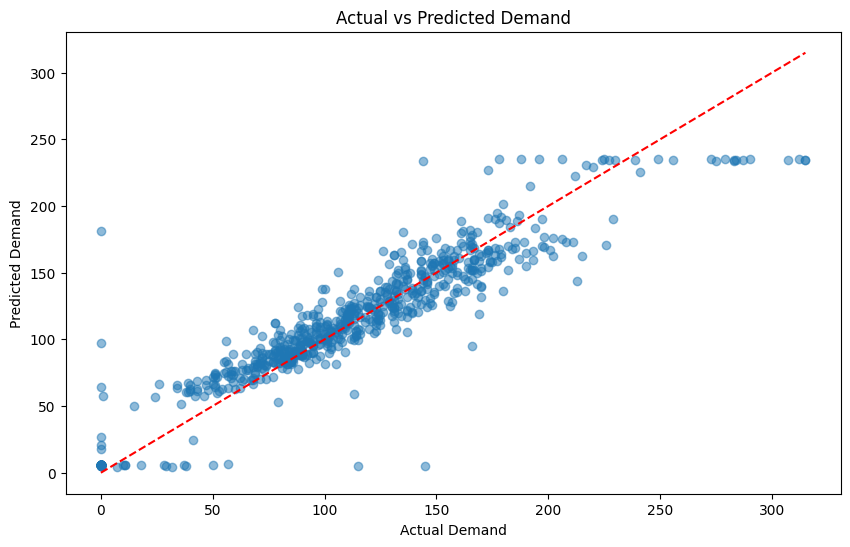

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("synthetic_demand_data_4.csv")  # Replace with your dataset file

# Select important features
data = data[['date', 'product_id', 'current_stock', 'restock_amount',
             'is_promotion', 'is_holiday', 'is_peak_season', 'reorder_point',
             'lead_time', 'demand_lag_1', 'demand_lag_2', 'demand_lag_3',
             'demand_rolling_mean', 'demand_rolling_std', 'demand']]

# Prepare your text input
data['input_text'] = data.apply(lambda x: f"Date: {x['date']} | Product ID: {x['product_id']} | "
                                          f"Current Stock: {x['current_stock']} | Restock Amount: {x['restock_amount']} | "
                                          f"Promotion: {x['is_promotion']} | Holiday: {x['is_holiday']} | "
                                          f"Peak Season: {x['is_peak_season']} | Reorder Point: {x['reorder_point']} | "
                                          f"Lead Time: {x['lead_time']} | Demand Lag 1: {x['demand_lag_1']} | "
                                          f"Demand Lag 2: {x['demand_lag_2']} | Demand Lag 3: {x['demand_lag_3']} | "
                                          f"Rolling Mean: {x['demand_rolling_mean']} | Rolling Std: {x['demand_rolling_std']}",
                                          axis=1)

# Train-validation split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Dataset class
class DemandDataset(Dataset):
    def __init__(self, texts, targets, tokenizer):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]

        # Tokenize and encode the text
        encoding = self.tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=512)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)  # Assuming demand is continuous
        }

# Evaluate model metrics
def evaluate_model(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)

    # If demand is treated as a classification problem, you can add more metrics
    # (e.g., precision, recall, F1 score) if applicable.
    # Here we assume demand is continuous, so these metrics may not apply directly.

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    return mse, mae, rmse

# Function to plot predictions vs actuals
def plot_predictions(predictions, actuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')  # Line for perfect prediction
    plt.xlabel('Actual Demand')
    plt.ylabel('Predicted Demand')
    plt.title('Actual vs Predicted Demand')
    plt.show()

# Train and evaluate model
def train_and_evaluate_model(model_name):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

    # Create datasets and loaders
    train_dataset = DemandDataset(train_data['input_text'].tolist(), train_data['demand'].tolist(), tokenizer)
    val_dataset = DemandDataset(val_data['input_text'].tolist(), val_data['demand'].tolist(), tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    model.train()
    num_epochs = 10  # Set the number of epochs
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(train_loader):
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=targets)

            # Compute loss
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            print(f"Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.flatten()
            predictions.extend(preds.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    # Convert to numpy arrays for metric calculation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Evaluate model
    evaluate_model(predictions, actuals)

    # Save the model
    model.save_pretrained('./distilbert-demand-model')
    tokenizer.save_pretrained('./distilbert-demand-model')

    # Plot predictions vs actuals
    plot_predictions(predictions, actuals)

# Train and evaluate the DistilBERT model
train_and_evaluate_model("distilbert")


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/synthetic_demand_data_4.csv /content/drive/MyDrive/ML_codes

In [ ]:
!cp -r /content/distilbert-demand-model /content/drive/MyDrive/ML_codes